In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=PendingDeprecationWarning)
warnings.filterwarnings(action='ignore', category=ResourceWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

In [3]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [4]:
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# gensim
import gensim 
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
# For punching out domain terms in the future

DOMAIN_WORDS_FILENAME = 'domain_words.txt' 

def load_domain_words(domain_filename):
    with open(text_path, 'r') as content_file:
        text = content_file.read()
        words = text.split(',')
        words_set = set([word.strip().strip("'") for word in words])
    return words_list

In [7]:
def extract_text(text_path):
    with open(text_path, 'r') as content_file:
        text = content_file.read()
    return text

In [9]:
class TextVectorWrap:
    
    CLEAN_DOUBLECHECK_STOPS = ['chapter','chap','appendix','volume','introduction','page','vol','ibid','vol','www','http','com','htm',
                            'ourhollowearth','excerpt', 'htm','matrix iii','see also','turner','index','idaho observer','acknowledgments',
                            'also','issn exopoliticsjournal','exopolitics journal','choice echo','ing','matrix volume','publichealthlaw','publichealthlaw net'
                            'ats member','member comment','web archive', 'archive org', 'org web', 'photograph reprinted',  'net msehpa',  'msehpa pdf', 'nrel', 
                            'reprinted nrel', 'downloading web',  'publichealthlaw', 'publichealthlaw net']
    
    def __init__(self, text_path, extra_stops=[], max_df=0.6, pickle_to=None, display=True):
        
        # Get text filenames
        filenames = sorted([filename for filename in os.listdir(text_path) if '.txt' in filename])
        if filenames == []: print('No text files found!')
        texts = []
        
        # Grab texts
        for filename in filenames:
            #print(filename)
            text = extract_text(text_path+filename)
            texts.append(text)
            
        # Modify stopwords
        stop_words = set(stopwords.words('english'))
        stop_words.update(TextVectorWrap.CLEAN_DOUBLECHECK_STOPS)
        stop_words.update(extra_stops)
    
        # Vectorize
        if display: print('vectorizing: max_df='+str(max_df)+' num_extra_stops='+str(len(extra_stops)))
        vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                     stop_words=stop_words, 
                                     token_pattern="\\b[a-z][a-z][a-z]+\\b",
                                     lowercase=True,
                                     max_df = max_df)
        vector = vectorizer.fit_transform(texts)

        # Define self
        self.filenames = filenames
        self.extra_stops = extra_stops
        self.vectorizer = vectorizer
        self.vector = vector
        self.max_df = max_df
        self.pickle_to = pickle_to
        
        # Pickle
        try:
            if pickle_to:
                pickle.dump(self,open(pickle_to,'wb'))
        except:
            print('pickling failed')

In [10]:
class LdaWrap:
    def __init__(self, vectorwrap_file, pickle_to=None, n_topics=20, min_prob=0.03, passes=10, display=True):
        
        # Load up vector
        if display: print('loading vector')
        vectorwrap = pickle.load(open(vectorwrap_file,'rb'))
        vector = vectorwrap.vector
        vectorizer = vectorwrap.vectorizer
        filenames = vectorwrap.filenames
        vector_T = vector.transpose()
        n_texts = vector.shape[0]
        
        # Build corpus
        if display: print('building corpus')
        corpus = matutils.Sparse2Corpus(vector_T)

        # ID to word dict
        if display: print('defining id2word')
        id2word = { identifier: word for word, identifier in vectorizer.vocabulary_.items()}

        # LDA
        if display: print('lda modeling')
        lda = models.LdaModel(corpus=corpus, num_topics=n_topics, minimum_probability=min_prob, 
                                      id2word=id2word, passes=passes)
        
        # Lists of words describing topics
        if display: print('building topic terms')
        terms = []
        for topic_i in range(n_topics):
            terms.append([id2word[term[0]] for term in lda.get_topic_terms(topic_i)])
            
        # Create topic probs for each text
        if display: print('generating text topic probs')
        texts_topics=np.zeros((n_texts,n_topics))
        for text_i, text in enumerate(corpus):
            text_topics = lda.get_document_topics(text)
            for topic, prob in text_topics:
                texts_topics[text_i, topic] = prob   
           
        # Define self
        if display: print('assigning data')
        self.vectorwrap_file = vectorwrap_file
        self.filenames = filenames
        self.max_df = vectorwrap.max_df
        self.n_texts = n_texts
        self.corpus = corpus
        self.id2word = id2word
        
        self.n_topics = n_topics
        self.min_prob = min_prob
        self.passes = passes  
        self.lda = lda
        self.terms = terms
        self.texts_topics = texts_topics
        self.perplexity = lda.log_perplexity(corpus)
        
        self.pickle_to = pickle_to
        
        # Pickle
        try:
            if pickle_to:
                if display: print('pickling')
                #pickle.dump(self,open(pickle_to,'wb'))
                pickle.dump(self,open(pickle_to,'wb'))
        except:
            print('pickling failed')
            
    def get_top_terms(self):
        result = []
        
        tops = self.lda.top_topics(self.corpus)
        topics = [(topic, score) for topic, score in tops]
        topics_terms = [term for term, _ in topics]
        scores = [score for _,score in tops]
        for topic in topics_terms:
            clean_topic = [term for _,term in topic]
            result.append(clean_topic)
        return list(zip(scores,result))

In [11]:
# Grid search for LDA parameters

topics_dict = {}
max_df_list = [.6,.8,0.4,0.2]
n_topics_list = [50,40,25,35,45]

for max_df in max_df_list:
    # Make vectors
    vectorwrap_path = 'Vectors/tvwrap_none_'+str(max_df)+'.pkl'
    if not os.path.isfile(vectorwrap_path):
        TextVectorWrap('Clean/', extra_stops=[], max_df=max_df, pickle_to=vectorwrap_path)
    else:
        print('found vectorwrap '+str(max_df))
    
    for n_topics in n_topics_list:
        # Make topics
        min_prob=0.03
        passes=10
        ldawrap_path = 'LDA/ldawrap_md'+str(max_df)+'_nt'+str(n_topics)+'_mp'+str(min_prob)+'_p'+str(passes)+'.pkl'
        if not os.path.isfile(ldawrap_path):
            if display: print('building max_df='+str(max_df),'n_topics='+str(n_topics))
            ldawrap = LdaWrap(vectorwrap_path, pickle_to=ldawrap_path, n_topics=n_topics, min_prob=min_prob, passes=passes, display=True)
        else:
            print('found ldawrap '+str(n_topics))
            ldawrap = pickle.load(open(ldawrap_path,'rb'))
            
        # Collect topic terms
        terms = ldawrap.terms
        if not hasattr(ldawrap, 'perplexity'):
            ldawrap.perplexity = ldawrap.lda.get_perplexity(ldawrap.corpus)
        perplexity = ldawrap.perplexity
        test = (n_topics, max_df)
        
        try:
            pickle.dump(topics_dict, open('topics_dict','wb'))
        except:
            print('pickling results failed')
        topics_dict[test] = (perplexity, terms)
        print('added {} {}'.format(test, terms))

found vectorwrap 0.6
building max_df=0.6 n_topics=50
loading vector


KeyboardInterrupt: 

In [ ]:
ldawrap.get_top_terms()

In [ ]:
pickle.dump(ldawrap,open(ldawrap_path,'wb'))

In [16]:
def load_topics_dict(LDA_path):
    files = [file for file in os.listdir(LDA_path) if '.pkl' in file]
    print(files)
    top_dict = {}
    
    for file in files:
        wrap = pickle.load(open(LDA_path+file,'rb'))
        print('loaded '+LDA_path+file)
        test = (wrap.n_topics, wrap.max_df)
        print(test)
        wrap.get_top_terms = LdaWrap.get_top_terms
        tops = wrap.get_top_terms(wrap)
        print(tops)
        print()
        
        
        #terms = wrap.terms
        terms = tops
        
        print(wrap.lda.log_perplexity(wrap.corpus))
        #if not hasattr(wrap, 'perplexity'):
        #    wrap.perplexity = wrap.lda.get_perplexity(wrap.corpus)
        #perplexity = wrap.perplexity
        test = (wrap.n_topics, wrap.max_df)
        top_dict[test] = (wrap.perplexity, wrap.terms)
    return top_dict

In [18]:
top_dict2 = load_topics_dict('/Volumes/Passport/DataScience/Conspiracy_Theories/LDA/')

['ldawrap_md0.2_nt15_mp0.03_p10.pkl', 'ldawrap_md0.2_nt20_mp0.03_p10.pkl', 'ldawrap_md0.2_nt30_mp0.03_p10.pkl', 'ldawrap_md0.2_nt40_mp0.03_p10.pkl', 'ldawrap_md0.2_nt50_mp0.03_p10.pkl', 'ldawrap_md0.4_nt15_mp0.03_p10.pkl', 'ldawrap_md0.4_nt25_mp0.03_p10.pkl', 'ldawrap_md0.4_nt35_mp0.03_p10.pkl', 'ldawrap_md0.4_nt45_mp0.03_p10.pkl', 'ldawrap_md0.4_nt60_mp0.03_p10.pkl', 'ldawrap_md0.6_nt25_mp0.03_p10.pkl', 'ldawrap_md0.6_nt30_mp0.03_p10.pkl', 'ldawrap_md0.6_nt35_mp0.03_p10.pkl', 'ldawrap_md0.6_nt45_mp0.03_p10.pkl', 'ldawrap_md0.8_nt25_mp0.03_p10.pkl', 'ldawrap_md0.8_nt35_mp0.03_p10.pkl', 'ldawrap_md0.8_nt45_mp0.03_p10.pkl', 'ldawrap_md0.8_nt50_mp0.03_p10.pkl']
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.2_nt15_mp0.03_p10.pkl
(15, 0.2)
[(-1.3357927264212315, ['reptilian', 'reptilians', 'branton', 'kingmakers', 'piano', 'bloodlines', 'clique', 'anunnaki', 'sumerian', 'diana', 'sumer', 'tunnels', 'bloodline', 'organisation', 'shall set', 'muslims', 'caverns', 't

2018-08-24 04:07:58,685 : INFO : -27.183 per-word bound, 152387078.5 perplexity estimate based on a held-out corpus of 176 documents with 18022 words


-27.18316533526939
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.2_nt20_mp0.03_p10.pkl
(20, 0.2)
[(-1.379926305563902, ['bloodline', 'bin laden', 'bloodlines', 'reptilians', 'illuminism', 'jfk', 'sumerian', 'merovingian', 'faa', 'anunnaki', 'qaeda', 'vril', 'density', 'knights templar', 'khrushchev', 'diana', 'eugenics', 'mayan', 'germain', 'grail']), (-5.079936858014788, ['popery', 'horse william', 'behold pale', 'kehillah', 'pale horse', 'babeuf', 'bakunin', 'gentiles', 'gentile', 'maynard', 'jewish question', 'despotism', 'flu', 'internationale', 'louis blanc', 'bolshevism', 'working men', 'blanc', 'whilst', 'william cooper']), (-6.830345442697025, ['dulce', 'yehudi', 'wtc', 'grays', 'occultic', 'roswell', 'fallout', 'new agers', 'agers', 'microwave', 'organisation', 'norad', 'zetetic', 'organisations', 'shall set', 'microwaves', 'truth shall', 'creme', 'operation trojan', 'maitreya']), (-7.502695181826629, ['piano', 'astarte', 'secret powers', 'chaldee', 

2018-08-24 04:10:15,097 : INFO : -31.212 per-word bound, 2487219553.1 perplexity estimate based on a held-out corpus of 176 documents with 18022 words


-31.211886717477004
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.2_nt30_mp0.03_p10.pkl
(30, 0.2)
[(-1.0640728190362012, ['reptilian', 'bloodline', 'reptilians', 'bloodlines', 'tavistock', 'sumerian', 'anunnaki', 'mayan', 'knights templar', 'density', 'tunnels', 'caverns', 'sumer', 'blair', 'voltaire', 'club rome', 'chip', 'microwave', 'novelty', 'cocaine']), (-1.4700850546993507, ['virgo', 'qaeda', 'ascended masters', 'standard oil', 'hijackers', 'mohamed', 'farben', 'gingrich', 'carnegie', 'rockefeller foundation', 'trade center', 'arcane', 'zodiac', 'globalist', 'illuminist', 'globalists', 'grove', 'taliban', 'haig', 'sutton']), (-2.699138216510548, ['goyim', 'byrd', 'new agers', 'bailey', 'occultic', 'witches', 'agers', 'mkultra', 'cathy', 'william cooper', 'lucis', 'brzezinski', 'gorbachev', 'todd', 'lucis trust', 'mind controlled', 'aquino', 'president bush', 'bilderberg', 'jamesjpn']), (-3.144074604899824, ['gentile', 'gentiles', 'piano', 'organisation

2018-08-24 04:12:46,315 : INFO : -39.095 per-word bound, 587202386872.7 perplexity estimate based on a held-out corpus of 176 documents with 18022 words


-39.09506687625135
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.2_nt40_mp0.03_p10.pkl
(40, 0.2)
[(-1.086970528504341, ['disney', 'cheney', 'byrd', 'bailey', 'occultic', 'secret brotherhood', 'kelly', 'cathy', 'lucis', 'gorbachev', 'lucis trust', 'bush administration', 'president bush', 'world religion', 'walt', 'tbe', 'aquino', 'pearl harbor', 'bilderbergers', 'cocaine']), (-1.9640094480657697, ['yahuveh', 'kingdom heaven', 'tammuz', 'son man', 'kingdom god', 'jewish people', 'paganism', 'ishtar', 'diana', 'recognised', 'parables', 'queen heaven', 'baal', 'observance', 'elohim', 'passover', 'assyrian', 'artemis', 'yahushua', 'judah']), (-2.221386223975833, ['airlines flight', 'norad', 'jfk', 'witches', 'new agers', 'grail', 'agers', 'qaeda', 'hijackers', 'merovingian', 'american airlines', 'prieure', 'website', 'hijacked', 'mohamed', 'maitreya', 'united airlines', 'creme', 'heroin', 'alice bailey']), (-2.6107454585861505, ['uucp', 'attctc', 'neidorf', 'riggs

2018-08-24 04:15:58,852 : INFO : -46.463 per-word bound, 96990695130917.3 perplexity estimate based on a held-out corpus of 176 documents with 18022 words


-46.46291158153253
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.2_nt50_mp0.03_p10.pkl
(50, 0.2)
[(-0.6193295389140371, ['bender', 'jarrold', 'lucchesi', 'smallwood', 'ifsb', 'augie', 'brush creek', 'shaver', 'flatwoods', 'desvergers', 'bridgeport', 'space review', 'saucer mystery', 'layne', 'fulton', 'creek', 'moseley', 'hilltop', 'nunley', 'curilovic']), (-0.8740582405577059, ['based monetary', 'son republic', 'asset based', 'look learn', 'mcclellan', 'general mcclellan', 'book mormon', 'reich rich', 'joseph smith', 'wherefore', 'mysterious voice', 'republic look', 'house israel', 'american prophet', 'day saints', 'prophet joseph', 'parchment', 'citizens need', 'great peril', 'saying son']), (-0.9651955643743018, ['tavistock', 'eugenics', 'bennewitz', 'harriman', 'implants', 'sirhan', 'chapman', 'brien', 'constantine', 'leary', 'mcveigh', 'huxley', 'bowart', 'stimulation', 'phillips', 'lennon', 'wundt', 'delgado', 'candy', 'sodium']), (-1.287098820846448, [

2018-08-24 04:20:02,414 : INFO : -53.379 per-word bound, 11716627935342078.0 perplexity estimate based on a held-out corpus of 176 documents with 18022 words


-53.379406937706264
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.4_nt15_mp0.03_p10.pkl
(15, 0.4)
[(-0.5902799117127225, ['illuminati', 'rothschild', 'masonic', 'reptilian', 'new age', 'goddess', 'secret societies', 'knights', 'freemasonry', 'serpent', 'jew', 'babylon', 'bloodline', 'clinton', 'templar', 'iraq', 'masonry', 'bloodlines', 'revival', 'nazis']), (-1.1413966874090509, ['obama', 'ufo', 'aliens', 'rockefeller', 'cfr', 'reagan', 'centre', 'extraterrestrial', 'dulce', 'mind control', 'saucer', 'rfid', 'planetary', 'cosmic', 'ufos', 'reptilian', 'federal reserve', 'thy', 'bin', 'kissinger']), (-3.668524426688435, ['branton', 'programming', 'matrix', 'greys', 'monarch', 'cfr', 'gentile', 'rockefeller', 'microwave', 'grays', 'zetetic', 'electromagnetic', 'frequencies', 'alters', 'ihe', 'rockefellers', 'microwaves', 'ibe', 'bennewitz', 'astral']), (-4.279958095962201, ['alters', 'plantard', 'merovingian', 'programmers', 'athos', 'kallistos', 'ursa', 'adam

2018-08-24 04:22:31,447 : INFO : -26.916 per-word bound, 126587813.2 perplexity estimate based on a held-out corpus of 176 documents with 16864 words


-26.915563280263463
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.4_nt25_mp0.03_p10.pkl
(25, 0.4)
[(-0.6207338490023545, ['illuminati', 'new age', 'freemasonry', 'goddess', 'serpent', 'george bush', 'trilateral', 'iraq', 'extraterrestrial', 'satanic', 'carter', 'pagan', 'bloodline', 'centre', 'esoteric', 'bloodlines', 'skull', 'pyramid', 'trilateral commission', 'genetic']), (-0.6753886590061903, ['jew', 'eisenhower', 'antichrist', 'federal reserve', 'babylon', 'lucifer', 'zionist', 'gentile', 'islam', 'rothschild', 'iran', 'socialist', 'protocols', 'messiah', 'alters', 'gentiles', 'hebrew', 'debt', 'palestine', 'saint']), (-0.6965435659384218, ['rockefeller', 'illuminati', 'reptilian', 'cfr', 'clinton', 'saucer', 'reagan', 'nixon', 'ufos', 'cosmic', 'foreign relations', 'kissinger', 'council foreign', 'rothschilds', 'rothschild', 'programming', 'reptilians', 'witchcraft', 'greys', 'new mexico']), (-0.741660494892452, ['new age', 'mind control', 'aliens', 'ma

2018-08-24 04:24:55,575 : INFO : -34.586 per-word bound, 25790342966.0 perplexity estimate based on a held-out corpus of 176 documents with 16864 words


-34.58611190742388
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.4_nt35_mp0.03_p10.pkl
(35, 0.4)
[(-0.6733999863555806, ['new age', 'rockefeller', 'obama', 'masonic', 'mind control', 'jew', 'goddess', 'freemasonry', 'oswald', 'knights', 'cfr', 'centre', 'trilateral', 'lucifer', 'esoteric', 'nixon', 'templar', 'lsd', 'templars', 'planetary']), (-0.891356361533732, ['masonry', 'bilderberg', 'secret societies', 'weishaupt', 'anthrax', 'clinton', 'lodges', 'masons', 'vaccine', 'manipulation', 'cheney', 'nasa', 'illuminism', 'rite', 'graham', 'byrd', 'french revolution', 'underground bases', 'scottish', 'density']), (-1.0569585450897299, ['bloodline', 'qaeda', 'iraq', 'airlines flight', 'airlines', 'norad', 'sect', 'adepts', 'secret society', 'sumerian', 'terrorists', 'hijackers', 'american airlines', 'hijacked', 'osama', 'voltaire', 'united airlines', 'rumsfeld', 'osama bin', 'monarchy']), (-1.1125270099261992, ['ascended masters', 'ascended', 'ascended master', 

2018-08-24 04:28:01,510 : INFO : -41.807 per-word bound, 3847128418462.1 perplexity estimate based on a held-out corpus of 176 documents with 16864 words


-41.80691912674042
loaded /Volumes/Passport/DataScience/Conspiracy_Theories/LDA/ldawrap_md0.4_nt45_mp0.03_p10.pkl
(50, 0.4)
[(-0.4751605411892097, ['rockefeller', 'masonic', 'mind control', 'freemasonry', 'masonry', 'rothschild', 'illuminati', 'secret societies', 'george bush', 'lodges', 'masons', 'jew', 'federal reserve', 'nixon', 'lsd', 'lucifer', 'rothschilds', 'bankers', 'mason', 'con']), (-0.617441147448533, ['new age', 'cfr', 'clinton', 'goddess', 'babylon', 'antichrist', 'socialism', 'socialist', 'marx', 'islamic', 'initiation', 'sion', 'biblical', 'merovingian', 'babylonian', 'bishop', 'secretary state', 'demons', 'state department', 'sovereignty']), (-0.7338216191419811, ['thy', 'doctrines', 'disciples', 'freemasons', 'sect', 'ballard', 'resurrection', 'thou', 'saint', 'dragon', 'germain', 'phoenix', 'prices', 'dimension', 'adepts', 'dictatorship', 'mayan', 'prophets', 'amongst', 'inflation']), (-0.7680207423775064, ['genesis', 'aryan', 'scripture', 'tribe', 'noah', 'tribes', 

2018-08-24 04:31:42,584 : INFO : -52.167 per-word bound, 5057463071970988.0 perplexity estimate based on a held-out corpus of 176 documents with 16864 words


-52.16733530402008


EOFError: Ran out of input

In [ ]:
for item in top_dict.items():
    print(item.)

In [ ]:
ldawrap.lda.log_perplexity(ldawrap.corpus)

In [ ]:
ldawrap.lda.top_topics(ldawrap.corpus)

In [ ]:
top_dict[(20, 0.4)] = [(-0.5575085002669247, ['illuminati', 'reptilian', 'rothschild', 'cfr', 'jew', 'freemasonry', 'serpent', 'goddess', 'matrix', 'clinton', 'george bush', 'aliens', 'knights', 'oswald', 'centre', 'reagan', 'federal reserve', 'iraq', 'frequency', 'babylon']), (-0.6698179301436414, ['rockefeller', 'ufo', 'masonic', 'illuminati', 'masonry', 'mind control', 'saucer', 'secret societies', 'programming', 'extraterrestrial', 'masons', 'satanic', 'weishaupt', 'trilateral', 'ufos', 'planetary', 'mkultra', 'saucers', 'lodges', 'rockefellers']), (-1.1968985264929015, ['new age', 'antichrist', 'gentiles', 'initiation', 'palestine', 'virgo', 'hindu', 'reich', 'esu', 'disciples', 'density', 'socialism', 'secret brotherhood', 'zionist', 'microwave', 'bailey', 'triangle', 'prices', 'new agers', 'messiah']), (-2.6074525083376865, ['dulce', 'branton', 'grays', 'aliens', 'tunnels', 'reptilian', 'subterranean', 'wtc', 'caverns', 'cavern', 'ashtar', 'saurian', 'tunnel', 'nevada', 'underground bases', 'lear', 'mutilations', 'archuleta', 'dulce new', 'elite networks']), (-5.357768714465865, ['mind control', 'vril', 'chapman', 'tavistock', 'zee', 'bennewitz', 'sirhan', 'electromagnetic', 'insiders', 'mayan', 'bowart', 'lsd', 'wundt', 'lennon', 'taee', 'aph lin', 'delgado', 'calendar', 'candy', 'chaitkin']), (-6.387785230156066, ['airlines flight', 'norad', 'airlines', 'american airlines', 'wtc', 'chorrera', 'dennis', 'hijacked', 'volume two', 'united airlines', 'matrix iii', 'vanessa', 'faa', 'iii volume', 'mushroom', 'otis', 'scramble', 'south tower', 'air traffic', 'hijacking']), (-8.726886663240494, ['anthrax', 'esoteric philosophy', 'books esoteric', 'eisenhower', 'vaccine', 'four books', 'bioport', 'prieure', 'astarte', 'anthrax mailings', 'mailings', 'faa', 'battelle', 'walt', 'centres', 'twenty four', 'sion', 'healer', 'grail', 'prieure sion']), (-9.116391781429643, ['dulce base', 'helicopters', 'sophisters', 'adepts', 'voltaire', 'alembert', 'bin laden', 'antisocial conspiracy', 'illuminees', 'oklahoma city', 'black helicopters', 'castello', 'trooper', 'loughner', 'dark green', 'assassins', 'fischer', 'special operations', 'drug task', 'paranet']), (-10.005628682952267, ['freemasonry', 'tunnel', 'battlefield earth', 'skills', 'tunnels', 'tunneling', 'secret powers', 'welding', 'behind revolution', 'kit', 'grand orient', 'bases tunnels', 'first aid', 'whilst', 'prepper', 'snipurl', 'underground bases', 'powers behind', 'gear', 'terl']), (-10.891360817328376, ['revival', 'drivera', 'user net', 'net drivera', 'drivera final', 'final warning', 'cyanide', 'kingdom heaven', 'hydrogen cyanide', 'kelly', 'fema', 'nle', 'parables', 'byrd', 'disinfestation', 'plantard', 'true revival', 'rudolf', 'remer', 'auschwitz']), (-10.950054895625097, ['noosphere', 'calendar', 'technosphere', 'law time', 'biosphere', 'bender', 'van tassel', 'tassel', 'witchcraft', 'mulholland', 'noospheric', 'thirteen moon', 'weston', 'gregorian', 'cfr', 'witches', 'giant rock', 'harmonic', 'jarrold', 'gregorian calendar']), (-11.311751371571786, ['horse william', 'william cooper', 'behold pale', 'pale horse', 'edmound', 'shenton', 'gille', 'flat earth', 'archuleta', 'gabe', 'earther', 'questioner', 'gomez', 'flat earther', 'henriet', 'earth society', 'dulce', 'branton', 'zionism', 'randy']), (-12.616108530827413, ['extraterrestrials', 'uucp', 'imperial brain', 'babeuf', 'bakunin', 'council members', 'brain trust', 'katherine', 'swann', 'axelrod', 'peace studies', 'blacks', 'attctc', 'neidorf', 'extraterrestrials living', 'riggs', 'unix', 'southeast asia', 'october issn', 'salla extraterrestrials']), (-12.684574618541545, ['ascended', 'ascended masters', 'shoebat', 'zetetics', 'maya', 'baktun', 'cathars', 'saint', 'germain', 'statement culture', 'rosicrucian', 'new time', 'mayan', 'ighty', 'great host', 'host ascended', 'dulce base', 'mighty presence', 'long count', 'ighty presence']), (-12.87382764363645, ['islam', 'bilderberg', 'hich', 'muslims', 'drian', 'mohamed', 'oechsler', 'ali mohamed', 'islamic', 'upon peace', 'deep events', 'rin', 'islamic government', 'nosair', 'noble messenger', 'bilderberg diary', 'ordinances', 'ali', 'ould', 'qaeda']), (-13.036234266362866, ['rfid', 'jamesjpn', 'todd', 'fonzi', 'john todd', 'ahmed', 'farmers', 'spychips', 'official account', 'kehillah', 'dre', 'gaeton', 'meyssan', 'timeline', 'gaeton fonzi', 'tags', 'thompson', 'new pearl', 'last investigation', 'isi']), (-14.003622795428747, ['yehudi', 'new age', 'theocrasy', 'occult theocrasy', 'kids', 'adam children', 'flat earth', 'millennium', 'adam family', 'carter', 'lemmi', 'interstellar', 'andy', 'kaku', 'brazel', 'lealy', 'vault', 'michaud', 'shamayim', 'satan children']), (-14.200327002861984, ['popery', 'evolutionary', 'fallout', 'ivins', 'zetetic', 'hollow earth', 'hollow', 'romish', 'assaad', 'gruner', 'papal', 'iranian', 'shelter', 'bishops', 'polar opening', 'descent slavery', 'anthrax', 'milingo', 'evolvability', 'diem']), (-15.063144462944297, ['obama', 'ballard', 'saint germain', 'novelty', 'qur', 'timewave', 'germain', 'imam', 'ballards', 'barack', 'barack obama', 'sons liberty', 'break windows', 'president obama', 'timewave zero', 'saint', 'pelosi', 'gerald bryan', 'dictatorship america', 'birther']), (-18.247603812656422, ['obama', 'guidestones', 'piano', 'vrilya', 'operation trojan', 'placenames', 'nasb', 'queensland', 'urga', 'hutuktu', 'khancoban', 'airship', 'living buddha', 'trojan horse', 'mongolia', 'vrilya point', 'uliassutai', 'free masonry', 'sister thedra', 'thedra'])]
top_dict[(30, 1)] = [(-2.246053711930639, ['web archive', 'archive org', 'org web', 'kadmi', 'photograph reprinted', 'intrest', 'nrel gov', 'net msehpa', 'adroit sluths', 'web battelle', 'pdf precisely', 'msehpa pdf', 'nrel', 'battel subsequently', 'reprinted nrel', 'downloading web', 'attached flow', 'publichealthlaw', 'publichealthlaw net', 'intrest conflicts']), (-4.373894070768509, ['snipurl', 'telegraph daily', 'house daily', 'paul david', 'copy jon', 'illinois paul', 'valley sentinal', 'undated copy', 'november microchip', 'month notes', 'machine apocalypse', 'fall martin', 'clipping packard', 'technology eye', 'july neural', 'reprinted nexus', 'sentinal undated', 'packard finality', 'implant reprinted', 'cited timeline']), (-8.866001494981788, ['policy networks', 'reptile aryan', 'transnational policy', 'consensuses', 'power relations', 'henri paul', 'economic globalization', 'dynamics power', 'new entrants', 'elite participants', 'elite community', 'consensus legitimacy', 'consensus formation', 'heart network', 'elite transnational', 'reptile aryans', 'dodi fayed', 'rees jones', 'way ask', 'lack conflict']), (-8.86600149498179, ['root movement', 'fidonet org', 'paranet information', 'heckethorn', 'margiotta', 'paranet fidonet', 'clan gael', 'brahminism', 'service fidonet', 'albert mazzini', 'cerneau', 'hughan', 'cit occult', 'cit seq', 'captain pollard', 'stillson', 'phoenix liberator', 'mazdeism', 'linga', 'neel']), (-9.929921674400722, ['soul scalped', 'ufo fleets', 'mazarin', 'judaea', 'perlesvaus', 'burrus', 'adherents message', 'fouquet', 'programming dreamscape', 'cooper phil', 'information bases', 'ones directing', 'lord shown', 'order shadow', 'replaced aliens', 'soul scalping', 'bodies aliens', 'allows aliens', 'dreamscape manipulation', 'luciferian control']), (-9.929921674400722, ['ighty presence', 'angelic host', 'great angelic', 'mighty legion', 'legion light', 'nechayev', 'unfed', 'eternally sustained', 'unfed flame', 'flame divine', 'tss officials', 'charge forth', 'flame three', 'prime parent', 'forth thy', 'power unfed', 'three cosmic', 'forever sustained', 'pitcher water', 'cross zodiac']), (-10.520988440744576, ['vrilya', 'placenames', 'khancoban', 'vrilya point', 'anps', 'placenames australia', 'world supra', 'ibn sabbah', 'corryong', 'mapoon', 'lunar lander', 'australia september', 'geoff wharton', 'vrilingathi', 'carpentaria', 'kangaroo island', 'coban', 'exhibit exhibit', 'artificial extraterrestrial', 'anglo aryan']), (-10.757415147282115, ['rfid tag', 'spychipped', 'acronym coined', 'auto center', 'spychip', 'wtshtf', 'rfid readers', 'coined jwr', 'machinegun', 'rfid enabled', 'definition courtesy', 'biodiesel', 'emt emergency', 'rfid reader', 'faq subject', 'carry condition', 'context survivalblog', 'col jeff', 'collateralized', 'staff function']), (-11.466695266894739, ['month finality', 'inner resurrection', 'aton light', 'truth esu', 'truthbringer', 'aspect sophia', 'esu brought', 'lie greatest', 'highest command', 'resurrection bodies', 'heaven queen', 'sowest', 'thou sowest', 'sophia also', 'liturgical year', 'aspect earthly', 'swallowed victory', 'celestial starry', 'receive place', 'meaning fertility']), (-12.767042152851216, ['statement culture', 'secret kingmakers', 'york kingmakers', 'basson', 'unit recalled', 'revenge attacks', 'krll', 'wendell willkie', 'designs top', 'delve metaphysical', 'wealth mankind', 'long jump', 'jewry whose', 'usury aim', 'philosophical terms', 'run interest', 'especially limitations', 'limitations especially', 'purpose eliminate', 'intuition philosophically']), (-14.067389038807692, ['bilderberg diary', 'response recovery', 'level exercise', 'opposed incident', 'valentich', 'murden', 'protection opposed', 'terrorism prevention', 'prevention protection', 'gov media', 'media shtm', 'fema site', 'fema runs', 'exercise nle', 'gluhareff', 'programs influences', 'westfields', 'stresa', 'lady thatcher', 'world shadow']), (-15.367735924764169, ['universe society', 'yahuveh', 'shoebat', 'cry muslims', 'revolutions foregoing', 'imperialism constantly', 'muslims since', 'defeated proofs', 'engage sunnis', 'eliminated duty', 'act saddam', 'beliefs imperialists', 'speech proof', 'social islamic', 'ats member', 'member comment', 'yahushua', 'george piano', 'piano covers', 'piano tools']), (-15.485949278032939, ['assaad', 'kean zelikow', 'zelikow commission', 'zelikow report', 'omissions ani', 'witoto', 'ani distortions', 'laura brown', 'heintz', 'putumayo', 'commission account', 'dave vanessa', 'chorro', 'clarke account', 'ivins death', 'found ivins', 'shallett', 'commission says', 'possible account', 'splitt']), (-16.195229397645562, ['jamesjpn', 'northern clique', 'fendley', 'southern clique', 'elberton', 'teutonic zionist', 'secrets vatican', 'minutes megabytes', 'megabytes tape', 'etc minutes', 'attes', 'berosus', 'jamesjpn articles', 'dispensationalists', 'history guidestones', 'finishing company', 'new myths', 'central column', 'evidence demonic', 'theorists christian']), (-16.195229397645562, ['salandria', 'fonzi last', 'auroville', 'gold coast', 'age explosion', 'philadelphia magazine', 'oashpe', 'richard schweiker', 'pratt museum', 'ocdtf', 'park lot', 'force ocdtf', 'crime task', 'helicopters training', 'kieninger', 'grisel', 'church divine', 'vince salandria', 'committee staffers', 'coast magazine']), (-16.195229397645562, ['irinn may', 'attwood', 'bolden', 'nagell', 'henriet', 'pitzer', 'karimi', 'iranian university', 'reza karimi', 'iranian researcher', 'ali reza', 'may iranian', 'heston', 'text screen', 'mme henriet', 'silvia', 'university address', 'reza shah', 'kennedy khrushchev', 'kayla']), (-16.31344275091433, ['chmn', 'oechsler', 'exopoliticsjournal', 'issn exopoliticsjournal', 'exopolitics journal', 'october issn', 'among exopolitics', 'salla extraterrestrials', 'attctc', 'neidorf', 'legion doom', 'area network', 'uucp network', 'tillinghast', 'lya', 'phrack', 'steve jackson', 'usenet news', 'van gruenen', 'bob oechsler']), (-16.4316561041831, ['kallistos', 'serving dragon', 'callisto', 'kallistos ware', 'star guests', 'bishop kallistos', 'major marcel', 'haut', 'von poppen', 'poppen', 'forth effort', 'colonel blanchard', 'thor indara', 'general ramey', 'doug upland', 'posted sunday', 'living fragment', 'solen', 'dragon present', 'private reply']), (-16.549869457451873, ['evolvability', 'evolutionaries', 'intentional evolutionaries', 'notter', 'evolutionary manifesto', 'evolutionary worldview', 'studies nul', 'council directors', 'intentional evolution', 'past evolution', 'advance evolutionary', 'working best', 'critics cfr', 'nul memorandum', 'disaster bush', 'desires motivations', 'disaster problem', 'cheramie', 'papers box', 'disaster born']), (-16.904509517258184, ['true revival', 'body computer', 'lucchesi', 'smallwood', 'ifsb', 'guide global', 'augie', 'icke guide', 'brush creek', 'flatwoods', 'desvergers', 'tbms', 'space review', 'tunneler', 'cliffwall stay', 'base connected', 'uncertain part', 'allegedly work', 'warn predatory', 'cliffwall']), (-17.377362930333266, ['spychips', 'heaven org', 'project angels', 'rfid tags', 'hutuktu', 'living buddha', 'uliassutai', 'yurta', 'creusat', 'deakin', 'andromeda rex', 'healer must', 'kure', 'jenghiz', 'halaris', 'jenghiz khan', 'tuella', 'lyara', 'kazagrandi', 'healer patient']), (-17.495576283602034, ['ballards', 'net mcf', 'mcf concentration', 'gerald bryan', 'antisocial conspiracy', 'illuminees', 'redell', 'religious scholars', 'antimonarchical', 'antimonarchical conspiracy', 'antichristian conspiracy', 'riza', 'accredited messengers', 'shaykh', 'edna ballard', 'sophister', 'philosophism', 'whitted', 'majlis', 'historical part']), (-17.61378963687081, ['yehudi', 'kfm', 'adam children', 'bwiti', 'life doomsday', 'iboga', 'lealy', 'adam family', 'timothy lealy', 'burning man', 'ibogaine', 'secoya', 'retreaters', 'shulgin', 'charging wire', 'cain children', 'lealy chaos', 'cyiei', 'omdorf', 'fallout particles']), (-17.73200299013958, ['sathanas', 'hydrogen cyanide', 'disinfestation', 'remer', 'taee', 'vanue', 'aph lin', 'deep events', 'hcn', 'iron blue', 'aesir', 'pressac', 'mion', 'koom', 'net drivera', 'drivera', 'user net', 'koom posh', 'mutan', 'expert report']), (-17.85021634340835, ['nasb', 'kaku', 'shamayim', 'integratron', 'kardashev', 'revolutionary command', 'iii civilization', 'critzer', 'bouw', 'heavens shamayim', 'future fuehrer', 'foes curious', 'chuwg', 'raqiya', 'legals', 'micaiah', 'revelation nasb', 'civilization capable', 'michio', 'type status']), (-17.96842969667712, ['battlefield earth', 'ali mohamed', 'father gruner', 'ellicott', 'federal city', 'nicholas gruner', 'terl', 'virgoan', 'psychlo', 'father nicholas', 'steven jones', 'constitution avenue', 'cardinal bea', 'fatima network', 'martin martin', 'statements archbishop', 'jim hoffman', 'franzoni', 'audiobook', 'alpha strategist']), (-18.67770981628974, ['based monetary', 'asset based', 'general mcclellan', 'note publisher', 'dragon god', 'leopold foundation', 'citizens need', 'yankelovich', 'foreign attack', 'return dragon', 'going cast', 'woman church', 'horn says', 'victory near', 'shown angel', 'cavern gold', 'belton', 'nato club', 'publisher insert', 'eusberg']), (-18.91413652282728, ['attackonamerica net', 'attackonamerica', 'idaho observer', 'urban renewal', 'author files', 'metropolitan government', 'intolerable act', 'windows break', 'book ozma', 'six suras', 'townshend', 'coroner verdict', 'shonfield', 'suras multiples', 'vigesimal code', 'pendlebury', 'powers ordinances', 'unelected city', 'emergency empowered', 'powers ordinance']), (-19.15056322936482, ['offered demon', 'established collaboration', 'iii volume', 'zetetics', 'birther', 'birther movement', 'obama origins', 'bobby fischer', 'astronomy earth', 'con con', 'sun motions', 'motions south', 'massed intent', 'societies destroying', 'end relies', 'trade alcoholism', 'relies greatly', 'digested region', 'plan limitless', 'alcoholism kinds']), (-19.386989935902363, ['polar opening', 'drian', 'colb', 'loughner', 'obama born', 'decretals', 'tollem', 'romish corporation', 'terrence timewave', 'zero txt', 'brownson', 'obama eligibility', 'ong tory', 'tollem ache', 'fukino', 'olaf jansen', 'voyage hollow', 'alilio', 'studstrup', 'sqrt'])]
top_dict[(20, 0.6)] = [(-0.3936003766125466, ['jewish', 'jews', 'cia', 'bush', 'new age', 'rockefeller', 'ufo', 'alien', 'germany', 'german', 'cfr', 'mind control', 'israel', 'bible', 'world order', 'communist', 'global', 'drug', 'elite', 'kennedy']), (-0.4159071674441088, ['illuminati', 'jesus', 'underground', 'satan', 'masonic', 'commission', 'reptilian', 'brain', 'consciousness', 'freemasonry', 'lord', 'humanity', 'soul', 'universe', 'dulce', 'heaven', 'holy', 'gods', 'divine', 'occult']), (-0.7579570046437676, ['based monetary', 'asset based', 'son republic', 'mcclellan', 'general mcclellan', 'look learn', 'great peril', 'citizens need', 'mysterious voice', 'wherefore', 'republic look', 'coming attack', 'monetary system', 'invading armies', 'american prophet', 'reich rich', 'carelessly', 'unto gentiles', 'day saints', 'parchment']), (-6.303471792926409, ['depending context', 'see also', 'depending', 'prepper', 'bug', 'skills', 'sheople', 'bugging', 'prepping', 'gear', 'first aid', 'jwr', 'canned', 'tourniquet', 'slang', 'angleton', 'kit', 'purify water', 'cantril', 'checklist']), (-8.304978165451494, ['user net', 'statement culture', 'bwiti', 'inflation', 'maynard', 'especially limitations', 'interpretations start', 'religion correct', 'intuition philosophically', 'away art', 'delve metaphysical', 'ends hands', 'jewry whose', 'activities usury', 'perpetuate evil', 'heritage country', 'sciences delve', 'literature human', 'start explaining', 'aim wealth']), (-8.668357128786557, ['noosphere', 'technosphere', 'calendar', 'law time', 'biosphere', 'esu', 'mulholland', 'hollow earth', 'noospheric', 'hollow', 'gottlieb', 'olson', 'thirteen moon', 'weston', 'gregorian', 'mkultra', 'tss', 'flat earth', 'thirteen', 'flat']), (-9.168398121945723, ['kingmakers', 'todd', 'jamesjpn', 'john todd', 'willkie', 'choice echo', 'goldwater', 'secret kingmakers', 'kaye', 'salt lake', 'york kingmakers', 'studstrup', 'mall', 'scranton', 'echo', 'manhole cover', 'delegates', 'lake city', 'crossroads', 'johnny todd']), (-10.941468606092085, ['obama', 'goyim', 'tavistock', 'bennewitz', 'vril', 'witchcraft', 'aliens', 'theocrasy', 'archuleta', 'occult theocrasy', 'gruner', 'barack', 'chapman', 'barack obama', 'zee', 'witches', 'flat', 'edmound', 'milingo', 'shenton']), (-11.080369991792118, ['yahuveh', 'wtc', 'sophisters', 'helicopters', 'alembert', 'nist', 'yahushua', 'elohim', 'black helicopters', 'dark green', 'foreknowledge', 'drug task', 'opium trade', 'impiety', 'ishtar', 'antimonarchical', 'special operations', 'task force', 'equality liberty', 'twin towers']), (-12.071929420631733, ['yehudi', 'van tassel', 'tassel', 'adam children', 'giant rock', 'adam family', 'satan children', 'street wise', 'enosh', 'fallout', 'integratron', 'new nation', 'cain', 'critzer', 'cain children', 'heavenly father', 'george van', 'adam', 'celestial family', 'top pyramid']), (-12.366149690850254, ['islam', 'zetetic', 'bioport', 'cyanide', 'anthrax mailings', 'mailings', 'hydrogen cyanide', 'ascended masters', 'kingdom heaven', 'kingdom', 'disinfestation', 'smallpox', 'bayer', 'islamic', 'parables', 'ighty', 'great host', 'remer', 'auschwitz', 'aventis']), (-12.642705640759266, ['mohamed', 'ali mohamed', 'deep events', 'nosair', 'fifth race', 'brazel', 'mayan', 'mayan calendar', 'white race', 'adamic', 'balloon', 'ramey', 'ephraim', 'calendar', 'wreckage', 'deep state', 'cosmic race', 'scully', 'marcel', 'weather balloon']), (-12.739372504643079, ['airlines flight', 'airlines', 'chmn', 'american airlines', 'microwaves', 'descent slavery', 'united airlines', 'microwave', 'taser', 'wtc', 'nechayev', 'top speed', 'behavioral', 'otis', 'urban renewal', 'jews played', 'religions nations', 'adey', 'pandora', 'low intensity']), (-13.099319592506069, ['clique', 'extraterrestrials', 'extraterrestrial', 'ihc', 'northern clique', 'axelrod', 'swann', 'interstellar', 'extraterrestrials living', 'andy', 'illusion change', 'kaku', 'ihe', 'southern clique', 'centre disaster', 'salla extraterrestrials', 'exopolitics journal', 'among exopolitics', 'october issn', 'exopoliticsjournal']), (-13.207581642380429, ['guidestones', 'new age', 'qur', 'imam', 'new agers', 'elite networks', 'transnational', 'agers', 'age leaders', 'elite policy', 'fendley', 'age christ', 'imam khomeini', 'montessori', 'policy networks', 'upon peace', 'transnational elite', 'elberton', 'fuqaha', 'maitreya']), (-14.302977941265377, ['drivera', 'net drivera', 'drivera final', 'final warning', 'horse william', 'zetetics', 'behold pale', 'nle', 'fema', 'equator', 'level exercise', 'response recovery', 'opposed incident', 'incident response', 'national level', 'tropic', 'motions', 'sun motions', 'foreign troops', 'motions south']), (-14.519292298276257, ['alters', 'disney', 'ihe', 'ibe', 'tbe', 'battlefield earth', 'mantell', 'project saucer', 'walt', 'programmers', 'volume two', 'matrix iii', 'civil affairs', 'maya', 'iii volume', 'baktun', 'purdy', 'mcf concentration', 'net mcf', 'camp plans']), (-14.723005245280504, ['rfid', 'universe society', 'hich', 'drian', 'exopolitics', 'spychips', 'urga', 'hutuktu', 'living buddha', 'rin', 'tags', 'mongolia', 'uliassutai', 'ungern', 'mongol', 'quarantine', 'mongols', 'ould', 'rfid tags', 'yurta']), (-15.32017877511772, ['bilderberg', 'astarte', 'evolutionary', 'romish', 'vrilya', 'william cooper', 'papal', 'pale horse', 'oechsler', 'placenames', 'egg', 'nasb', 'queensland', 'secret powers', 'chaldee', 'evolvability', 'farmers', 'semiramis', 'khancoban', 'evolutionaries']), (-15.790702069536517, ['uucp', 'fonzi', 'sons liberty', 'break windows', 'bakunin', 'dre', 'gaeton', 'babeuf', 'gaeton fonzi', 'last investigation', 'pelosi', 'attctc', 'neidorf', 'riggs', 'blakey', 'unix', 'schweiker', 'bell south', 'legion doom', 'specter'])]
top_dict[(30, 0.8)] = [(-0.15414997298349156, ['god', 'shall', 'american', 'united states', 'president', 'military', 'john', 'money', 'things', 'today', 'house', 'whole', 'age', 'intelligence', 'children', 'body', 'nations', 'federal', 'family', 'thought']), (-0.23979168048952962, ['illuminati', 'jewish', 'jews', 'cia', 'society', 'group', 'bush', 'political', 'ancient', 'christian', 'international', 'york', 'plan', 'council', 'research', 'new york', 'church', 'religion', 'energy', 'rockefeller']), (-0.3367295828226473, ['aspire', 'evil contemptible', 'contemptible ways', 'embodied protocols', 'annihilating islam', 'palestine tomorrow', 'alcoholism kinds', 'aim undermining', 'corrupting consciences', 'trade alcoholism', 'values corrupting', 'character annihilating', 'undermining societies', 'expand nile', 'expansion plan', 'expansion today', 'greatly infiltration', 'destroying values', 'infiltration espionage', 'invasion vicious']), (-0.45801511377473086, ['christ', 'new age', 'humanity', 'universe', 'jesus', 'pope', 'extraterrestrial', 'civilization', 'faith', 'esoteric', 'republican', 'principles', 'planetary', 'inner', 'presence', 'cosmic', 'hierarchy', 'red', 'ing', 'extraterrestrials']), (-0.46656403239661703, ['rothschild', 'flight', 'september', 'pentagon', 'attacks', 'someone', 'bin', 'bin laden', 'minutes', 'templar', 'rothschilds', 'iran', 'laden', 'november', 'roosevelt', 'version', 'institutions', 'january', 'pyramid', 'historical']), (-0.6372070529183533, ['jesus', 'unto', 'kingdom', 'goddess', 'temple', 'sacred', 'cult', 'thy', 'queen', 'wisdom', 'easter', 'throne', 'templars', 'messiah', 'gospel', 'teachings', 'saint', 'astarte', 'creator', 'organisation']), (-0.8855360075295081, ['noosphere', 'technosphere', 'law time', 'biosphere', 'calendar', 'noospheric', 'thirteen moon', 'gregorian', 'gregorian calendar', 'synchronic', 'telektonon', 'harmonic', 'inevitable event', 'thirteen', 'vernadsky', 'moon day', 'synchronic order', 'artificial time', 'synchronization', 'moon calendar']), (-1.0216186671163994, ['iranian', 'irinn', 'irinn may', 'zionist', 'reza', 'sayyid', 'narrator', 'reza karimi', 'may iranian', 'iranian researcher', 'karimi', 'ali reza', 'iranian university', 'jewish immigrants', 'iranian historian', 'lecturer ali', 'university lecturer', 'jew boys', 'bahais', 'pahlavi']), (-2.085437077914919, ['bilderberg', 'kings', 'jerusalem', 'revival', 'sect', 'guidestones', 'programming', 'zionist', 'graham', 'sexual', 'byrd', 'slaves', 'programmed', 'monarch', 'slave', 'invasion', 'houston', 'kelly', 'emperor', 'cathy']), (-2.134058479536196, ['civil affairs', 'net mcf', 'mcf concentration', 'camp plans', 'plans citizens', 'camps concentration', 'mcf', 'trilateralists', 'militarism', 'phonetic spelling', 'would responsible', 'geneva convention', 'houston', 'concentration camp', 'cable splicer', 'splicer', 'phonetic', 'fifth army', 'civilian persons', 'affairs group']), (-3.820342589079783, ['weishaupt', 'mayan', 'barruel', 'cabala', 'mayan calendar', 'rose croix', 'croix', 'robison', 'mirabeau', 'connexion', 'falk', 'illuminism', 'quetzalcoatl', 'winter solstice', 'katun', 'ephraim', 'duc', 'cast earth', 'says lord', 'power air']), (-4.0055157065397795, ['mind control', 'lsd', 'tavistock', 'chapman', 'sirhan', 'mkultra', 'enfant', 'bowart', 'oswald', 'jones', 'wundt', 'delgado', 'lennon', 'candy', 'zodiacal', 'chaitkin', 'brien', 'kehillah', 'wells', 'feral house']), (-4.526716644237423, ['reptilian', 'branton', 'reptilians', 'tunnel', 'tunnels', 'evolutionary', 'bennewitz', 'todd', 'nevada', 'subterranean', 'net drivera', 'user net', 'drivera', 'caverns', 'colorado', 'drivera final', 'mormon', 'valley', 'archuleta', 'mutilations']), (-5.029082510990526, ['alters', 'communists', 'novelty', 'timewave', 'programmers', 'communist', 'eisenhower', 'healer', 'programming', 'wtc', 'nist', 'timewave zero', 'programmer', 'bases tunnels', 'john birch', 'free masonry', 'ching', 'kremlin', 'birch', 'illustration']), (-5.286416395323369, ['ivins', 'assaad', 'anthrax', 'ats member', 'member comment', 'stephenville', 'chemtrails', 'ats', 'spores', 'scientific evidence', 'anthrax spores', 'teleportation', 'titor', 'flask', 'microbiologist', 'moon landings', 'flares', 'army medical', 'bruce ivins', 'ivins death']), (-6.672555083401662, ['anthrax', 'vaccine', 'bioport', 'mkultra', 'anthrax mailings', 'mailings', 'battelle', 'tss', 'smallpox', 'gottlieb', 'gittinger', 'bayer', 'lsd', 'transnational', 'elite networks', 'aventis', 'acambis', 'monarch', 'programming', 'biological weapons']), (-7.889577204064237, ['ascended', 'ascended masters', 'shoebat', 'rise fourth', 'mighty', 'ascended master', 'fourth reich', 'great host', 'ighty', 'host ascended', 'mighty presence', 'ighty presence', 'angelic host', 'thank thee', 'bormann', 'divine love', 'great angelic', 'presence great', 'legion light', 'mighty legion']), (-8.798969401924424, ['merovingian', 'sion', 'grail', 'prieure', 'plantard', 'prieure sion', 'sons liberty', 'break windows', 'rennes', 'dagobert', 'sauniere', 'merovingians', 'pelosi', 'athos', 'godfroi', 'magdalene', 'kallistos', 'windows break', 'intolerable act', 'ursa']), (-8.895803921513046, ['welding', 'snipurl', 'sheople', 'semiauto', 'angleton', 'see snipurl', 'cantril', 'cleaner', 'vacuum', 'pliers', 'kit', 'sewing', 'carbine', 'golitsyn', 'extraterrestrial threat', 'vise', 'chambered', 'art bell', 'lander', 'survivalblog']), (-9.551179551710728, ['islam', 'ballard', 'oswald', 'muslims', 'saint germain', 'sumer', 'germain', 'ballards', 'khrushchev', 'maya', 'long count', 'baktun', 'gerald bryan', 'anunnaki', 'islamic government', 'ordinances', 'diem', 'dictatorship america', 'andy', 'psychic dictatorship']), (-9.60143809325567, ['new age', 'piano', 'gruner', 'qur', 'imam', 'mohamed', 'psychedelic', 'flat earth', 'new agers', 'agers', 'milingo', 'lsd', 'ali mohamed', 'bwiti', 'fatima', 'world religion', 'father gruner', 'shamanic', 'oswald', 'islamic']), (-10.31513601895293, ['yehudi', 'adam', 'arl', 'adam children', 'gods eden', 'william bramley', 'custodial', 'bramley', 'vanue', 'atlan', 'cain', 'adam family', 'satan children', 'adamic', 'jason', 'enosh', 'adam eve', 'new nation', 'white race', 'krll']), (-10.822349968026636, ['clique', 'jamesjpn', 'hich', 'drian', 'ihc', 'northern clique', 'babeuf', 'rin', 'bakunin', 'southern clique', 'ould', 'teutonic', 'tollem', 'ong', 'ith', 'ent', 'igh', 'ong tory', 'lig', 'tollem ache']), (-11.176178429582345, ['goyim', 'fema', 'nle', 'got saved', 'opposed incident', 'response recovery', 'level exercise', 'incident response', 'national level', 'tropic', 'motions', 'foreign troops', 'sun motions', 'goy', 'exercise nle', 'terrorism prevention', 'fema runs', 'prevention protection', 'gov media', 'fema site']), (-11.387094253291687, ['yahuveh', 'uucp', 'oechsler', 'insiders', 'yahushua', 'neidorf', 'attctc', 'gentile', 'riggs', 'elohim', 'unix', 'ishtar', 'bell south', 'legion doom', 'meier', 'gentiles', 'area network', 'wide area', 'passover', 'usenet']), (-13.653078187848452, ['bender', 'chorrera', 'dennis', 'jarrold', 'mushroom', 'vanessa', 'sister thedra', 'thedra', 'psilocybin', 'lucchesi', 'amazon', 'smallwood', 'dmt', 'ayahuasca', 'ifsb', 'esr', 'witoto', 'augie', 'unto thee', 'shaver']), (-13.988233037277817, ['sathanas', 'resurrection', 'horse william', 'behold pale', 'pale horse', 'inner resurrection', 'aesir', 'mion', 'mutan', 'sophia', 'atlans', 'harald', 'mythic', 'tean city', 'aspect sophia', 'darkome', 'death resurrection', 'randy', 'mutan mion', 'rodite']), (-15.646381748839753, ['ibe', 'helicopters', 'obama', 'volume two', 'operation trojan', 'matrix iii', 'tbe', 'iii volume', 'urga', 'emergency powers', 'hutuktu', 'living buddha', 'mongolia', 'idaho observer', 'declared state', 'birther', 'uliassutai', 'airship', 'ordinance', 'ordinances']), (-16.20143718095432, ['disney', 'battlefield earth', 'fonzi', 'walt', 'dre', 'shenton', 'interstellar', 'gaeton', 'gaeton fonzi', 'last investigation', 'terl', 'kaku', 'evacuation', 'blakey', 'earther', 'schweiker', 'michaud', 'specter', 'psychlo', 'ashtar']), (-17.543407895167462, ['rfid', 'popery', 'esu', 'van tassel', 'tassel', 'giant rock', 'anunnaki', 'spychips', 'nasb', 'children matrix', 'tags', 'van', 'rfid tags', 'lealy', 'integratron', 'tag', 'porton', 'popish', 'god creation', 'esu immanuel'])]
top_dict[(40, 0.8)] = [(-0.15993626634475683, ['american', 'president', 'united states', 'cia', 'military', 'group', 'bush', 'john', 'house', 'money', 'intelligence', 'children', 'york', 'international', 'federal', 'new york', 'air', 'nation', 'research', 'age']), (-0.18508741964890882, ['god', 'shall', 'jews', 'things', 'church', 'christ', 'whole', 'society', 'ancient', 'body', 'death', 'thought', 'planet', 'energy', 'alien', 'plan', 'area', 'religion', 'real', 'present']), (-0.33838739739675644, ['illuminati', 'new age', 'spiritual', 'ufo', 'consciousness', 'process', 'moon', 'individual', 'age', 'dark', 'inner', 'mankind', 'mystery', 'hidden', 'strange', 'woman', 'claimed', 'lucifer', 'christians', 'lsd']), (-0.3696008349753127, ['christian', 'family', 'council', 'race', 'jesus', 'reptilian', 'base', 'knew', 'peace', 'committee', 'dulce', 'masonry', 'policy', 'influence', 'bible', 'modern', 'study', 'union', 'source', 'humans']), (-0.371652702014095, ['powers', 'emergency', 'bodies', 'statement', 'culture', 'vatican', 'declared', 'souls', 'elected', 'martin', 'played', 'literature', 'correct', 'model', 'joint', 'mary', 'aliens', 'limited', 'treaty', 'relation']), (-0.4037941741289016, ['religious', 'special', 'islam', 'computer', 'network', 'brotherhood', 'agents', 'result', 'programming', 'letter', 'activity', 'craft', 'scientific', 'surface', 'someone', 'templar', 'propaganda', 'wealth', 'bin', 'justice']), (-0.4322567321553641, ['jewish', 'level', 'jew', 'israel', 'effect', 'citizens', 'minds', 'court', 'rule', 'july', 'protocols', 'zionist', 'paper', 'ufos', 'iran', 'programs', 'troops', 'data', 'code', 'blue']), (-0.4527586221110726, ['solar', 'price', 'production', 'masses', 'meet', 'value', 'presence', 'houston', 'cost', 'labor', 'products', 'mighty', 'goods', 'prices', 'shape', 'product', 'castro', 'safety', 'pain', 'inflation']), (-0.5021186701994311, ['mission', 'cosmic', 'disney', 'civilization', 'guy', 'supposedly', 'atlantis', 'eisenhower', 'types', 'races', 'superior', 'destiny', 'indicate', 'fifth', 'fraud', 'formation', 'latin', 'alexander', 'bob', 'walt']), (-0.622727101013873, ['principles', 'talk', 'terms', 'tion', 'degrees', 'con', 'radiation', 'results', 'hospital', 'film', 'island', 'byrd', 'pressure', 'fallout', 'pro', 'electric', 'atmosphere', 'olson', 'many people', 'field']), (-0.6649754435299061, ['extraterrestrial', 'beast', 'antichrist', 'extraterrestrials', 'messiah', 'sion', 'prophecy', 'isaiah', 'tools', 'daniel', 'grail', 'flesh', 'ezekiel', 'israel', 'bill clinton', 'merovingian', 'prophets', 'entity', 'middle east', 'bombing']), (-0.670093747780887, ['sun', 'star', 'figure', 'born', 'kings', 'egyptian', 'sky', 'round', 'stars', 'disciples', 'famous', 'choice', 'flat', 'december', 'kingmakers', 'speaking', 'biblical', 'virgin', 'moving', 'candidate']), (-0.680873142100788, ['revival', 'evolutionary', 'sect', 'processes', 'symbolism', 'values', 'esu', 'adepts', 'achieve', 'awareness', 'brethren', 'virgo', 'aim', 'wicked', 'conduct', 'prayer', 'elders', 'pray', 'voltaire', 'kinds']), (-0.7910257346407189, ['nixon', 'rockefellers', 'fields', 'frequencies', 'cfr', 'kingdom', 'microwave', 'sovereignty', 'damage', 'environment', 'microwaves', 'soviets', 'prophetic', 'nelson', 'kingdom heaven', 'chase', 'standard oil', 'guilty', 'malta', 'lear']), (-1.1574483872680263, ['nist', 'foreknowledge', 'wtc', 'flight flight', 'crash site', 'poll', 'steven jones', 'zogby', 'crash', 'ntsb', 'pentagon struck', 'jetliner', 'jim hoffman', 'critiques', 'wtc collapse', 'skyscrapers', 'collapse wtc', 'controlled demolition', 'twin towers', 'military response']), (-1.358430623799416, ['popery', 'despotism', 'every thing', 'popish', 'protestantism', 'despotic', 'religious liberty', 'divine right', 'papists', 'free institutions', 'leopold foundation', 'civil religious', 'protestant sects', 'see note', 'anti republican', 'metternich', 'foreign attack', 'toleration', 'coun try', 'liberty press']), (-1.876690926831123, ['oswald', 'camp', 'matrix', 'skull bones', 'crash', 'conscious', 'conspirators', 'concentration', 'bennewitz', 'skull', 'millennium', 'secret brotherhood', 'archuleta', 'truman', 'dallas', 'khrushchev', 'mental health', 'tbe', 'concentration camp', 'bilderbergers']), (-2.650524086362034, ['urga', 'hutuktu', 'mongolia', 'uliassutai', 'ungern', 'mongol', 'mongols', 'lama', 'yurta', 'bogdo', 'baron ungern', 'mongolian', 'global elite', 'khan', 'bolsheviki', 'lamas', 'jenghiz', 'detachment', 'jenghiz khan', 'kazagrandi']), (-5.124119791483029, ['operation trojan', 'gravity', 'trojan horse', 'airship', 'trojan', 'flap', 'pine gap', 'valentich', 'gravitational', 'gravitic', 'velocity', 'electro', 'melbourne', 'contactee', 'gravitics', 'pine', 'gluhareff', 'baigent leigh', 'ufo', 'vlf']), (-5.274936495905806, ['matrix', 'centre', 'bloodlines', 'anunnaki', 'bloodline', 'centres', 'sumer', 'ibe', 'blair', 'books esoteric', 'healer', 'esoteric philosophy', 'matrix iii', 'children matrix', 'illusion', 'vibrational', 'etheric', 'physical body', 'iii volume', 'four books']), (-5.405206389055322, ['civilizations', 'interstellar', 'civilization', 'extraterrestrial', 'solar system', 'kaku', 'webb', 'kremlin', 'michaud', 'alien civilization', 'kardashev', 'assassins', 'welch', 'type iii', 'extraterrestrial civilization', 'quran', 'interstellar travel', 'iii civilization', 'civilization might', 'civilization would']), (-6.506493130738394, ['roswell', 'kean', 'zelikow', 'brazel', 'commission report', 'kean zelikow', 'balloon', 'neads', 'faa', 'report omissions', 'disc', 'mayan calendar', 'nmcc', 'ramey', 'omissions', 'clarke', 'wreckage', 'marcel', 'weather balloon', 'teleconference']), (-6.779948542636551, ['bwiti', 'dmt', 'iboga', 'shamanic', 'shaman', 'ayahuasca', 'psychedelics', 'dpt', 'burning man', 'mckenna', 'shamanism', 'shamans', 'ibogaine', 'yage', 'crispi', 'secoya', 'shulgin', 'adriano', 'adriano lemmi', 'caesario']), (-7.554477011766526, ['ballard', 'germain', 'saint germain', 'resurrection', 'ballards', 'saint', 'gnostics', 'psychic dictatorship', 'inner resurrection', 'gnostic', 'sophia', 'gerald bryan', 'living buddha', 'dictatorship america', 'death resurrection', 'mythic', 'lama', 'bryan', 'guy ballard', 'messengers']), (-8.800067256372047, ['witchcraft', 'wonderland', 'mcveigh', 'free masonry', 'father george', 'alice wonderland', 'wonderland world', 'evacuation', 'ashtar', 'candy', 'bahrdt', 'illusion change', 'centre disaster', 'pastor', 'want choice', 'got saved', 'right fear', 'trade centre', 'halliburton', 'non lethal']), (-8.863058220425337, ['astarte', 'drivera', 'net drivera', 'user net', 'drivera final', 'final warning', 'egg', 'chmn', 'chaldee', 'semiramis', 'user', 'bechtel', 'pasch', 'cybele', 'schroder', 'name astarte', 'mystic egg', 'forty days', 'astraea', 'ovid']), (-9.384929618661584, ['goyim', 'ahmed', 'official account', 'meyssan', 'new pearl', 'jason', 'maji', 'goy', 'alien craft', 'krll', 'alien presence', 'jason society', 'majic', 'cited timeline', 'grudge', 'quoted ahmed', 'human like', 'near dulce', 'redlight', 'file true']), (-9.4541697723917, ['obama', 'mohamed', 'mantell', 'project saucer', 'ali mohamed', 'oswald', 'purdy', 'deep events', 'colb', 'nosair', 'redell', 'gorman', 'birth', 'eligibility', 'jfk', 'birth certificate', 'ali', 'born', 'balloon', 'kenyan']), (-10.041152158437665, ['plantard', 'battlefield earth', 'transnational', 'elite networks', 'hubbard', 'networks', 'marrs', 'terl', 'elite policy', 'mother goddess', 'khul', 'holy grail', 'battlefield', 'psychlo', 'athos', 'biometrics', 'beast', 'ware', 'policy networks', 'bible prophecy']), (-10.08559391003944, ['cyanide', 'hydrogen cyanide', 'novelty', 'timewave', 'flat earth', 'auschwitz', 'disinfestation', 'remer', 'timewave zero', 'rudolf', 'project monarch', 'zyklon', 'cit note', 'hcn', 'crematorium', 'ching', 'vault', 'iron blue', 'shamayim', 'gas chambers']), (-10.362001700670382, ['calendar', 'noosphere', 'vaccine', 'yehudi', 'technosphere', 'law time', 'biosphere', 'bender', 'vril', 'noospheric', 'thirteen moon', 'gregorian', 'cycle', 'thirteen', 'qur', 'maya', 'anthrax mailings', 'zee', 'battelle', 'imam']), (-10.647931517363581, ['bilderberg', 'universe society', 'exopolitics', 'baktun', 'bilderberg diary', 'quarantine', 'universe', 'webre', 'bilderberg meeting', 'exopolitical', 'universe government', 'interplanetary', 'mayan', 'balam', 'life bearing', 'universe politics', 'interplanetary society', 'planet cultures', 'bearing planets', 'nah chan']), (-10.923422732834732, ['sophisters', 'bin laden', 'sheikh', 'sheikh mohammed', 'illuminees', 'kehillah', 'bin', 'revenge attacks', 'unit recalled', 'laden', 'impiety', 'antimonarchical conspiracy', 'equality liberty', 'antichristian', 'captured killed', 'plaza bank', 'awlaki', 'waterboarded', 'khalid sheikh', 'attacks following']), (-11.117216678663041, ['anthrax', 'ascended', 'bioport', 'ascended masters', 'mailings', 'esoteric philosophy', 'opium', 'books esoteric', 'goodwill', 'smallpox', 'ascended master', 'bayer', 'four books', 'mighty', 'club rome', 'ighty', 'great host', 'aventis', 'host ascended', 'acambis']), (-11.590482480285917, ['obama', 'eisenhower', 'barack', 'barack obama', 'nasb', 'president obama', 'secret powers', 'behind revolution', 'birther', 'powers behind', 'birther movement', 'obama origins', 'birth certificate', 'judaism', 'hawai', 'kahal', 'security number', 'kadmi', 'hungarian', 'kjv']), (-11.86393396780206, ['yahuveh', 'evolvability', 'evolutionaries', 'yahushua', 'evolutionary manifesto', 'inner circle', 'elohim', 'evolutionary worldview', 'evolutionary process', 'ishtar', 'global society', 'living processes', 'intentional evolution', 'gingrich', 'advance evolutionary', 'newt', 'newt gingrich', 'complex systems', 'desires motivations', 'circle illuminati']), (-12.034574629273736, ['tassel', 'van tassel', 'zetetics', 'giant rock', 'gravitation', 'equator', 'prepper', 'tropic', 'motions', 'currents', 'integratron', 'sun motions', 'critzer', 'motions south', 'diagram', 'declination', 'tourniquet', 'tropic cancer', 'george van', 'southern centre']), (-12.636530413287307, ['rfid', 'zetetic', 'spychips', 'tags', 'rowbotham', 'zetetic astronomy', 'flat earth', 'rfid tags', 'astronomy earth', 'astronomy', 'tag', 'earth society', 'spherical earth', 'babylonian brotherhood', 'loughner', 'rfid tag', 'spherical', 'fischer', 'earth globe', 'objections opponents']), (-13.883122579790653, ['piano', 'sathanas', 'arl', 'heaven org', 'project angels', 'vanue', 'angels heaven', 'lucent', 'shaver', 'atlan', 'aesir', 'blip', 'mion', 'dero', 'george piano', 'mutan', 'creusat', 'piano covers', 'deakin', 'atlans']), (-14.161549292651866, ['descent slavery', 'descent', 'nechayev', 'heston', 'text screen', 'footnote', 'soma', 'urban renewal', 'global warming', 'warming', 'fakirs', 'newsreader', 'akasa', 'kayla', 'fakir', 'tears sweat', 'toil tears', 'brahmanical', 'xenocrates', 'alimentarius'])]
top_dict[(50, 0.6)] = [(-0.32151183802111255, ['rockefeller', 'oil', 'brotherhood', 'committee', 'lucifer', 'iraq', 'percent', 'darkness', 'billion', 'evolution', 'basic', 'corporation', 'production', 'economy', 'supply', 'spirits', 'brothers', 'conscious', 'entities', 'market']), (-0.3643552225313963, ['occult', 'christianity', 'lodges', 'trilateral', 'mysteries', 'principles', 'carter', 'paris', 'witchcraft', 'sect', 'priests', 'trilateral commission', 'ship', 'charles', 'ray', 'sir', 'testament', 'writings', 'initiated', 'journal']), (-0.36615335859303416, ['communist', 'world order', 'new world', 'russia', 'soul', 'jews', 'societies', 'bilderberg', 'roman', 'eisenhower', 'jew', 'communists', 'doctrine', 'philosophy', 'communism', 'dollars', 'doctrines', 'minister', 'conference', 'newspaper']), (-0.3723599385008958, ['illuminati', 'jewish', 'jesus', 'lord', 'global', 'masonic', 'elite', 'consciousness', 'freemasonry', 'rothschild', 'unto', 'lodge', 'temple', 'civilization', 'universe', 'world war', 'egypt', 'extraterrestrial', 'britain', 'humanity']), (-0.39779615835444027, ['satan', 'cfr', 'israel', 'bible', 'holy', 'heaven', 'christians', 'rome', 'clinton', 'goddess', 'jews', 'pope', 'weishaupt', 'worship', 'catholic', 'revelation', 'antichrist', 'beast', 'sacred', 'prince']), (-0.4264801812058919, ['new age', 'george bush', 'protocols', 'board', 'china', 'hierarchy', 'skull', 'disciples', 'vice', 'initiation', 'workers', 'bones', 'goals', 'asia', 'skull bones', 'unity', 'values', 'leadership', 'foreign policy', 'french revolution']), (-0.5230982857443152, ['mind control', 'masonry', 'kingdom', 'secret societies', 'jews', 'nixon', 'ufos', 'organized', 'throne', 'marx', 'illuminism', 'employed', 'colonel', 'roswell', 'helicopters', 'jones', 'funding', 'prominent', 'funds', 'witness']), (-0.5314811751500021, ['objects', 'reagan', 'tools', 'tape', 'lights', 'bennewitz', 'faa', 'fallout', 'bishop', 'fifty', 'shaped', 'foot', 'upper', 'remote', 'took place', 'truck', 'tool', 'pieces', 'arthur', 'dynasty']), (-0.558504953655786, ['bush', 'commission', 'kennedy', 'brain', 'fbi', 'soviet', 'obama', 'flight', 'pentagon', 'oswald', 'plane', 'white house', 'aircraft', 'attacks', 'frequency', 'bin', 'assassination', 'behavior', 'wife', 'electromagnetic']), (-0.5774022220253286, ['constitution', 'cult', 'programming', 'thomas', 'executive', 'section', 'genetic', 'alters', 'horse', 'seed', 'senate', 'identity', 'graham', 'programmed', 'levels', 'grays', 'slaves', 'slave', 'teachings', 'twelve']), (-0.6517291875912584, ['cia', 'alien', 'underground', 'german', 'germany', 'ufo', 'technology', 'hitler', 'aliens', 'drug', 'dulce', 'nazi', 'gods', 'air force', 'humans', 'nuclear', 'flying', 'drugs', 'branton', 'matrix']), (-0.6904102667034336, ['reptilian', 'trade', 'faith', 'culture', 'kings', 'prophecy', 'cycle', 'institutions', 'wtc', 'secrets', 'world trade', 'peoples', 'goyim', 'resurrection', 'collapse', 'gospel', 'trade center', 'masses', 'crash', 'races']), (-0.7314445836323439, ['craft', 'secret society', 'templars', 'weather', 'horus', 'captain', 'malta', 'grand lodge', 'miracles', 'balloon', 'myth', 'fraternity', 'priory', 'hybrid', 'secret government', 'references', 'astrological', 'many others', 'looked like', 'tea']), (-1.0359842611776982, ['divine', 'centre', 'masters', 'liberty', 'tion', 'con', 'mighty', 'popery', 'thou', 'ascended', 'eternal', 'judaism', 'healing', 'host', 'ascended masters', 'qaeda', 'protestant', 'alliance', 'initiate', 'principal']), (-1.037809748381987, ['obama', 'colb', 'eligibility', 'birth certificate', 'kenyan', 'obama born', 'obama birth', 'hawaii', 'obama eligibility', 'fukino', 'kenya', 'long form', 'live birth', 'born united', 'kenyan born', 'form birth', 'form colb', 'certification live', 'indonesian', 'wnd']), (-1.0486514749867335, ['uucp', 'computer', 'unix', 'attctc', 'neidorf', 'riggs', 'bell south', 'legion doom', 'software', 'node', 'wide area', 'area network', 'nodes', 'file', 'usenet', 'hackers', 'uucp network', 'computers', 'cyberpunk', 'phrack']), (-1.075206187979734, ['transnational', 'elite policy', 'policy networks', 'transnational elite', 'consensus', 'critical understanding', 'legitimacy', 'consensuses', 'power relations', 'members elite', 'economic globalization', 'new entrants', 'consensus legitimacy', 'heart network', 'consensus formation', 'elite community', 'elite transnational', 'elite participants', 'world politics', 'international consensus']), (-1.083212853172624, ['place shall', 'jesus sananda', 'rescue workers', 'esu jesus', 'peace shall', 'unto father', 'ones shall', 'upon place', 'shall north', 'creation unto', 'balance place', 'ones take', 'shall great', 'wherein shall', 'beneath waters', 'protection come', 'doubt doubt', 'great places', 'ones mine', 'words beloved']), (-1.1338057443175353, ['islam', 'noosphere', 'ing', 'monarch', 'calendar', 'victims', 'islamic', 'teaching', 'expression', 'net', 'technosphere', 'dimensional', 'law time', 'moon', 'biosphere', 'thirteen', 'measure', 'ill', 'muslims', 'pain']), (-1.2035834265750072, ['republican', 'socialism', 'socialist', 'ballard', 'germain', 'students', 'saint', 'kingmakers', 'conspirators', 'candidate', 'dictatorship', 'saint germain', 'louis', 'convention', 'whilst', 'labour', 'los angeles', 'socialists', 'republicans', 'taft']), (-1.265270987560517, ['project saucer', 'mantell', 'saucer', 'purdy', 'sighting', 'redell', 'gorman', 'disks', 'disk', 'steele', 'godman', 'boggs', 'balloons', 'space ship', 'godman field', 'chiles', 'guided missile', 'balloon', 'whitted', 'saucer report']), (-1.410473936378351, ['mulholland', 'weston', 'lovell', 'mcdermott', 'benson', 'brinton', 'ballantine', 'circumstance', 'expertise', 'buxton', 'rosa', 'wendy', 'john mulholland', 'lashbrook', 'author files', 'mkultra document', 'science report', 'agency mkultra', 'garrett', 'townshend']), (-1.4397420556407508, ['bloodline', 'tavistock', 'sion', 'piano', 'committee', 'opium', 'grail', 'subterranean', 'india', 'prieure', 'round table', 'baron', 'blair', 'boy', 'merovingian', 'club rome', 'shaver', 'cave', 'legends', 'british intelligence']), (-2.0989676763029226, ['gentile', 'jew', 'end quoting', 'quoting', 'hatonn', 'jews', 'pistis', 'rec hatonn', 'yiddish', 'world program', 'cahilla', 'adonai', 'rec', 'herzl', 'mystical body', 'jewish', 'dharma', 'semites', 'feb day', 'dtc']), (-3.051033387851052, ['father george', 'bcci', 'wonderland world', 'wonderland', 'illusion change', 'alice wonderland', 'centre disaster', 'want choice', 'teutonic', 'right fear', 'trade centre', 'halliburton', 'choice right', 'world illusion', 'bush family', 'fear love', 'carlyle', 'teutonic zionist', 'problem reaction', 'dick cheney']), (-3.1601541937463913, ['urga', 'hutuktu', 'living buddha', 'mongolia', 'uliassutai', 'ungern', 'mongol', 'mongols', 'lama', 'bogdo', 'yurta', 'chinese', 'baron ungern', 'sheople', 'mongolian', 'buddha', 'khan', 'lamas', 'bolsheviki', 'kure']), (-4.026157114693726, ['qur', 'imam', 'upon peace', 'fifth race', 'noble messenger', 'fuqaha', 'shah', 'imam khomeini', 'qum', 'faqih', 'imams', 'khomeini', 'whites', 'religious scholars', 'ulama', 'commander faithful', 'peace upon', 'tehran', 'najaf', 'shi']), (-4.0824725611732235, ['knights', 'adam', 'templar', 'yehudi', 'laden', 'knights templar', 'assassins', 'creator', 'insiders', 'reagan', 'ibe', 'templars', 'hussein', 'insider', 'adam children', 'heavenly', 'cain', 'jimmy carter', 'stages', 'adam eve']), (-4.609314929310192, ['rothschilds', 'todd', 'jamesjpn', 'hoover', 'sumer', 'john todd', 'vote', 'harvard', 'bank england', 'atlantis', 'partner', 'donovan', 'emergency', 'bechtel', 'vanue', 'idaho', 'manager', 'emergency powers', 'illuminati', 'ordinance']), (-4.639464567338827, ['anthrax', 'bioport', 'anthrax mailings', 'mailings', 'smallpox', 'bayer', 'aventis', 'acambis', 'andy', 'cipro', 'smallpox vaccine', 'baxter', 'lealy', 'oravax', 'anthrax vaccine', 'digital', 'bioterrorism', 'suspects', 'oravax acambis', 'hoechst']), (-5.078333491657813, ['clique', 'ihe', 'ihc', 'northern clique', 'southern clique', 'thai', 'vatican library', 'teutons', 'lime', 'secret suppressed', 'ami', 'tte', 'commoners', 'ilie', 'zionist clique', 'llic', 'lhal', 'kahane', 'arab afghans', 'nol']), (-5.102682927778752, ['shoebat', 'salt lake', 'jason', 'age world', 'secrets new', 'dark secrets', 'file', 'lake city', 'saith lord', 'maji', 'gog', 'majic', 'swear', 'new age', 'jason society', 'alien craft', 'reptilian', 'human like', 'alien presence', 'crossroads']), (-6.045851914339159, ['airlines flight', 'airlines', 'norad', 'ivins', 'american airlines', 'assaad', 'romish', 'anthrax', 'united airlines', 'papal', 'fighters', 'antarctica', 'popes', 'thb', 'sabotage', 'air traffic', 'drug trade', 'scramble', 'bishops', 'mailed']), (-6.273588320425112, ['concentration camp', 'globalists', 'federal government', 'mental health', 'civil affairs', 'executive order', 'net mcf', 'mcf concentration', 'plans citizens', 'camp plans', 'reserve system', 'homeland', 'camps concentration', 'mcf', 'cabala', 'flu', 'pharmaceutical', 'croix', 'rose croix', 'detention']), (-6.8838224534391665, ['priory sion', 'founds', 'fayed', 'von hapsburg', 'babylonian brotherhood', 'hapsburg', 'foundation order', 'dodi', 'comte saint', 'sir francis', 'occult traditions', 'dashwood', 'payseur', 'reptile aryan', 'templar tradition', 'ankhenaton', 'founds secret', 'allegedly plots', 'britain foundation', 'reign ankhenaton']), (-7.142319777967944, ['esoteric philosophy', 'books esoteric', 'centres', 'healer', 'four books', 'etheric', 'katherine', 'physical plane', 'blacks', 'etheric body', 'elsa', 'revolutionary command', 'whites', 'three worlds', 'head centre', 'plexus', 'solar plexus', 'political police', 'heart centre', 'enclave']), (-7.307525963085589, ['bender', 'jarrold', 'tha', 'lucchesi', 'smallwood', 'ifsb', 'augie', 'whole value', 'roberts', 'brush creek', 'desvergers', 'bridgeport', 'space review', 'saucer mystery', 'layne', 'locus', 'bashar', 'patterning', 'fulton', 'creek']), (-7.430242605159468, ['cyanide', 'hydrogen cyanide', 'democrat', 'cit', 'sons liberty', 'break windows', 'disinfestation', 'auschwitz', 'remer', 'pelosi', 'rudolf', 'gas chambers', 'cit note', 'hcn', 'crematorium', 'bureaucrats', 'liberty', 'iron blue', 'pressac', 'executive orders']), (-7.944664799157722, ['cults', 'occultic', 'alice', 'lucis', 'vrilya', 'lucis trust', 'new age', 'zetetics', 'fonzi', 'harvey oswald', 'lee harvey', 'placenames', 'newsletter', 'currents', 'warren commission', 'dre', 'queensland', 'equator', 'australian', 'kennedy assassination']), (-8.167579975848176, ['extraterrestrials', 'sightings', 'books esoteric', 'esoteric philosophy', 'operation trojan', 'world religion', 'four books', 'twenty four', 'trojan horse', 'contactees', 'shamballa', 'axelrod', 'swann', 'airship', 'adamski', 'flap', 'contactee', 'trooper', 'trojan', 'extraterrestrials living']), (-8.59273181585978, ['elite networks', 'studstrup', 'transnational policy', 'dynamics power', 'entrants', 'reptilian mystery', 'disseminate critical', 'enlightened elite', 'progress change', 'networks key', 'center elite', 'certainty world', 'lack conflict', 'within elite', 'frames reference', 'apparent lack', 'may part', 'whether alley', 'staring sort', 'guard desire']), (-9.398142090185969, ['revival', 'evolutionary', 'novelty', 'sins', 'timewave', 'nasb', 'rational', 'qualities', 'true revival', 'evolvability', 'ching', 'evolutionaries', 'timewave zero', 'worldview', 'intentional evolutionaries', 'sequence', 'entertainment', 'restoration', 'evolutionary manifesto', 'prayers']), (-9.491907220258208, ['yahuveh', 'drivera', 'user net', 'net drivera', 'drivera final', 'final warning', 'tammuz', 'ishtar', 'queen heaven', 'user', 'sheikh', 'qaeda', 'mohammed', 'elohim', 'yahushua', 'passover', 'artemis', 'deities', 'sheikh mohammed', 'revenge attacks']), (-9.627629487892737, ['esu', 'horse william', 'chmn', 'nimrod', 'bacchus', 'popish', 'corp', 'schroder', 'god creation', 'esu immanuel', 'creator god', 'aton light', 'osiris', 'ninus', 'greatest lie', 'god aton', 'randy', 'immanuel', 'wilkinson', 'idolatry']), (-10.079939894194014, ['universe society', 'nsa', 'universe', 'bob', 'heaven org', 'project angels', 'big brother', 'oechsler', 'exopolitics', 'interplanetary', 'shenton', 'angels heaven', 'lucent', 'card', 'satellites', 'smart', 'lazar', 'quarantine', 'rotation', 'earther']), (-10.698456187754337, ['rockefeller', 'rockefellers', 'descent slavery', 'descent', 'evacuation', 'ashtar', 'nechayev', 'andromeda rex', 'urban renewal', 'adey', 'health effects', 'ashtar command', 'eeg', 'low intensity', 'andromeda', 'lyara', 'tuella', 'modulated', 'kuthumi', 'pandora']), (-10.88300527198808, ['vaccine', 'zetetic', 'disney', 'walt', 'battelle', 'vaccines', 'spherical earth', 'biological weapons', 'rowbotham', 'zetetic astronomy', 'walt disney', 'astor', 'flat earth', 'cdc', 'memorial institute', 'merck', 'porton', 'earth model', 'mailed anthrax', 'spherical']), (-11.48584615193624, ['kelly', 'byrd', 'houston', 'spartacus', 'free masonry', 'bahrdt', 'mirabeau', 'knigge', 'philo', 'kaye', 'dante', 'mall', 'habib', 'manhole cover', 'nicholai', 'vanderjagt', 'senator byrd', 'robert davis', 'irvarene', 'kaye studstrup']), (-11.861271658961888, ['new age', 'reptilian hybrid', 'kids', 'reptilian hybrids', 'infinite awareness', 'comic', 'articles confederation', 'body computer', 'hybrid', 'adamic race', 'comic books', 'days enoch', 'comic book', 'gospel salvation', 'guide global', 'search scripture', 'icke guide', 'conspiracy end', 'enoch job', 'adamic white']), (-15.03283693093202, ['tassel', 'van tassel', 'theocrasy', 'occult theocrasy', 'giant rock', 'lemmi', 'ats member', 'member comment', 'stephenville', 'chemtrails', 'ats', 'integratron', 'movement see', 'channelling', 'critzer', 'teleportation', 'crispi', 'yarker', 'titor', 'george van'])]
top_dict[(40, 1)] = [(1.7600010336465921e-10, ['web archive', 'org web', 'archive org', 'genomic research', 'attached flow', 'sluths perspective', 'author weeks', 'correspond attached', 'llc preceded', 'removed astonishingly', 'cbiac subsequently', 'sluths', 'web publichealthlaw', 'stm based', 'msehpa msehpa', 'downloading web', 'gov cbiac', 'nrel', 'cbiac', 'research near']), (-4.255680717499737, ['attes', 'berosus', 'ninus nimrod', 'unbloody', 'unbloody sacrifice', 'founder edward', 'crosier', 'baptismal regeneration', 'khons', 'swaddled', 'olenos', 'tax increase', 'swaddled stone', 'ashta', 'babylonian messiah', 'dabar', 'says wilkinson', 'chus', 'sanchuniathon', 'bishop hay']), (-4.255680717499739, ['andromeda rex', 'lyara', 'tuella', 'monka', 'forcefield', 'global evacuation', 'spiritual messenger', 'special volunteers', 'korton', 'space confederation', 'lucy colson', 'commander ashtar', 'intergalactic fleet', 'captain avalon', 'beloved commander', 'planetary evacuation', 'messenger lyara', 'jycondria', 'trilateralists see', 'capitalist democracies']), (-7.920294668831624, ['vrilya', 'placenames', 'loughner', 'khancoban', 'clipping packard', 'technology eye', 'reprinted nexus', 'implant reprinted', 'packard finality', 'telegraph daily', 'fall martin', 'paul david', 'july neural', 'valley sentinal', 'sentinal undated', 'illinois paul', 'undated copy', 'november microchip', 'machine apocalypse', 'house daily']), (-8.86600149498179, ['antisocial conspiracy', 'illuminees', 'antimonarchical', 'antimonarchical conspiracy', 'antichristian conspiracy', 'net drivera', 'drivera', 'user net', 'sophister', 'philosophism', 'drivera final', 'historical part', 'illuminee', 'let alembert', 'warning shining', 'insinuator', 'jean jaques', 'lewis xvi', 'illuminizing', 'epopts']), (-11.34848191362597, ['sathanas', 'vanue', 'religious scholars', 'aesir', 'riza', 'mion', 'shaykh', 'mutan', 'majlis', 'madrasa', 'ayatullah', 'tean city', 'darkome', 'mutan mion', 'rodite', 'jotuns', 'exd', 'awliya', 'khurdad', 'nortans']), (-11.466695266894739, ['colb', 'obama born', 'obama eligibility', 'fukino', 'studstrup', 'live birth', 'kenyan born', 'accounts branton', 'ummites claim', 'reportedly live', 'mountains southwest', 'base connected', 'ummites warn', 'society vega', 'included reports', 'resembling extra', 'ummo accounts', 'allegedly work', 'connected mars', 'scenario doubt']), (-11.70312197343228, ['jamesjpn', 'minutes megabytes', 'megabytes tape', 'etc minutes', 'jamesjpn articles', 'preach see', 'subject salvation', 'writes much', 'learned subject', 'john shiela', 'pope occult', 'testimonial john', 'gavin frost', 'powers enumerated', 'destiny adamic', 'darya jaxartes', 'identity distinct', 'kingdom emphasize', 'deals rise', 'progeny offspring']), (-11.939548679969821, ['hydrogen cyanide', 'disinfestation', 'remer', 'hcn', 'iron blue', 'pressac', 'expert report', 'homicidal gas', 'germar', 'mattogno', 'crematoria iii', 'leopold foundation', 'germar rudolf', 'pierre samuel', 'duyn family', 'delousing', 'van duyns', 'duyns', 'magic kingdom', 'foreign attack']), (-12.648828799582445, ['bloodliners', 'enoch job', 'adamic white', 'ibero american', 'synthetic race', 'darya', 'salvation writes', 'paul learned', 'satan cain', 'third period', 'civilization white', 'infinitely superior', 'white civilization', 'pure whites', 'latinism', 'races going', 'faculties fifth', 'universopolis', 'gospel referred', 'christians hope']), (-12.648828799582445, ['ali mohamed', 'statement culture', 'notter', 'deep events', 'studies nul', 'windows break', 'intolerable act', 'council directors', 'limitations especially', 'politic whole', 'jewry whose', 'boundary sciences', 'interpretations start', 'religion correct', 'philosophical terms', 'mankind ends', 'even explaining', 'sciences delve', 'eliminate limitations', 'jump boundary']), (-12.648828799582445, ['kaku', 'lucchesi', 'smallwood', 'kardashev', 'ifsb', 'augie', 'iii civilization', 'brush creek', 'flatwoods', 'desvergers', 'space review', 'foes curious', 'michio kaku', 'type status', 'civilization capable', 'michio', 'bsra', 'curilovic', 'nunley', 'apostasy takeover']), (-13.358108919195068, ['true revival', 'fendley', 'george piano', 'piano covers', 'elberton', 'repair piano', 'piano repair', 'piano tools', 'euphrates digested', 'digested region', 'invasion refrain', 'proof saying', 'consciences deteriorating', 'clubs sabotage', 'aspire expand', 'annihilating islam', 'infiltration espionage', 'end relies', 'overtook aspire', 'organizations gave']), (-13.358108919195068, ['irinn may', 'idaho observer', 'metropolitan government', 'may iranian', 'ali reza', 'iranian researcher', 'karimi', 'iranian university', 'reza karimi', 'book ozma', 'unelected city', 'powers ordinance', 'municipal emergency', 'emergency empowered', 'powers ordinances', 'reza shah', 'apparatus accordance', 'political expert', 'researcher shams', 'hamid rouhani']), (-14.06738903880769, ['zero txt', 'terrence timewave', 'valentich', 'reptile aryan', 'ordering principles', 'gluhareff', 'henri paul', 'ounter', 'advance novelty', 'documents doc', 'txt file', 'ounter terrence', 'doc ounter', 'books terrence', 'greater novelty', 'maxfield', 'trolley car', 'survival radio', 'fluid space', 'electro gravitic']), (-14.067389038807692, ['zetetics', 'sun motions', 'motions south', 'southern centre', 'mazarin', 'world supra', 'lunar lander', 'southern point', 'round southern', 'two vortices', 'midnight sun', 'great currents', 'southern circle', 'fouquet', 'threat scenario', 'artificial extraterrestrial', 'christian identity', 'ducaud bourget', 'ducaud', 'round north']), (-14.067389038807692, ['tbms', 'tunneler', 'wonder weapons', 'jet tunneling', 'nazi wonder', 'tunnelling', 'reiss', 'judaea', 'perlesvaus', 'tunnelling machines', 'fed doc', 'burrus', 'paperclip space', 'reich american', 'war rooms', 'underground air', 'military underground', 'ultimate war', 'tunnel face', 'adherents message']), (-14.303815745345233, ['body computer', 'guide global', 'revolutionary command', 'icke guide', 'legals', 'major williams', 'end figure', 'gun raids', 'khazar sumerian', 'field command', 'relations councils', 'cohen act', 'liberated zone', 'made manchuria', 'miracle factory', 'existence alien', 'various crash', 'allegedly taking', 'george katherine', 'system troops']), (-14.540242451882774, ['kean zelikow', 'snipurl', 'zelikow commission', 'zelikow report', 'omissions ani', 'ani distortions', 'semiauto', 'see snipurl', 'massed intent', 'ofjesus', 'laura brown', 'wesak festival', 'bore cleaner', 'commission account', 'treadle', 'clarke account', 'commission says', 'possible account', 'leidig', 'photon beam']), (-14.658455805151545, ['nasb', 'auroville', 'age explosion', 'healer must', 'future fuehrer', 'healer patient', 'centres diaphragm', 'micaiah', 'revelation nasb', 'oashpe', 'healing group', 'kieninger', 'glandular system', 'sumtotal', 'soul ray', 'point friction', 'church divine', 'manasic', 'lunar lords', 'aletheia']), (-14.776669158420315, ['month finality', 'attackonamerica net', 'attackonamerica', 'steven jones', 'six suras', 'vigesimal code', 'jim hoffman', 'notifies norad', 'flight hits', 'heading directly', 'wing otis', 'nist wtc', 'collapse theories', 'foreknowledge wtc', 'death manifest', 'norad american', 'kevin ryan', 'response attack', 'story wtc', 'david chandler']), (-14.894882511689087, ['spychips', 'rfid tags', 'cry muslims', 'eliminated duty', 'muslims since', 'defeated proofs', 'revolutions foregoing', 'act saddam', 'beliefs imperialists', 'social islamic', 'imperialism constantly', 'speech proof', 'engage sunnis', 'rfid tag', 'shamayim', 'level exercise', 'opposed incident', 'response recovery', 'aton light', 'spychipped']), (-15.013095864957855, ['net mcf', 'mcf concentration', 'heaven org', 'project angels', 'creusat', 'deakin', 'halaris', 'creusat halaris', 'exhibit exhibit', 'surrounded vacuum', 'extreme radiation', 'anglo aryan', 'content project', 'fenren', 'take prisoners', 'conceivable pretext', 'police lose', 'wickenberg', 'drugs propaganda', 'plans police']), (-15.013095864957856, ['critzer', 'integratron', 'member comment', 'ats member', 'kean zelikow', 'iii volume', 'nechayev', 'zelikow commission', 'rock gatherings', 'channelling sessions', 'omissions ani', 'tassel began', 'tassel death', 'early giant', 'offerings van', 'speakers included', 'zelikow report', 'urban renewal', 'checked probably', 'conventioneers integratron']), (-15.131309218226628, ['yahuveh', 'drian', 'yahushua', 'tollem', 'ong tory', 'tollem ache', 'kadmi', 'alilio', 'fidonet org', 'paranet information', 'astronom', 'kadmi cohen', 'father tollem', 'cabrinovic', 'note publisher', 'drian alilio', 'abelle', 'peretta', 'punishm', 'paranet fidonet']), (-15.249522571495397, ['ballards', 'gerald bryan', 'redell', 'hutuktu', 'living buddha', 'uliassutai', 'yurta', 'accredited messengers', 'edna ballard', 'kure', 'whitted', 'jenghiz', 'chiles whitted', 'jenghiz khan', 'kazagrandi', 'rescue workers', 'soyots', 'kanine', 'major boggs', 'mantell case']), (-16.31344275091433, ['iii volume', 'father gruner', 'nicholas gruner', 'attwood', 'bolden', 'father nicholas', 'nagell', 'pitzer', 'based monetary', 'asset based', 'cardinal bea', 'martin martin', 'statements archbishop', 'fatima network', 'silvia', 'general mcclellan', 'cheramie', 'university address', 'nicky cruz', 'kennedy khrushchev']), (-16.4316561041831, ['northern clique', 'southern clique', 'teutonic zionist', 'acronym coined', 'secrets vatican', 'tillinghast', 'wtshtf', 'coined jwr', 'flap areas', 'cosmic jokers', 'machinegun', 'french faction', 'simonton', 'balance universe', 'biodiesel', 'definition courtesy', 'emt emergency', 'zionist clique', 'holy empire', 'galli']), (-16.4316561041831, ['universe society', 'birther', 'ats member', 'obama origins', 'birther movement', 'member comment', 'basson', 'universe government', 'exopolitical', 'life bearing', 'universe politics', 'planet cultures', 'porton international', 'alibek', 'fdah', 'bearing planets', 'obama family', 'planetary quarantine', 'decade contact', 'evidence commentary']), (-16.549869457451873, ['secret kingmakers', 'york kingmakers', 'cited timeline', 'attctc', 'neidorf', 'quoted ahmed', 'legion doom', 'hufschmid', 'quoted timeline', 'wendell willkie', 'area network', 'uucp network', 'big steal', 'working best', 'critics cfr', 'september cited', 'thompson timeline', 'usenet news', 'steve jackson', 'phrack']), (-16.786296163989412, ['chmn', 'bilderberg diary', 'evolvability', 'evolutionaries', 'intentional evolutionaries', 'evolutionary manifesto', 'evolutionary worldview', 'root movement', 'witoto', 'intentional evolution', 'past evolution', 'heckethorn', 'advance evolutionary', 'murden', 'westfields', 'desires motivations', 'stresa', 'margiotta', 'putumayo', 'heintz']), (-16.904509517258184, ['polar opening', 'battlefield earth', 'ighty presence', 'ellicott', 'angelic host', 'great angelic', 'legion light', 'mighty legion', 'federal city', 'terl', 'unfed', 'virgoan', 'eternally sustained', 'unfed flame', 'psychlo', 'flame divine', 'text screen', 'heston', 'olaf jansen', 'constitution avenue']), (-17.022722870526955, ['oechsler', 'kfm', 'taee', 'life doomsday', 'aph lin', 'koom', 'koom posh', 'tish', 'retreaters', 'charging wire', 'van gruenen', 'gruenen', 'bob oechsler', 'college sages', 'prime parent', 'fallout particles', 'church militant', 'plastic cover', 'concerned hopkins', 'valley library']), (-17.259149577064495, ['salla extraterrestrials', 'exopoliticsjournal', 'issn exopoliticsjournal', 'among exopolitics', 'exopolitics journal', 'october issn', 'lealy', 'policy networks', 'timothy lealy', 'transnational policy', 'consensuses', 'programs influences', 'cyiei', 'lealy chaos', 'lya', 'omdorf', 'power relations', 'extraterrestrial exposure', 'yoda', 'draskovich']), (-17.377362930333263, ['offered demon', 'established collaboration', 'revenge attacks', 'unit recalled', 'krll', 'star guests', 'file true', 'captured killed', 'plaza bank', 'awlaki', 'waterboarded', 'forth effort', 'solen', 'living fragment', 'motor home', 'swear information', 'choosing order', 'reputable persons', 'contained file', 'identify eliminate']), (-17.495576283602038, ['dorr', 'annexations', 'thomason', 'akasa', 'ufp', 'xenocrates', 'brahmanical', 'signs impending', 'jewish discontent', 'possession nine', 'tenths law', 'dark gets', 'mar day', 'dollar die', 'sebastopol', 'cafferata', 'daksha', 'hitler ghost', 'mrs cafferata', 'scmc']), (-17.61378963687081, ['kallistos', 'serving dragon', 'decretals', 'salandria', 'fonzi last', 'romish corporation', 'brownson', 'gold coast', 'philadelphia magazine', 'kenrick', 'thb papal', 'ufo fleets', 'soul scalped', 'thor indara', 'chalabi', 'holographic illusion', 'forged decretals', 'papal corporation', 'bomish', 'richard schweiker']), (-18.086643049945888, ['yehudi', 'assaad', 'adam children', 'adam family', 'cain children', 'disaster bush', 'disaster problem', 'disaster born', 'mohamed trainees', 'ordre temple', 'celestial family', 'dragon god', 'stricte observance', 'stricte', 'found ivins', 'ivins death', 'children adam', 'big dick', 'nations adam', 'disaster real']), (-18.55949646302097, ['shoebat', 'bwiti', 'inner resurrection', 'iboga', 'author files', 'henriet', 'burning man', 'tss officials', 'mme henriet', 'ibogaine', 'townshend', 'principal justice', 'secoya', 'coroner verdict', 'shonfield', 'aspect sophia', 'shulgin', 'pendlebury', 'twelve secret', 'files memorandum']), (-18.79592316955851, ['nechayev', 'integratron', 'urban renewal', 'critzer', 'astronomy earth', 'con con', 'objections opponents', 'truth certainty', 'opponents objections', 'money monopolists', 'cross zodiac', 'pitcher water', 'became thou', 'force ocdtf', 'crime task', 'helicopters training', 'park lot', 'pratt museum', 'ocdtf', 'tears sweat'])]
top_dict[(50, 0.4)] = [(-0.4751605411892097, ['rockefeller', 'masonic', 'mind control', 'freemasonry', 'masonry', 'rothschild', 'illuminati', 'secret societies', 'george bush', 'lodges', 'masons', 'jew', 'federal reserve', 'nixon', 'lsd', 'lucifer', 'rothschilds', 'bankers', 'mason', 'con']), (-0.617441147448533, ['new age', 'cfr', 'clinton', 'goddess', 'babylon', 'antichrist', 'socialism', 'socialist', 'marx', 'islamic', 'initiation', 'sion', 'biblical', 'merovingian', 'babylonian', 'bishop', 'secretary state', 'demons', 'state department', 'sovereignty']), (-0.7338216191419811, ['thy', 'doctrines', 'disciples', 'freemasons', 'sect', 'ballard', 'resurrection', 'thou', 'saint', 'dragon', 'germain', 'phoenix', 'prices', 'dimension', 'adepts', 'dictatorship', 'mayan', 'prophets', 'amongst', 'inflation']), (-0.7680207423775064, ['genesis', 'aryan', 'scripture', 'tribe', 'noah', 'tribes', 'egyptians', 'buddha', 'adam eve', 'luke', 'son god', 'ancestors', 'punishment', 'preach', 'israelites', 'offspring', 'adamic', 'rivers', 'preached', 'white race']), (-0.8253913892215976, ['tassel', 'van tassel', 'giant rock', 'integratron', 'critzer', 'george van', 'williamson', 'channelling', 'laughead', 'dorris', 'knut', 'contactees', 'space people', 'channelling sessions', 'contactee movement', 'tassel death', 'offerings van', 'early giant', 'rock gatherings', 'speakers included']), (-0.8304350312873526, ['magnetic', 'ihe', 'clique', 'vril', 'vatican', 'zionist', 'french revolution', 'rifle', 'zion', 'eisenhower', 'cycles', 'galactic', 'zionism', 'maya', 'tomb', 'nsa', 'stalin', 'arc', 'computers', 'wire']), (-0.8895386773342697, ['matrix', 'extraterrestrial', 'extraterrestrials', 'pyramid', 'psychic', 'airlines', 'airlines flight', 'new age', 'norad', 'density', 'bilderberg', 'hindu', 'pilot', 'nato', 'american airlines', 'blair', 'manipulate', 'airport', 'magical', 'hijacked']), (-0.9112639392455847, ['reptilian', 'bloodlines', 'anunnaki', 'bloodline', 'sumerian', 'skills', 'reptilians', 'tyranny', 'illuminati', 'sumer', 'thousands years', 'democrat', 'blacks', 'matrix', 'vibrational', 'civil war', 'serpent', 'tea', 'gear', 'pistol']), (-0.9432964503006432, ['urga', 'hutuktu', 'living buddha', 'mongolia', 'uliassutai', 'ungern', 'mongol', 'mongols', 'lama', 'bogdo', 'buddha', 'yurta', 'baron ungern', 'mongolian', 'horses', 'khan', 'bolsheviki', 'lamas', 'kure', 'soyot']), (-0.9742180820514927, ['illuminati', 'disney', 'satanic', 'bill clinton', 'lucis', 'lucis trust', 'walt', 'inner circle', 'gingrich', 'gore', 'walt disney', 'world goodwill', 'mayer', 'astor', 'teaches', 'angleton', 'irs', 'satanist', 'moslem', 'newt']), (-0.9904175403981361, ['secret powers', 'behind revolution', 'powers behind', 'kahal', 'kadmi', 'lias', 'kadmi cohen', 'cabrinovic', 'jouin', 'princip', 'buda', 'sonry', 'pesth', 'revolutionary part', 'freema', 'bnai', 'exclusiveness', 'pari', 'kun', 'revo']), (-1.0499530957193566, ['saucers', 'goyim', 'mars', 'planet earth', 'bender', 'implants', 'beam', 'saucer', 'flying saucer', 'programme', 'jim', 'flying saucers', 'solar system', 'marrs', 'mob', 'emotions', 'indians', 'hubbard', 'ashtar', 'science fiction']), (-1.075918357396481, ['dulce', 'knights', 'templar', 'templars', 'rfid', 'genetic', 'bin laden', 'laden', 'grays', 'dulce base', 'rhodes', 'knights templar', 'assassins', 'bin', 'jewry', 'churchill', 'gray', 'descent', 'legends', 'abductees']), (-1.3540436897246697, ['mkultra', 'programming', 'monarch', 'organisation', 'occultic', 'manipulation', 'hypnosis', 'cults', 'organisations', 'fluoride', 'ibe', 'aquino', 'set free', 'patients', 'brien', 'truth shall', 'trauma', 'new age', 'allen dulles', 'volume two']), (-1.506640366110565, ['plato', 'veil', 'footnote', 'soma', 'brahma', 'fakirs', 'fakir', 'akasa', 'brahmanical', 'xenocrates', 'astral light', 'pitris', 'brahmans', 'pythagorean', 'science theology', 'kabalists', 'duad', 'aditi', 'vedas', 'daemons']), (-1.629251286951249, ['electromagnetic', 'frequencies', 'nazis', 'microwave', 'electrical', 'bennewitz', 'satanic', 'fascist', 'greys', 'diana', 'mind controlled', 'microwaves', 'frequency', 'behavioral', 'project saucer', 'mcveigh', 'tesla', 'nobility', 'satanists', 'applications']), (-1.6378992346523589, ['alters', 'isaiah', 'ezekiel', 'messiah', 'programming', 'shoebat', 'saints', 'programmers', 'hath', 'horns', 'end time', 'shall come', 'antichrist', 'saith', 'billy graham', 'lord god', 'programmer', 'saith lord', 'shalt', 'gog']), (-1.6552693156789366, ['sightings', 'faa', 'roswell', 'evidently', 'astarte', 'hijackers', 'saudi', 'easter', 'semiramis', 'egg', 'mulholland', 'crashed', 'venus', 'girl', 'furthermore', 'weston', 'commission report', 'landing', 'orange', 'wright']), (-1.7572959807712192, ['ufo', 'aliens', 'illuminati', 'branton', 'centre', 'serpent', 'esoteric', 'planetary', 'cosmic', 'reportedly', 'new mexico', 'radiation', 'entities', 'books esoteric', 'rituals', 'thee', 'symbolism', 'nasa', 'cancer', 'top secret']), (-2.0180989362577253, ['fallout', 'farmers', 'shelter', 'cartel', 'cyanide', 'seeds', 'farm', 'hydrogen cyanide', 'rudolf', 'hunger', 'hydrogen', 'john birch', 'birch', 'auschwitz', 'birch society', 'dose', 'anti communist', 'farmer', 'crops', 'agriculture']), (-2.1542513368399097, ['new age', 'fema', 'bush administration', 'rumsfeld', 'ahmed', 'isi', 'timeline', 'official account', 'nle', 'kids', 'bin', 'new pearl', 'thompson', 'meyssan', 'bin laden', 'foreign troops', 'afghanistan', 'pearl harbor', 'taliban', 'laden family']), (-2.3173898200220684, ['iran', 'revival', 'qaeda', 'wicked', 'zionist', 'iranian', 'pray', 'muslim', 'goodwill', 'supernatural', 'ali', 'sins', 'advertising', 'abc', 'civilisation', 'mohammed', 'andrew', 'recognised', 'esoteric philosophy', 'zionists']), (-2.3699807249287934, ['cathy', 'aquino', 'dante', 'kelly', 'george bush', 'senator byrd', 'fahd', 'secret brotherhood', 'popery', 'reagan', 'secret societies', 'alex houston', 'houston', 'illuminati', 'byrd', 'masonic', 'skull bones', 'mind control', 'new age', 'diana']), (-2.410633854372677, ['obama', 'trilateral', 'carter', 'evolutionary', 'tion', 'tunnel', 'trilateral commission', 'facility', 'tunnels', 'hospital', 'palestine', 'papal', 'underground bases', 'infinite', 'colorado', 'romish', 'cattle', 'defence', 'truck', 'storage']), (-2.416230733452017, ['reptilian', 'nevada', 'grey', 'reptilians', 'utah', 'interaction', 'humanoids', 'aliens', 'las', 'vegas', 'las vegas', 'jason', 'salt lake', 'orion', 'kfm', 'basement', 'draconian', 'icke', 'lizard', 'antarctic']), (-2.636244222388184, ['oswald', 'saucer', 'ing', 'missile', 'programmed', 'jfk', 'video', 'lee', 'castro', 'todd', 'witches', 'witchcraft', 'dallas', 'khrushchev', 'secret service', 'pilots', 'radar', 'disks', 'jamesjpn', 'cuba']), (-2.7920952972560014, ['millennium', 'dennis', 'planets', 'chorrera', 'civilizations', 'mushroom', 'last days', 'billy', 'interstellar', 'galaxy', 'ayahuasca', 'mushrooms', 'depression', 'hut', 'prophesied', 'bible prophecy', 'amazon', 'billy graham', 'devils', 'vanessa']), (-2.841536882501323, ['anthrax', 'pagan', 'vaccine', 'wtc', 'world trade', 'trade center', 'grand master', 'virgin', 'rite', 'von', 'jones', 'moses', 'towers', 'emperor', 'bioport', 'farben', 'drivera', 'net drivera', 'user net', 'horus']), (-3.796058752523453, ['reagan', 'calendar', 'iraq', 'jew', 'agenda', 'foreign relations', 'kissinger', 'gentile', 'protocols', 'council foreign', 'ufos', 'noosphere', 'gentiles', 'cheney', 'debt', 'frequency', 'guidestones', 'cooper', 'roosevelt', 'protocol']), (-3.8564721311746037, ['rockefellers', 'shall set', 'rockefeller', 'reptilian hybrid', 'nelson', 'comm', 'reptilian hybrids', 'centralised', 'chase manhattan', 'chase', 'hybrids', 'european union', 'infinite awareness', 'nelson rockefeller', 'monsanto', 'manhattan bank', 'rockefeller family', 'david icke', 'romanists', 'body computer']), (-3.953080599356306, ['archuleta', 'operation trojan', 'edmound', 'trojan horse', 'trojan', 'airship', 'gille', 'flap', 'gabe', 'gomez', 'bacchus', 'contactees', 'ute', 'ninus', 'contactee', 'ummites', 'ufo', 'john gille', 'edmound gomez', 'ummo']), (-4.58981192103916, ['dulce', 'shadow government', 'chip implantation', 'bavarians', 'archuleta mesa', 'contact aliens', 'vats', 'phil schneider', 'base located', 'ufo fleets', 'soul scalped', 'schneider', 'wfc', 'scalped', 'alien human', 'grey aliens', 'aliens government', 'non whites', 'alien base', 'colorado border']), (-4.801606107157349, ['popery', 'universe society', 'hollow', 'atlantis', 'gravity', 'protestant', 'hollow earth', 'polar', 'planets', 'exopolitics', 'austria', 'ether', 'interplanetary', 'expedition', 'catholics', 'behaviour', 'polar opening', 'particles', 'cultures', 'quarantine']), (-5.128741873225814, ['see also', 'networks', 'depending context', 'zetetic', 'nimrod', 'hich', 'consensus', 'drian', 'transnational', 'hamilton', 'senses', 'saurian', 'favour', 'ongoing', 'dogma', 'realised', 'simon', 'presently', 'astronomy', 'category']), (-5.165860338004211, ['hebrew', 'ascended', 'ascended masters', 'flat earth', 'perfection', 'scriptures', 'come forth', 'ascended master', 'hebrews', 'ighty', 'great host', 'vault', 'dome', 'host ascended', 'flat earthers', 'ence', 'earthers', 'king james', 'purity', 'angelic']), (-5.230555366031143, ['witchcraft', 'trooper', 'got saved', 'enron', 'witch', 'bohemian grove', 'coven', 'grand druid', 'alex jones', 'newman', 'john doe', 'ryder truck', 'prior knowledge', 'ryder', 'doe number', 'salem', 'kfor', 'owl', 'note publisher', 'government prior']), (-5.2749377334615835, ['mormon', 'satanism', 'gruner', 'bramley', 'william bramley', 'eden', 'custodial', 'fatima', 'archbishop', 'milingo', 'father gruner', 'vatican', 'joseph smith', 'third secret', 'brotherhood network', 'nicholas gruner', 'malachi martin', 'monetary system', 'adam weishaupt', 'malachi']), (-5.323008391102716, ['alice', 'kingdom heaven', 'uucp', 'parables', 'father george', 'powell', 'afghanistan', 'wonderland world', 'alice wonderland', 'osama', 'software', 'bin', 'unix', 'illusion change', 'son man', 'centre disaster', 'want choice', 'halliburton', 'trade centre', 'wonderland']), (-5.469916263969405, ['prieure', 'gods eden', 'prieure sion', 'sauniere', 'rennes', 'dagobert', 'grail', 'prieure documents', 'godfroi', 'lechateau', 'rennes lechateau', 'lorraine', 'cathar', 'blonds', 'seme', 'grey species', 'clovis', 'wolfram', 'gisors', 'romances']), (-5.59561838336838, ['esu', 'fifth race', 'whites', 'god creation', 'esu immanuel', 'aton light', 'greatest lie', 'god aton', 'cosmic race', 'follow laws', 'truthbringer', 'truth esu', 'phoenix journal', 'god jehovah', 'aton', 'jehovah satan', 'fooled people', 'shall reap', 'truth people', 'lie time']), (-7.226740893215758, ['imperial brain', 'gravity', 'council members', 'postwar', 'peace studies', 'brain trust', 'luciferic', 'southeast asia', 'war peace', 'notter', 'council member', 'valentich', 'cfr war', 'national interest', 'velocity', 'gravitic', 'pine gap', 'grand area', 'capitalist class', 'melbourne']), (-7.640393708990811, ['eisenhower', 'kremlin', 'pro communist', 'jew ish', 'tito', 'communist cause', 'judaan', 'communist bosses', 'nehru', 'summit conference', 'popular song', 'george marshall', 'free europe', 'adenauer', 'draskovich', 'zhukov', 'communist propaganda', 'jewish government', 'eisenhower administration', 'eisenhower communist']), (-7.817253685676305, ['yahuveh', 'helicopters', 'black helicopters', 'yahushua', 'elohim', 'ishtar', 'dark green', 'drug task', 'task force', 'special operations', 'operations aviation', 'aviation regiment', 'special forces', 'little bird', 'drink offerings', 'offerings unto', 'regiment', 'conspiracy commit', 'see black', 'pratt museum']), (-7.915414774139051, ['spartacus', 'free masonry', 'bahrdt', 'every thing', 'steele', 'nicholai', 'minerval', 'godman field', 'whitted', 'free masons', 'chiles whitted', 'illuminatism', 'mason lodges', 'licentious', 'reading societies', 'german union', 'pott', 'declamations', 'subordination', 'thousand feet']), (-8.843854582622507, ['kingmakers', 'nasb', 'willkie', 'choice echo', 'goldwater', 'secret kingmakers', 'york kingmakers', 'echo', 'scranton', 'future fuehrer', 'taft', 'fuehrer', 'wendell willkie', 'stassen', 'gallup', 'revelation nasb', 'micaiah', 'kjv', 'looney', 'confederacy']), (-9.46558389181234, ['fourth reich', 'rise fourth', 'reich', 'novelty', 'aspartame', 'timewave', 'globalists', 'bormann', 'nazis', 'ching', 'timewave zero', 'fractal', 'paperclip', 'zero txt', 'terrence timewave', 'nazi germany', 'terrence', 'file documents', 'third reich', 'hess']), (-11.106000019551246, ['islam', 'virgo', 'heaven org', 'project angels', 'muslims', 'insiders', 'lucent', 'angels heaven', 'enfant', 'upon peace', 'big brother', 'zodiacal', 'islamic government', 'ordinances', 'zodiac', 'noble messenger', 'biometrics', 'ellicott', 'peace blessings', 'imperialists']), (-11.55557787764694, ['bilderberg', 'obama', 'president obama', 'birther', 'bilderberg diary', 'barack', 'barack obama', 'chemtrails', 'birther movement', 'obama origins', 'bilderberg meeting', 'teleportation', 'mainstream media', 'hawai', 'marrs ats', 'nazi base', 'family history', 'road signs', 'commentary abovetopsecret', 'abovetopsecret book']), (-13.219355757185859, ['greys', 'ats', 'bwiti', 'dmt', 'iboga', 'shamanic', 'ber ent', 'shaman', 'ats member', 'stephenville', 'psychedelic', 'paranet', 'member comment', 'psychedelics', 'abovetopsecret', 'reptiloids', 'dpt', 'burning man', 'mckenna', 'shamanism']), (-13.543218688955257, ['piano', 'sathanas', 'arl', 'shaver', 'vanue', 'atlan', 'emergency powers', 'aesir', 'idaho observer', 'declared state', 'dero', 'ordinance', 'blip', 'ordinances', 'mion', 'metropolitan government', 'mutan', 'george piano', 'piano covers', 'city manager'])]
top_dict[(40, 0.6)] = [(-0.34178544996279925, ['ufo', 'air force', 'computer', 'flying', 'commission', 'mexico', 'reagan', 'trilateral', 'car', 'ufos', 'carter', 'data', 'alleged', 'site', 'texas', 'workers', 'crash', 'incident', 'supply', 'sex']), (-0.36499382177463724, ['illuminati', 'jews', 'cia', 'jewish', 'bush', 'jesus', 'rockefeller', 'lord', 'global', 'satan', 'germany', 'german', 'masonic', 'bible', 'mind control', 'israel', 'world order', 'elite', 'brain', 'drug']), (-0.486574084920134, ['alien', 'underground', 'communist', 'technology', 'societies', 'aliens', 'humans', 'secret societies', 'anthrax', 'civilization', 'extraterrestrial', 'scientists', 'lodges', 'levels', 'communists', 'solar', 'lucifer', 'principles', 'bases', 'association']), (-0.5242519690675863, ['reptilian', 'dulce', 'matrix', 'branton', 'serpent', 'craft', 'potential', 'thomas', 'aircraft', 'reptilians', 'magnetic', 'facility', 'genetic', 'gravity', 'constitution', 'concentration', 'projects', 'greys', 'tree', 'new mexico']), (-0.5585854308214687, ['kaye', 'studstrup', 'lake city', 'kaye studstrup', 'irvarene', 'robert davis', 'mrs davis', 'kick ass', 'reptilian threat', 'underground faint', 'past hall', 'colonies humans', 'surface days', 'skinned reptilians', 'identical cement', 'however written', 'matt also', 'suicidal afterwards', 'goodman late', 'cubicle fifth']), (-0.5605237455738526, ['universe', 'gods', 'humanity', 'rome', 'divine', 'faith', 'doctrine', 'zionist', 'planetary', 'culture', 'assassination', 'richard', 'paris', 'freemasons', 'marx', 'professor', 'invasion', 'oswald', 'antichrist', 'palestine']), (-0.606166065743428, ['unto', 'rothschild', 'saucer', 'programming', 'plane', 'flight', 'reserve', 'federal reserve', 'darkness', 'researchers', 'wife', 'rothschilds', 'chinese', 'ing', 'mkultra', 'sky', 'troops', 'bankers', 'saucers', 'monarch']), (-0.6087902999371182, ['bin', 'bin laden', 'templar', 'templars', 'revolutionary', 'laden', 'wtc', 'world trade', 'trade center', 'commission', 'races', 'faa', 'towers', 'knights templar', 'superior', 'assassins', 'classes', 'fifth', 'labour', 'strike']), (-0.6215100616126366, ['adam', 'masters', 'mighty', 'symbolism', 'ascended', 'thou', 'thee', 'virgo', 'ascended masters', 'infinite', 'genesis', 'scripture', 'zodiac', 'thy', 'perfection', 'noah', 'egyptians', 'flood', 'enoch', 'venus']), (-0.666386556162288, ['bloodlines', 'trilateral commission', 'bloodline', 'anunnaki', 'insiders', 'ambassador', 'brzezinski', 'sumer', 'david rockefeller', 'iraqi', 'jimmy', 'jimmy carter', 'ronald', 'insider', 'gardner', 'children matrix', 'marshall', 'ronald reagan', 'eisenhower', 'mengele']), (-0.7733116695647311, ['secret society', 'french revolution', 'weishaupt', 'whilst', 'orient', 'grand orient', 'amongst', 'rosicrucian', 'cathars', 'bacon', 'grand lodge', 'cabala', 'rosicrucians', 'internationale', 'illuminist', 'saints', 'revolutionaries', 'world revolution', 'prussia', 'abolition']), (-0.9294237017148257, ['resurrection', 'tavistock', 'sion', 'merovingian', 'grail', 'opium', 'prieure', 'queen', 'saint', 'gospel', 'crown', 'mystical', 'dynasty', 'gnostic', 'club rome', 'british intelligence', 'grove', 'prieure sion', 'gnostics', 'sauniere']), (-1.1807616173536972, ['obama', 'colb', 'eligibility', 'birth certificate', 'kenyan', 'obama born', 'hawaii', 'certificate', 'obama birth', 'obama eligibility', 'fukino', 'kenya', 'long form', 'live birth', 'born united', 'kenyan born', 'form birth', 'honolulu', 'certification live', 'form colb']), (-1.1836233194986094, ['blue', 'gas', 'testament', 'writings', 'esu', 'experiment', 'hollow', 'iron', 'stuff', 'reaction', 'organisation', 'opening', 'balance', 'ice', 'pole', 'jehovah', 'polar', 'hollow earth', 'tyranny', 'check']), (-1.1916557499678575, ['new age', 'consciousness', 'heaven', 'goddess', 'calendar', 'sacred', 'babylon', 'liberty', 'religions', 'pagan', 'noosphere', 'tion', 'con', 'rock', 'peoples', 'one world', 'angels', 'sect', 'morgan', 'mayan']), (-1.9333708438497217, ['operation trojan', 'saurian', 'ufo', 'trojan horse', 'trojan', 'airship', 'flap', 'contactees', 'saurians', 'steiger', 'contactee', 'keel', 'paraphysical', 'ufonauts', 'mts', 'poltergeist', 'wednesday', 'alien race', 'underground systems', 'tillinghast']), (-2.718803372638552, ['weishaupt', 'illuminism', 'shall set', 'barruel', 'truth shall', 'programme', 'jacobins', 'bil', 'robison', 'comm', 'global elite', 'centralised', 'eighteenth', 'eighteenth century', 'illuminized', 'jacobin', 'scotch', 'gnosticism', 'minerval', 'carrington']), (-4.650646517454875, ['new age', 'witchcraft', 'popery', 'witches', 'new agers', 'gruner', 'agers', 'fatima', 'creme', 'milingo', 'maitreya', 'father gruner', 'age leaders', 'archbishop', 'pastor', 'third secret', 'meditation', 'age world', 'age christ', 'khul']), (-6.749968532971044, ['masonry', 'yehudi', 'weishaupt', 'masons', 'adam', 'satan', 'italy', 'mazzini', 'illuminism', 'adam children', 'jordan', 'edmound', 'craft', 'adam family', 'masonic', 'marx', 'gravity', 'occult', 'crispi', 'theocrasy']), (-6.882770618808201, ['todd', 'bennewitz', 'jamesjpn', 'archuleta', 'john todd', 'flat earth', 'edmound', 'flat', 'vault', 'canyon', 'gille', 'peak', 'dome', 'gabe', 'flat earthers', 'earthers', 'monday', 'columbus', 'springmeier', 'rain']), (-7.387694945945217, ['kingmakers', 'theocrasy', 'occult theocrasy', 'willkie', 'goldwater', 'choice echo', 'lemmi', 'taft', 'republicans', 'crispi', 'mazzini', 'delegates', 'secret kingmakers', 'movement see', 'york kingmakers', 'echo', 'scranton', 'yarker', 'root movement', 'adriano']), (-7.6449015169390035, ['evolutionary', 'centres', 'vril', 'zee', 'zetetics', 'healer', 'esoteric philosophy', 'books esoteric', 'physical body', 'etheric', 'twenty four', 'gravitation', 'civilisation', 'equator', 'evolvability', 'four books', 'centre', 'realise', 'currents', 'evolutionaries']), (-8.313288401033402, ['revival', 'islam', 'books esoteric', 'esoteric philosophy', 'four books', 'upon peace', 'true revival', 'humanity', 'islamic government', 'shamballa', 'hierarchy', 'goodwill', 'peace blessings', 'imperialists', 'aspirants', 'pistis', 'repentance', 'religious teaching', 'peace upon', 'imperialist']), (-8.360537804252512, ['ivins', 'astarte', 'nimrod', 'assaad', 'semiramis', 'oswald', 'egg', 'alembert', 'sophisters', 'khrushchev', 'easter', 'sheikh', 'bacchus', 'chaldee', 'anthrax', 'diem', 'festival', 'paganism', 'illuminees', 'knigge']), (-8.86731107916849, ['ballard', 'saint germain', 'germain', 'ballards', 'gerald bryan', 'saint', 'dictatorship america', 'andy', 'lealy', 'psychic dictatorship', 'bryan', 'timothy lealy', 'guy ballard', 'pelley', 'edna', 'accredited messengers', 'mrs ballard', 'cyiei', 'lealy chaos', 'messengers']), (-8.979667525675596, ['fluoride', 'humanoids', 'reptiloids', 'katherine', 'salt lake', 'blacks', 'global warming', 'elsa', 'groom', 'underground base', 'paranet', 'revolutionary command', 'john lear', 'groom lake', 'mall', 'text screen', 'heston', 'crossroads', 'alimentarius', 'codex alimentarius']), (-9.093722292336576, ['depending context', 'see also', 'william bramley', 'gods eden', 'bramley', 'custodial', 'sons liberty', 'break windows', 'depending', 'pelosi', 'eden', 'liberty', 'windows', 'windows break', 'intolerable act', 'jwr', 'germain', 'rawles', 'slang', 'brotherhood network']), (-9.374315384424712, ['battlefield earth', 'hubbard', 'transnational', 'elite networks', 'networks', 'terl', 'elite policy', 'battlefield', 'psychlo', 'policy networks', 'alien invasion', 'transnational elite', 'earth prepared', 'invasion earth', 'critical understanding', 'legitimacy', 'consensuses', 'transnational policy', 'alumni', 'ron hubbard']), (-9.4395007648841, ['obama', 'barack', 'barack obama', 'president obama', 'reptilian hybrid', 'birther', 'reptilian hybrids', 'birther movement', 'obama origins', 'infinite awareness', 'con con', 'birth certificate', 'body computer', 'hawai', 'mainstream media', 'security number', 'certificate', 'guide global', 'icke guide', 'family history']), (-9.461386969465392, ['secret brotherhood', 'skull bones', 'skull', 'jonestown', 'thedra', 'sister thedra', 'chaitkin', 'bones', 'bilderbergers', 'priory', 'berkowitz', 'bonesman', 'unto thee', 'source life', 'bilderberger', 'narut', 'star guests', 'sananda', 'sori', 'points light']), (-9.602892405421237, ['new age', 'fallout', 'shoebat', 'heaven org', 'project angels', 'kids', 'antichrist', 'inflation', 'angels heaven', 'lucent', 'kfm', 'savings', 'maynard', 'life doomsday', 'montessori', 'biometrics', 'goods', 'creusat', 'comic', 'saith lord']), (-9.81660349572894, ['hich', 'drian', 'iranian', 'irinn', 'diana', 'inner circle', 'irinn may', 'reza', 'rin', 'reptile', 'ould', 'sayyid', 'gingrich', 'tollem', 'ong', 'narrator', 'ent', 'ith', 'fayed', 'igh']), (-9.903346265351638, ['shenton', 'flat', 'bowart', 'wundt', 'lennon', 'delgado', 'candy', 'feral house', 'earther', 'questioner', 'constantine alex', 'koski', 'shlain', 'sananda', 'fireball', 'feral', 'flat earther', 'krawczyk', 'lee shlain', 'henriet']), (-10.298694567163977, ['tunnel', 'bender', 'qaeda', 'mohamed', 'fema', 'nle', 'jarrold', 'underground', 'ali mohamed', 'atta', 'tunneling', 'bakunin', 'babeuf', 'tunnels', 'deep events', 'underground facilities', 'deep underground', 'nosair', 'bases tunnels', 'foreign troops']), (-10.625959088814627, ['yehudi', 'ibe', 'adam children', 'matrix iii', 'iii volume', 'adam family', 'adam', 'satan children', 'enosh', 'matrix volume', 'new nation', 'cain', 'cain children', 'lhe', 'heavenly father', 'tht', 'seme', 'grey species', 'blonds', 'celestial family']), (-11.073695784663705, ['guidestones', 'kingdom', 'kingdom heaven', 'oechsler', 'volume two', 'parables', 'lazar', 'meier', 'secrets new', 'son man', 'dark secrets', 'fendley', 'monument', 'kingdom son', 'elberton', 'father kingdom', 'granite', 'abductions', 'underground facility', 'kingdom father']), (-11.284097504041357, ['goyim', 'mantell', 'project saucer', 'purdy', 'redell', 'evacuation', 'gorman', 'goy', 'ashtar', 'andromeda rex', 'steele', 'godman', 'boggs', 'ashtar command', 'andromeda', 'tuella', 'lyara', 'kuthumi', 'space ship', 'chiles']), (-11.363058904083319, ['eisenhower', 'horse william', 'welding', 'wonderland world', 'snipurl', 'kremlin', 'centre disaster', 'flu', 'right fear', 'trade centre', 'choice right', 'swine flu', 'world illusion', 'fear love', 'carbine', 'father george', 'cartridge', 'survivalblog', 'semiauto', 'cush']), (-12.122981554015572, ['bilderberg', 'rfid', 'disney', 'walt', 'spychips', 'tags', 'bilderberg diary', 'luciferic', 'ats member', 'luciferic consciousness', 'rfid tags', 'walt disney', 'member comment', 'chemtrails', 'stephenville', 'collins', 'bilderberg meeting', 'astor', 'tag', 'loughner']), (-13.596278117449485, ['sathanas', 'arl', 'chorrera', 'dennis', 'vanue', 'vanessa', 'atlan', 'aesir', 'psilocybin', 'antisocial conspiracy', 'mion', 'amazon', 'antimonarchical conspiracy', 'mutan', 'esr', 'witoto', 'dero', 'ninus', 'atlans', 'harald'])]
top_dict[(50, 0.8)] = [(-0.16735391248179476, ['shall', 'illuminati', 'military', 'cia', 'money', 'political', 'whole', 'house', 'york', 'plan', 'nations', 'foreign', 'present', 'therefore', 'conspiracy', 'forces', 'really', 'cannot', 'drug', 'whose']), (-0.21224512451593316, ['god', 'united states', 'president', 'jesus', 'today', 'ancient', 'christian', 'children', 'death', 'international', 'lord', 'says', 'sun', 'story', 'organization', 'age', 'king', 'council', 'british', 'media']), (-0.23256869978955372, ['body', 'rockefeller', 'global', 'want', 'top', 'level', 'new world', 'controlled', 'economic', 'cause', 'oil', 'freedom', 'fear', 'create', 'rome', 'food', 'women', 'pope', 'empire', 'energy']), (-0.23585997451103688, ['society', 'church', 'god', 'christ', 'new age', 'spiritual', 'real', 'spirit', 'group', 'religious', 'mind control', 'love', 'brain', 'age', 'consciousness', 'son', 'science', 'self', 'center', 'humanity']), (-0.27240315371139745, ['father', 'unto', 'forth', 'creation', 'centre', 'ones', 'liberty', 'longer', 'soul', 'greater', 'darkness', 'hear', 'thy', 'effort', 'break', 'becomes', 'message', 'prepared', 'magnetic', 'perfect']), (-0.2934557169557977, ['citizens', 'magazine', 'investigation', 'october', 'committee', 'vatican', 'extraterrestrials', 'obvious', 'concentration', 'significant', 'meet', 'covert', 'camp', 'michael', 'martin', 'testimony', 'letters', 'speech', 'protection', 'truly']), (-0.2988028001473881, ['federal', 'bank', 'security', 'europe', 'program', 'germany', 'german', 'communist', 'world order', 'freemasonry', 'police', 'news', 'soviet', 'hitler', 'director', 'service', 'american', 'rothschild', 'computer', 'million']), (-0.41198038719668, ['american', 'john', 'intelligence', 'new york', 'air', 'research', 'report', 'alien', 'washington', 'space', 'planet', 'area', 'ufo', 'things', 'underground', 'head', 'reptilian', 'race', 'major', 'masonic']), (-0.4922314071870165, ['family', 'revelation', 'sure', 'beast', 'available', 'per', 'consider', 'die', 'mark', 'usually', 'industrial', 'start', 'buy', 'prophecy', 'door', 'supply', 'horse', 'survival', 'piano', 'dragon']), (-0.522552936407461, ['jewish', 'jews', 'bush', 'israel', 'jew', 'cfr', 'reagan', 'white house', 'world government', 'jerusalem', 'iraq', 'china', 'gentile', 'nation', 'trilateral commission', 'gentiles', 'chinese', 'administration', 'testament', 'daniel']), (-0.5859623706091656, ['mkultra', 'monarch', 'radiation', 'table', 'hebrew', 'isaiah', 'tape', 'job', 'fallout', 'literally', 'scriptures', 'materials', 'previously', 'shelter', 'alexander', 'torture', 'enoch', 'supplies', 'hypnotic', 'exposure']), (-0.5914321302430536, ['attack', 'agency', 'flight', 'pentagon', 'george bush', 'trust', 'philosophy', 'wtc', 'rock', 'world trade', 'magic', 'hierarchy', 'trade center', 'skull', 'collapse', 'crash', 'techniques', 'bones', 'skull bones', 'allen']), (-0.6040602019281429, ['price', 'facility', 'cost', 'correct', 'goods', 'limited', 'supposedly', 'guy', 'prices', 'phase', 'inflation', 'aids', 'missing', 'abductions', 'jewry', 'bob', 'whole world', 'fraud', 'recall', 'investment']), (-0.7843309515251901, ['lions clubs', 'nile euphrates', 'zionist', 'aspire', 'zion present', 'kinds facilitate', 'deteriorating character', 'invasion vicious', 'embodied protocols', 'greatly infiltration', 'vicious invasion', 'aim undermining', 'zionists aspire', 'open work', 'expansion plan', 'region overtook', 'annihilating islam', 'values corrupting', 'rise freemasons', 'organizations gave']), (-0.8906888403880903, ['kingdom', 'responsible', 'throne', 'glory', 'judgment', 'till', 'vril', 'midst', 'prophetic', 'contain', 'declaration', 'sitting', 'saints', 'gathered', 'kingdom heaven', 'zee', 'wings', 'grace', 'son man', 'yellow']), (-0.9572970152011204, ['khrushchev', 'test ban', 'attwood', 'washington dallas', 'saigon', 'bolden', 'nagell', 'nhu', 'pitzer', 'vinson', 'paine', 'merton', 'ban treaty', 'silvia', 'nikita khrushchev', 'mohrenschildt', 'yates', 'mexico city', 'university address', 'cheramie']), (-0.9896726526919767, ['fema', 'nle', 'level exercise', 'opposed incident', 'response recovery', 'foreign troops', 'incident response', 'national level', 'exercise', 'media shtm', 'protection opposed', 'exercise nle', 'fema site', 'terrorism prevention', 'prevention protection', 'fema runs', 'gov media', 'exercise conducted', 'bankster', 'fema gov']), (-1.2649456609403005, ['witchcraft', 'got saved', 'coven', 'witches', 'nicky', 'inaudible question', 'honorable discharge', 'cruz', 'strike nothing', 'get saved', 'prophesying', 'pyramid political', 'things teaching', 'dall fdr', 'pray fast', 'senator congressman', 'london embassy', 'fdr son', 'illuminati tell', 'strange christians']), (-1.3201709765153877, ['gospel', 'faa', 'eve', 'william cooper', 'tribes', 'genesis', 'tribe', 'racial', 'noah', 'horse william', 'pale horse', 'behold pale', 'cooper', 'rumsfeld', 'poles', 'adam', 'pale', 'adam eve', 'commission', 'currents']), (-1.5117435911551178, ['unit', 'helicopters', 'funding', 'separate', 'knights templar', 'assassins', 'illegal', 'templar', 'fourth reich', 'locations', 'atlantic', 'formerly', 'train', 'trees', 'rise fourth', 'edmound', 'peak', 'bird', 'samples', 'special forces']), (-1.578246044969797, ['resurrection', 'inner resurrection', 'sophia', 'mythic', 'death resurrection', 'aspect sophia', 'easter sunday', 'gospel', 'historical event', 'gospel philip', 'fertility', 'aspect earthly', 'receive place', 'celestial starry', 'sowest', 'thou sowest', 'mythic dimension', 'meaning fertility', 'liturgical year', 'earthly aspect']), (-2.0244094453609685, ['templar', 'anunnaki', 'sumer', 'bramley', 'william bramley', 'gods eden', 'grand lodge', 'sumerian', 'custodial', 'rosicrucian', 'children matrix', 'vibrational', 'eden', 'priory sion', 'symbolised', 'francis', 'essenes', 'sumerians', 'hapsburg', 'founds']), (-2.2274606180163503, ['trilateral', 'committee', 'carter', 'companies', 'corporation', 'adam', 'agencies', 'economy', 'yehudi', 'tavistock', 'ihe', 'hit', 'clique', 'quoted', 'corporate', 'democratic', 'corporations', 'policies', 'administration', 'policy']), (-2.6507376373231697, ['elite', 'processes', 'networks', 'values', 'product', 'mormon', 'capacity', 'critical', 'arabia', 'cooperation', 'davis', 'shoebat', 'consensus', 'communities', 'around world', 'unconscious', 'end time', 'evolutionary', 'salt', 'demands']), (-2.9791755132119304, ['disney', 'elite', 'walt', 'truth shall', 'walt disney', 'global elite', 'astor', 'bil', 'shall set', 'duyn', 'van duyn', 'krupp', 'onassis', 'comm', 'disneyland', 'triads', 'mickey', 'warders', 'cfr bil', 'astors']), (-3.3132958572042233, ['attacks', 'ballard', 'bin laden', 'guidestones', 'saint', 'germain', 'palestine', 'laden', 'saint germain', 'dictatorship', 'iranian', 'angeles', 'eugenics', 'iran', 'zionists', 'monument', 'historian', 'recalled', 'ballards', 'captured']), (-3.4479191614831852, ['heaven org', 'project angels', 'angels heaven', 'lucent', 'card', 'biometrics', 'creusat', 'deakin', 'org', 'iso', 'biochip', 'universal biometrics', 'biometrics card', 'smart card', 'halaris', 'human control', 'beast universal', 'loaf', 'price controls', 'inferno']), (-3.5752903281927706, ['council', 'astarte', 'semiramis', 'egg', 'bacchus', 'chaldee', 'paganism', 'imperial brain', 'postwar', 'chaldean', 'council members', 'brain trust', 'peace studies', 'lent', 'bel', 'cybele', 'worshippers', 'war peace', 'southeast asia', 'dove']), (-3.6004339851328497, ['airlines flight', 'airlines', 'norad', 'american airlines', 'hijacked', 'united airlines', 'air traffic', 'iboga', 'otis', 'flight', 'joseph smith', 'scramble', 'transponder', 'passengers', 'html', 'top speed', 'airliner', 'monetary system', 'north tower', 'reserve act']), (-5.033175557980889, ['cfr', 'birch society', 'mandell', 'mandell house', 'edward mandell', 'mrs clinton', 'birch', 'critics cfr', 'working best', 'conspiring others', 'richard haass', 'haass', 'within territory', 'genetic experiments', 'richard gardner', 'floor plans', 'perloff', 'sought world', 'nation affairs', 'president richard']), (-5.226907798577997, ['ascended', 'ascended masters', 'maya', 'tomb', 'baktun', 'votan', 'perfection', 'ascended master', 'come forth', 'pacal', 'new time', 'pacal votan', 'long count', 'markets', 'cabala', 'ighty', 'great host', 'galactic', 'host ascended', 'human history']), (-5.583068601637754, ['evolutionary', 'farmers', 'evolvability', 'evolutionaries', 'intentional evolutionaries', 'evolutionary manifesto', 'intentional', 'seeds', 'evolutionary worldview', 'evolutionary process', 'living processes', 'global society', 'gog', 'evolution life', 'future evolution', 'worldview', 'intentional evolution', 'past evolution', 'advance evolutionary', 'cartel']), (-5.997968674601937, ['sauniere', 'millennium', 'prieure sion', 'prieure documents', 'dagobert', 'lechateau', 'rennes lechateau', 'godfroi', 'lorraine', 'cathar', 'languedoc', 'new money', 'antarctic', 'clovis', 'wolfram', 'gisors', 'olaf', 'god calling', 'smoky god', 'world leader']), (-6.23504826704421, ['depending context', 'see also', 'kelly', 'byrd', 'houston', 'depending', 'context', 'jwr', 'slang', 'dante', 'habib', 'vanderjagt', 'cox', 'acronym', 'senator byrd', 'semi auto', 'alex houston', 'madrid', 'commonly called', 'country music']), (-6.826569910769728, ['anthrax', 'vaccine', 'popery', 'bioport', 'mailings', 'anthrax mailings', 'vaccines', 'battelle', 'fda', 'smallpox', 'bayer', 'biological weapons', 'pharmaceutical', 'wells', 'aventis', 'tesla', 'delgado', 'haarp', 'acambis', 'popish']), (-7.064912284743117, ['islam', 'descent slavery', 'islamic government', 'ordinances', 'peace blessings', 'imperialists', 'nechayev', 'religious teaching', 'imperialist', 'laws islam', 'messenger upon', 'islam muslims', 'teaching institution', 'muslim countries', 'servants imperialism', 'tears sweat', 'islam order', 'islamic revolution', 'toil tears', 'evil propaganda']), (-8.444594932867718, ['theocrasy', 'occult theocrasy', 'lemmi', 'movement see', 'rec hatonn', 'yiddish', 'world program', 'cahilla', 'crispi', 'yarker', 'root movement', 'adriano', 'kahal', 'adriano lemmi', 'international jew', 'heckethorn', 'john yarker', 'dearborn', 'jewish', 'quoting part']), (-8.797653111600415, ['dmt', 'luciferic', 'luciferic consciousness', 'psychedelics', 'secoya', 'ets', 'extra terrestrials', 'terrestrials', 'gabon', 'artaud', 'negative energy', 'ofjesus', 'volunteer consciousness', 'strassman', 'brotherhood elite', 'lieberman', 'channellers', 'narby', 'photon beam', 'physical level']), (-9.04946684899412, ['romish', 'papal', 'emergency powers', 'declared state', 'idaho observer', 'ordinance', 'ordinances', 'thb', 'brazel', 'popes', 'bishops', 'metropolitan government', 'ramey', 'city manager', 'roswell', 'decretals', 'idaho', 'emergency', 'unelected', 'romish corporation']), (-9.531420233974929, ['ibe', 'prieure', 'volume two', 'gomez', 'ail', 'semiauto', 'tht', 'lhe', 'blonds', 'urban renewal', 'tine', 'grey species', 'seme', 'tor', 'mil', 'fal', 'grail romances', 'tft', 'major jordan', 'til']), (-9.563508548918545, ['chorrera', 'dennis', 'vanessa', 'mushroom', 'ats member', 'member comment', 'stephenville', 'psilocybin', 'chemtrails', 'ats', 'amazon', 'dmt', 'esr', 'witoto', 'george van', 'harmine', 'tryptamine', 'dave', 'teleportation', 'titor']), (-9.823811527848656, ['inner circle', 'newt', 'newt gingrich', 'circle illuminati', 'men inner', 'circe', 'illuminati inner', 'ten men', 'circle intrigue', 'science destruction', 'tofflers', 'conflict opposites', 'commander earle', 'juan carlos', 'speaker newt', 'setting scene', 'holy empire', 'global dominion', 'asquith', 'sergey nechayev']), (-10.227436993940275, ['kingmakers', 'zetetics', 'willkie', 'goldwater', 'choice echo', 'katherine', 'taft', 'republicans', 'blacks', 'equator', 'tropic', 'elsa', 'dewey', 'secret kingmakers', 'sun motions', 'revolutionary command', 'delegates', 'york kingmakers', 'echo', 'scranton']), (-10.447144892722829, ['battlefield earth', 'terl', 'blip', 'psychlo', 'john birch', 'battlefield', 'alien invasion', 'george piano', 'invasion earth', 'earth prepared', 'repair piano', 'collectivism', 'chrissie', 'voyager', 'audiobook', 'jim marrs', 'spengler', 'phobos', 'katun', 'mayas']), (-10.956327278280462, ['secret powers', 'behind revolution', 'powers behind', 'flu', 'swine flu', 'swine', 'kahal', 'kadmi', 'lias', 'kadmi cohen', 'mycoplasma', 'cabrinovic', 'obama administration', 'squalene', 'folsom', 'big pharm', 'pharm', 'flu vaccine', 'bolshevist', 'pandemic']), (-11.241715076167704, ['revival', 'bender', 'mulholland', 'weston', 'jarrold', 'lovell', 'true revival', 'mcdermott', 'benson', 'brinton', 'ballantine', 'circumstance', 'expertise', 'buxton', 'lucchesi', 'rosa', 'smallwood', 'ifsb', 'augie', 'john mulholland']), (-11.356639642106662, ['esu', 'jamesjpn', 'todd', 'john todd', 'pastor', 'laws god', 'god creation', 'aton', 'porton', 'valentich', 'esu immanuel', 'creator god', 'aton light', 'immanuel', 'gravitic', 'falwell', 'pine gap', 'greatest lie', 'god aton', 'melbourne']), (-11.973305610001253, ['rfid', 'hollow earth', 'hollow', 'books esoteric', 'esoteric philosophy', 'spychips', 'polar opening', 'four books', 'tags', 'physical plane', 'rfid tags', 'shamballa', 'earth hollow', 'focussed', 'tag', 'aspirants', 'rfid tag', 'polar openings', 'right human', 'forces light']), (-12.310928614590193, ['obama', 'virgo', 'enfant', 'urga', 'president obama', 'hutuktu', 'living buddha', 'mongolia', 'birther', 'uliassutai', 'chinese', 'zodiacal', 'ungern', 'mongol', 'mongols', 'lama', 'bogdo', 'yurta', 'birther movement', 'obama origins']), (-12.724800100883296, ['ordering principles', 'greater novelty', 'advance novelty', 'documents documents', 'wen sequence', 'time maps', 'novelty assumed', 'margiotta', 'sabbah', 'pollard', 'complex wave', 'order difference', 'concrescence', 'druses', 'societas rosicruciana', 'two pillars', 'accepted scottish', 'theodore reuss', 'alamut', 'siva'])]
top_dict[(50, 1)] = [(1.7600010336465921e-10, ['lealy', 'timothy lealy', 'lealy chaos', 'cyiei', 'omdorf', 'broyles', 'wsb', 'briuig', 'hybernation', 'memes', 'ronin', 'chaos cyiei', 'neuromancer', 'leaiy', 'millennium madness', 'cviei', 'cuituie', 'postindustrial', 'thought processing', 'cyberia']), (-2.246053711930639, ['statement culture', 'healer must', 'intuition philosophically', 'country nationality', 'perpetuate evil', 'interpretations start', 'heritage country', 'metaphysical interpretations', 'religion correct', 'philosophical terms', 'long jump', 'free perpetuate', 'eliminate limitations', 'limitations especially', 'usury aim', 'especially limitations', 'limited meaning', 'jewry whose', 'mankind ends', 'technology long']), (-2.24605371193064, ['sathanas', 'vanue', 'aesir', 'mion', 'mutan', 'tean city', 'darkome', 'mutan mion', 'rodite', 'jotuns', 'exd', 'nortans', 'sub atlan', 'abandondero', 'pandral', 'nortan', 'quanto', 'lasalles', 'rollat', 'telaug']), (-4.255680717499738, ['nicky cruz', 'dragon god', 'horn says', 'return dragon', 'started witnessing', 'methuselah born', 'places famines', 'cowardly unbelieving', 'devil cast', 'unrest earth', 'end roll', 'sexually immoral', 'signs heaven', 'plus return', 'calendar begins', 'saved jer', 'strange prophecy', 'execute judgments', 'sun milky', 'trouble shall']), (-4.255680717499739, ['kallistos', 'copy jon', 'technology eye', 'house daily', 'reprinted nexus', 'sentinal undated', 'illinois paul', 'paul david', 'month notes', 'telegraph daily', 'july neural', 'valley sentinal', 'undated copy', 'packard finality', 'november microchip', 'clipping packard', 'implant reprinted', 'fall martin', 'machine apocalypse', 'callisto']), (-4.373894070768508, ['web archive', 'org web', 'archive org', 'lucchesi', 'root movement', 'publichealthlaw', 'publichealthlaw net', 'nrel gov', 'removed published', 'nrel', 'downloading web', 'llc preceded', 'cbiac', 'llc press', 'intrest', 'intrest conflicts', 'research near', 'reprinted nrel', 'attached flow', 'web battelle']), (-6.028881016531296, ['vrilya', 'placenames', 'khancoban', 'vrilya point', 'anps', 'placenames australia', 'mapoon', 'corryong', 'victory near', 'israel hour', 'israelite international', 'geoff wharton', 'vrilingathi', 'australia september', 'kangaroo island', 'carpentaria', 'coban', 'brisbane surveyor', 'torres strait', 'australia quarterly']), (-8.156721375369166, ['ats member', 'member comment', 'see snipurl', 'tillinghast', 'scene cattle', 'reportedly live', 'secretly benevolent', 'humans taken', 'hours sightingsor', 'allegedly work', 'base connected', 'reportedly peripheral', 'openings cliffwall', 'one unsubstantiated', 'wolf photographs', 'nearby system', 'sightingsor', 'colonized planet', 'written especially', 'mutes branton']), (-9.929921674400722, ['hutuktu', 'living buddha', 'uliassutai', 'yurta', 'aton light', 'kure', 'jenghiz', 'truth esu', 'truthbringer', 'jenghiz khan', 'kazagrandi', 'soyots', 'kanine', 'sepailoff', 'domojiroff', 'highest command', 'esu brought', 'lie greatest', 'yurtas', 'narabanchi']), (-9.929921674400722, ['kfm', 'life doomsday', 'nechayev', 'urban renewal', 'retreaters', 'charging wire', 'fallout particles', 'money monopolists', 'tears sweat', 'plastic cover', 'science destruction', 'danger areas', 'thermal pulse', 'retreater', 'dry bucket', 'radiation dose', 'selwyn', 'local fallout', 'anhydrite', 'primary none']), (-10.520988440744576, ['shoebat', 'irinn may', 'karimi', 'may iranian', 'iranian researcher', 'reza karimi', 'iranian university', 'ali reza', 'principal justice', 'twelve secret', 'reza shah', 'area behold', 'senate shall', 'cooper ufos', 'rouhani', 'historian political', 'din rahmani', 'hashem mir', 'researcher sayyid', 'historian mohammad']), (-10.520988440744576, ['member comment', 'ats member', 'age explosion', 'auroville', 'evidence commentary', 'god alien', 'free alternative', 'bernhart', 'sorrells', 'oashpe', 'signs contain', 'landings faked', 'parked moon', 'change story', 'story stephenville', 'chemtrails real', 'flew phoenix', 'yankelovich', 'eck master', 'kieninger']), (-10.757415147282115, ['fidonet org', 'paranet information', 'draskovich', 'eisenhower communist', 'paranet fidonet', 'time eisenhower', 'service fidonet', 'phoenix liberator', 'support eisenhower', 'eisenhower state', 'eisenhower bosses', 'tinio', 'michael corbin', 'reptiloids grays', 'metagene', 'emotional individuality', 'visitors subject', 'alt alien', 'newsgroups alt', 'subspace beings']), (-11.34848191362597, ['established collaboration', 'offered demon', 'iii volume', 'neidorf', 'attctc', 'legion doom', 'area network', 'uucp network', 'working best', 'critics cfr', 'phrack', 'usenet news', 'steve jackson', 'riggs neidorf', 'jackson games', 'network nodes', 'phreakers', 'doom members', 'jolnet', 'vims']), (-11.821335326701051, ['alpha strategist', 'attes', 'berosus', 'wage laws', 'ninus nimrod', 'paper claims', 'two loaves', 'unbloody', 'unbloody sacrifice', 'business cycle', 'alpha items', 'one loaf', 'crosier', 'baptismal regeneration', 'dreman', 'khons', 'swaddled', 'olenos', 'limit competition', 'one fish']), (-11.939548679969821, ['fendley', 'elberton', 'ideotype', 'conscious axis', 'squalene', 'sassani', 'hypostases', 'hypostasis', 'theorists christian', 'history guidestones', 'christian dispensationalists', 'guidestones ultimately', 'evidence demonic', 'guidestones origin', 'like guidestones', 'finishing company', 'central column', 'dispensationalists', 'new myths', 'original emphasis']), (-12.057762033238593, ['universe society', 'universe government', 'exopolitical', 'life bearing', 'universe politics', 'planet cultures', 'bearing planets', 'planetary quarantine', 'decade contact', 'scientific remote', 'star dreams', 'condit', 'disease collectivism', 'wilmshurst', 'interest diplomacy', 'mysterious monuments', 'rick warren', 'quarantine earth', 'smooth tongues', 'chandra levy']), (-12.175975386507362, ['bwiti', 'inner resurrection', 'iboga', 'burning man', 'ibogaine', 'secoya', 'aspect sophia', 'shulgin', 'caesario', 'judaan', 'receive place', 'aspect earthly', 'heaven queen', 'resurrection bodies', 'thou sowest', 'liturgical year', 'meaning fertility', 'swallowed victory', 'celestial starry', 'sophia also']), (-12.175975386507362, ['snipurl', 'semiauto', 'steven jones', 'jim hoffman', 'nist wtc', 'foreknowledge wtc', 'collapse theories', 'akasa', 'treadle', 'story wtc', 'kevin ryan', 'david chandler', 'response attack', 'brahmanical', 'xenocrates', 'blacksmithing', 'skilling helle', 'center skyscrapers', 'news record', 'debris fields']), (-12.530615446313675, ['chmn', 'hydrogen cyanide', 'zetetics', 'disinfestation', 'remer', 'hcn', 'iron blue', 'pressac', 'sun motions', 'expert report', 'motions south', 'southern centre', 'homicidal gas', 'mattogno', 'crematoria iii', 'germar', 'resurgent militarism', 'germar rudolf', 'delousing', 'yankelovich']), (-12.885255506119986, ['attwood', 'bolden', 'nagell', 'pitzer', 'studstrup', 'silvia', 'university address', 'cheramie', 'robert davis', 'irvarene', 'kaye studstrup', 'kennedy khrushchev', 'kennedy castro', 'lechuga', 'ibn sabbah', 'kostikov', 'machinegun', 'leopoldo', 'activity utah', 'irvarene davis']), (-13.121682212657527, ['ellicott', 'federal city', 'body computer', 'virgoan', 'guide global', 'icke guide', 'constitution avenue', 'franzoni', 'enfant ellicott', 'sousa', 'arcane symbolism', 'enfant plan', 'vinnie', 'beautiful virgin', 'reign ankhenaton', 'allegedly plots', 'ankhenaton', 'founds secret', 'britain foundation', 'reverse seal']), (-13.83096233227015, ['serving dragon', 'book ozma', 'thor indara', 'dragon present', 'apparatus accordance', 'dragon queens', 'accordance claim', 'claim wherein', 'ibero american', 'synthetic race', 'state hosp', 'hypnotic sedative', 'icke website', 'body programs', 'main alter', 'net medicalarchives', 'medicalarchives', 'mode partition', 'medicalarchives badmed', 'badmed']), (-13.83096233227015, ['terrence timewave', 'zero txt', 'andromeda rex', 'tbms', 'ordering principles', 'tunneler', 'tuella', 'lyara', 'jet tunneling', 'txt file', 'ounter', 'greater novelty', 'documents doc', 'ounter terrence', 'advance novelty', 'books terrence', 'doc ounter', 'tunnelling', 'tunnelling machines', 'fed doc']), (-13.83096233227015, ['act saddam', 'muslims since', 'eliminated duty', 'revolutions foregoing', 'speech proof', 'beliefs imperialists', 'cry muslims', 'defeated proofs', 'imperialism constantly', 'engage sunnis', 'social islamic', 'attackonamerica', 'attackonamerica net', 'shamayim', 'bouw', 'heavens shamayim', 'notifies norad', 'heading directly', 'flight hits', 'wing otis']), (-14.06738903880769, ['assaad', 'colb', 'ighty presence', 'angelic host', 'great angelic', 'legion light', 'mighty legion', 'obama born', 'unfed', 'eternally sustained', 'unfed flame', 'obama eligibility', 'flame divine', 'fukino', 'kadmi', 'live birth', 'charge forth', 'flame three', 'kenyan born', 'kadmi cohen']), (-14.067389038807692, ['policy networks', 'drivera', 'net drivera', 'user net', 'custodial gods', 'drivera final', 'transnational policy', 'consensuses', 'warning shining', 'brotherhood organizations', 'inflatable paper', 'power relations', 'custodial society', 'consensus formation', 'elite participants', 'elite community', 'new entrants', 'elite transnational', 'dynamics power', 'economic globalization']), (-14.303815745345231, ['net mcf', 'mcf concentration', 'integratron', 'critzer', 'early giant', 'tassel began', 'rock gatherings', 'tassel death', 'speakers included', 'channelling sessions', 'offerings van', 'contactee movement', 'calmatives', 'microwaves radio', 'jnlwp', 'phasr', 'decrements', 'taser related', 'xrep', 'wickenberg']), (-14.540242451882774, ['windows break', 'intolerable act', 'henriet', 'mme henriet', 'pelosi party', 'modern sons', 'snik', 'world supra', 'ovenden', 'lunar lander', 'extreme radiation', 'threat scenario', 'christian identity', 'surrounded vacuum', 'exhibit exhibit', 'anglo aryan', 'artificial extraterrestrial', 'sure gop', 'pelosi ilk', 'bats break']), (-14.540242451882774, ['yehudi', 'adam children', 'birther', 'obama origins', 'birther movement', 'adam family', 'revolutionary command', 'cain children', 'obama family', 'doubts obama', 'legals', 'celestial family', 'children adam', 'survival radio', 'nations adam', 'media pretend', 'certificate birther', 'obama uncle', 'origins doubts', 'hawai birth']), (-14.658455805151545, ['heston', 'text screen', 'annexations', 'kayla', 'leopold foundation', 'burn burn', 'jewish discontent', 'foreign attack', 'mar day', 'sebastopol', 'principles popery', 'prince metternich', 'popery political', 'foreign conspiracy', 'jewish idealism', 'guard honor', 'aus tria', 'tria', 'partialities', 'parasites jewish']), (-14.658455805151545, ['ordre temple', 'yoda', 'enoch job', 'adamic white', 'stricte', 'stricte observance', 'girl scout', 'age assault', 'darya', 'writes much', 'subject salvation', 'salvation writes', 'satan cain', 'preach see', 'learned subject', 'paul learned', 'hundt', 'toledot yeshu', 'toledot', 'someone ate']), (-14.658455805151545, ['jamesjpn', 'minutes megabytes', 'rescue workers', 'etc minutes', 'megabytes tape', 'jamesjpn articles', 'alyeska', 'creation unto', 'shall north', 'balance place', 'john shiela', 'eastland', 'testimonial john', 'gavin frost', 'pope occult', 'mckittrick', 'click image', 'ritscher', 'liberation theory', 'isaac bonewits']), (-14.776669158420313, ['salla extraterrestrials', 'issn exopoliticsjournal', 'exopoliticsjournal', 'exopolitics journal', 'among exopolitics', 'october issn', 'valentich', 'gluhareff', 'lya', 'extraterrestrial exposure', 'maxfield', 'trolley car', 'inaudible question', 'two extraterrestrials', 'electro gravitic', 'melbourne control', 'fluid space', 'talbert', 'cosmo political', 'hunde']), (-15.013095864957855, ['yahuveh', 'loughner', 'yahushua', 'bobby fischer', 'heckethorn', 'lee loughner', 'jared lee', 'lunachev', 'boteach', 'sukkot', 'true passover', 'deities nations', 'clan gael', 'malkut', 'georgy boy', 'holy empire', 'hughan', 'sarah palin', 'yahuveh served', 'sight yahuveh']), (-15.013095864957856, ['polar opening', 'bilderberg diary', 'cited timeline', 'quoted ahmed', 'hufschmid', 'quoted timeline', 'olaf jansen', 'voyage hollow', 'gyroscopic particles', 'sqrt', 'earth expedition', 'murden', 'september cited', 'westfields', 'thompson timeline', 'expedition cruise', 'stresa', 'quoted thompson', 'lobelia', 'hollow planets']), (-15.249522571495397, ['true revival', 'northern clique', 'southern clique', 'con con', 'based monetary', 'teutonic zionist', 'secrets vatican', 'general mcclellan', 'prayers desperation', 'sent revival', 'must revival', 'sensational advertising', 'turn wicked', 'want revival', 'god revival', 'desperate revival', 'revival repentance', 'citizens need', 'french faction', 'cavern gold']), (-15.485949278032937, ['kaku', 'kardashev', 'iii civilization', 'tss officials', 'healer patient', 'foes curious', 'michio kaku', 'michio', 'civilization capable', 'type status', 'cia operators', 'healing group', 'sumtotal', 'soul ray', 'mkultra men', 'men mkultra', 'mrs olson', 'manasic', 'kennedy subcommittee', 'agency men']), (-15.604162631301707, ['battlefield earth', 'terl', 'psychlo', 'revenge attacks', 'unit recalled', 'captured killed', 'awlaki', 'waterboarded', 'plaza bank', 'audiobook', 'motor home', 'goodboy', 'jonnie', 'goodboy tyler', 'planet psychlo', 'baby ear', 'juarez border', 'mackinac island', 'cedras', 'sex programming']), (-15.60416263130171, ['ballards', 'gerald bryan', 'redell', 'salandria', 'fonzi last', 'accredited messengers', 'gold coast', 'edna ballard', 'whitted', 'philadelphia magazine', 'kinds facilitate', 'relies greatly', 'conduct best', 'zionism according', 'region overtook', 'limitless palestine', 'aspire expansion', 'refrain resorting', 'facilitate control', 'freemasons rotary']), (-15.95880269110802, ['chalabi', 'holographic illusion', 'ralph ellis', 'apostasy takeover', 'come lucifer', 'grisel', 'cry children', 'guild socialism', 'prince kropotkine', 'age zeal', 'age aggression', 'timms', 'caussidiere', 'unholy bible', 'rehearsals main', 'hight', 'pusztai', 'mermeix', 'netchai', 'netchai eff']), (-15.95880269110802, ['month finality', 'oechsler', 'antisocial conspiracy', 'illuminees', 'notter', 'antimonarchical', 'antimonarchical conspiracy', 'antichristian conspiracy', 'studies nul', 'council directors', 'philosophism', 'sophister', 'six suras', 'historical part', 'illuminee', 'let alembert', 'suras multiples', 'vigesimal code', 'nul memorandum', 'gruenen']), (-16.313442750914334, ['secret kingmakers', 'york kingmakers', 'wendell willkie', 'big steal', 'wonder weapons', 'nazi wonder', 'word kingdom', 'judicial blindness', 'heaven hand', 'cross zodiac', 'became thou', 'pitcher water', 'reiss', 'anybody goldwater', 'son kingdom', 'instructed kingdom', 'similitude kingdom', 'would remark', 'kingdom righteous', 'earthly dominion']), (-16.66808281072064, ['idaho observer', 'george piano', 'piano covers', 'piano repair', 'piano tools', 'repair piano', 'metropolitan government', 'astronomy earth', 'municipal emergency', 'powers ordinances', 'powers ordinance', 'unelected city', 'emergency empowered', 'truth certainty', 'opponents objections', 'objections opponents', 'piano casters', 'coversds', 'back table', 'paul scott']), (-16.786296163989412, ['heaven org', 'project angels', 'nasb', 'evolvability', 'evolutionaries', 'intentional evolutionaries', 'evolutionary manifesto', 'evolutionary worldview', 'response recovery', 'level exercise', 'opposed incident', 'creusat', 'deakin', 'star guests', 'intentional evolution', 'past evolution', 'advance evolutionary', 'halaris', 'fema site', 'fema runs']), (-16.786296163989416, ['father gruner', 'nicholas gruner', 'decretals', 'basson', 'smallwood', 'ifsb', 'romish corporation', 'augie', 'brownson', 'father nicholas', 'reptile aryan', 'brush creek', 'desvergers', 'flatwoods', 'space review', 'cardinal bea', 'statements archbishop', 'fatima network', 'martin martin', 'kenrick']), (-16.904509517258184, ['spychips', 'rfid tags', 'rfid tag', 'witoto', 'spychipped', 'krll', 'massed intent', 'auto center', 'spychip', 'file true', 'wesak festival', 'putumayo', 'heintz', 'rfid readers', 'dave vanessa', 'chorro', 'eliminate weak', 'justified would', 'weak elements', 'choosing order']), (-17.022722870526955, ['kean zelikow', 'religious scholars', 'zelikow commission', 'zelikow report', 'riza', 'omissions ani', 'ani distortions', 'shaykh', 'majlis', 'madrasa', 'ayatullah', 'laura brown', 'bloodliners', 'mazarin', 'commission account', 'clarke account', 'ufp', 'helicopters training', 'crime task', 'pratt museum']), (-18.20485640321466, ['drian', 'ali mohamed', 'taee', 'aph lin', 'deep events', 'tollem', 'koom', 'author files', 'ong tory', 'tollem ache', 'koom posh', 'alilio', 'acronym coined', 'townshend', 'asset based', 'tish', 'coroner verdict', 'shonfield', 'astronom', 'pendlebury']), (-20.332696762052528, ['bwiti', 'henriet', 'mme henriet', 'riza', 'religious scholars', 'iboga', 'antisocial conspiracy', 'illuminees', 'shonfield', 'net drivera', 'ellicott', 'drivera', 'user net', 'ovenden', 'author files', 'iii volume', 'burning man', 'antimonarchical', 'secoya', 'federal city'])]
top_dict[(40, 0.4)] = [(-0.5585089226313219, ['oswald', 'iraq', 'roosevelt', 'bankers', 'nazis', 'radiation', 'rothschild', 'morgan', 'dulles', 'reich', 'wilson', 'jfk', 'allen', 'faa', 'lee', 'castro', 'prime minister', 'germans', 'johnson', 'saudi']), (-0.7354158935999433, ['centre', 'bloodline', 'bloodlines', 'sion', 'debt', 'secret society', 'grand master', 'merovingian', 'von', 'organisation', 'grail', 'atlantis', 'dragon', 'knights templar', 'programme', 'emperor', 'ice', 'prieure', 'dynasty', 'pole']), (-0.742803154185513, ['serpent', 'antichrist', 'trilateral', 'babylon', 'carter', 'tion', 'messiah', 'islamic', 'trilateral commission', 'iran', 'isaiah', 'piano', 'subterranean', 'hindu', 'jones', 'ezekiel', 'moses', 'middle east', 'surveillance', 'allegedly']), (-0.7566186428115819, ['illuminati', 'rockefeller', 'masonic', 'weishaupt', 'branton', 'george bush', 'nixon', 'satanic', 'programming', 'masons', 'kissinger', 'ufos', 'rothschild', 'skull', 'alters', 'skull bones', 'disney', 'illuminism', 'rockefellers', 'graham']), (-0.760674085947882, ['new age', 'reptilian', 'islam', 'reagan', 'lucifer', 'ing', 'reptilians', 'con', 'witchcraft', 'initiation', 'symbolism', 'rituals', 'biblical', 'entities', 'sumerian', 'houston', 'pyramid', 'cooper', 'diana', 'muslims']), (-0.8193975096384187, ['ufo', 'mind control', 'aliens', 'freemasonry', 'dulce', 'secret societies', 'knights', 'obama', 'goddess', 'frequency', 'templars', 'esoteric', 'pagan', 'thy', 'cosmic', 'electromagnetic', 'templar', 'reportedly', 'disciples', 'new mexico']), (-0.8521199777847447, ['doctrines', 'ballard', 'saint', 'germain', 'phoenix', 'roswell', 'esu', 'amongst', 'genesis', 'saint germain', 'tribes', 'eden', 'jehovah', 'scripture', 'old testament', 'enoch', 'tribe', 'sect', 'happiness', 'noah']), (-0.8848216410857521, ['cfr', 'clinton', 'agenda', 'council foreign', 'foreign relations', 'bin', 'video', 'hebrew', 'secretary state', 'astarte', 'state department', 'sovereignty', 'babylonian', 'funding', 'evidently', 'olson', 'judaism', 'loans', 'skills', 'alice']), (-1.2439869332608895, ['masonry', 'lodges', 'obama', 'federal reserve', 'rfid', 'mason', 'genetic', 'marx', 'manipulation', 'dna', 'internet', 'manipulate', 'barack', 'tyranny', 'fluoride', 'website', 'inner circle', 'barack obama', 'central bank', 'pike']), (-1.5098744643631323, ['eisenhower', 'lsd', 'ihe', 'clique', 'rhodes', 'sirhan', 'grays', 'tavistock', 'bramley', 'william bramley', 'psychiatry', 'gods eden', 'ihc', 'experimentation', 'kremlin', 'republican party', 'harold', 'lennon', 'wundt', 'delgado']), (-1.5586727013123323, ['extraterrestrial', 'planetary', 'monarch', 'mkultra', 'revival', 'planets', 'dimensional', 'universe society', 'currency', 'treasury', 'millennium', 'occultic', 'civilizations', 'bailey', 'prophetic', 'cultures', 'pray', 'dimensions', 'networks', 'saints']), (-2.0251928788871316, ['matrix', 'tunnel', 'tunnels', 'facility', 'density', 'saddam', 'electrical', 'rifle', 'infinite', 'labour', 'drivera', 'drivera final', 'wire', 'mutilations', 'underground bases', 'iraqi', 'user', 'installations', 'fema', 'inch']), (-2.256750546434294, ['new age', 'zionist', 'popery', 'palestine', 'cancer', 'cycles', 'galactic', 'truman', 'protestant', 'israeli', 'maya', 'lenin', 'zionism', 'ibe', 'tbe', 'mayan', 'hybrid', 'elders', 'baktun', 'tomb']), (-2.4784281802878074, ['jew', 'protocols', 'gentile', 'gentiles', 'kingmakers', 'jewry', 'mental health', 'quoting', 'republicans', 'healer', 'taft', 'jewish question', 'centres', 'concentration camps', 'goldwater', 'concentration camp', 'etheric', 'protocol', 'willkie', 'geneva']), (-3.052232176866018, ['wtc', 'world trade', 'trade center', 'sightings', 'fallout', 'weather', 'todd', 'crashed', 'force base', 'jamesjpn', 'marrs', 'aerial', 'shelter', 'jet', 'hole', 'antarctica', 'photos', 'lama', 'twin towers', 'poll']), (-3.174649596229268, ['saucer', 'airlines flight', 'airlines', 'norad', 'microwave', 'american airlines', 'microwaves', 'hijacked', 'disks', 'uucp', 'pilots', 'radar', 'computers', 'united airlines', 'project saucer', 'disk', 'mantell', 'behavioral', 'fighters', 'frequencies']), (-3.88213706293539, ['helicopters', 'whilst', 'cabala', 'black helicopters', 'dark green', 'drug task', 'rose croix', 'croix', 'special operations', 'task force', 'operations aviation', 'aviation regiment', 'falk', 'connexion', 'little bird', 'grand orient', 'duc', 'regiment', 'conspiracy commit', 'see black']), (-4.0467298832402205, ['resurrection', 'cyanide', 'hydrogen cyanide', 'disinfestation', 'inner resurrection', 'remer', 'auschwitz', 'rudolf', 'zyklon', 'cit note', 'hcn', 'crematorium', 'iron blue', 'gas chambers', 'pressac', 'hydrogen', 'gas chamber', 'cit', 'morgue', 'birkenau']), (-4.183214474522151, ['gravity', 'new age', 'kids', 'mars', 'van tassel', 'tassel', 'flying saucer', 'ether', 'particles', 'hubbard', 'science fiction', 'battlefield earth', 'tesla', 'giant rock', 'volume two', 'contactees', 'temperature', 'matrix iii', 'feb', 'electricity']), (-4.549677726052258, ['vaccine', 'vril', 'zee', 'battelle', 'fda', 'pharmaceutical', 'biological weapons', 'taee', 'ana', 'aph lin', 'cdc', 'military industrial', 'lethal', 'aph', 'joseph smith', 'symptoms', 'public health', 'toxic', 'merck', 'reserve bank']), (-4.69924078800666, ['bilderberg', 'chorrera', 'dennis', 'dmt', 'mushroom', 'ayahuasca', 'mushrooms', 'shamanic', 'bwiti', 'vanessa', 'psilocybin', 'shaman', 'greys', 'psychedelic', 'amazon', 'iboga', 'bilderberg diary', 'dpt', 'shamanism', 'shamans']), (-5.460156018169824, ['zetetic', 'flat earth', 'chmn', 'whites', 'corp', 'bolshevik', 'carnegie', 'spherical', 'earl', 'bechtel', 'anti communist', 'astronomy', 'simon', 'vault', 'arguments', 'ideals', 'spherical earth', 'welch', 'opponents', 'rowbotham']), (-5.893856263809336, ['calendar', 'noosphere', 'technosphere', 'law time', 'biosphere', 'prices', 'inflation', 'sathanas', 'farmers', 'harmonic', 'noospheric', 'seeds', 'cartel', 'gregorian', 'thirteen moon', 'arl', 'philosophers', 'farm', 'digital', 'plato']), (-6.381322607677817, ['hollow', 'socialism', 'hollow earth', 'insiders', 'iranian', 'bolshevism', 'socialists', 'polar', 'polar opening', 'irinn', 'insider', 'revolutionaries', 'zionist', 'irinn may', 'reza', 'proletariat', 'expedition', 'ali', 'robespierre', 'cfr member']), (-6.810327443110093, ['interstellar', 'kaku', 'michaud', 'webb', 'kardashev', 'alien civilization', 'type iii', 'iii civilization', 'extraterrestrial civilization', 'interstellar travel', 'cahilla', 'civilization might', 'civilization would', 'dyson', 'baigent leigh', 'foes curious', 'wormhole', 'world program', 'seti', 'alien civilizations']), (-7.345643362142437, ['theocrasy', 'occult theocrasy', 'sect', 'voltaire', 'adepts', 'sophisters', 'alembert', 'lemmi', 'antisocial conspiracy', 'illuminees', 'impiety', 'antimonarchical', 'antimonarchical conspiracy', 'mazzini', 'antichristian conspiracy', 'equality liberty', 'movement see', 'antichristian', 'pistis', 'antisocial']), (-7.678534966485296, ['evolutionary', 'net drivera', 'user net', 'final warning', 'evolvability', 'evolutionaries', 'intentional evolutionaries', 'evolutionary manifesto', 'intentional', 'evolutionary worldview', 'evolutionary process', 'living processes', 'global society', 'evolution life', 'worldview', 'protocols', 'future evolution', 'manifesto', 'intentional evolution', 'religions nations']), (-7.735658720605105, ['tss', 'gittinger', 'gottlieb', 'elite networks', 'transnational', 'artichoke', 'lsd', 'networks', 'elite policy', 'abramson', 'policy networks', 'transnational elite', 'consensus', 'sid gottlieb', 'ruwet', 'human ecology', 'legitimacy', 'critical understanding', 'morse allen', 'wendt']), (-7.888158263619482, ['living buddha', 'mongol', 'mongols', 'loughner', 'fischer', 'kure', 'bobby fischer', 'khan', 'soyot', 'jenghiz khan', 'camels', 'kanine', 'soyots', 'einhorn', 'king world', 'synagogue satan', 'narabanchi', 'yurtas', 'yenisei', 'colonel kazagrandi']), (-8.445023387599223, ['yehudi', 'virgo', 'romish', 'bishops', 'oswald', 'adam children', 'papal', 'khrushchev', 'bishop', 'nasb', 'clergy', 'zodiac', 'diem', 'adam family', 'thb', 'satan children', 'ecclesiastical', 'des', 'popes', 'heretics']), (-9.14217536496801, ['mulholland', 'weston', 'free masonry', 'bahrdt', 'spartacus', 'brinton', 'ballantine', 'rosa', 'buxton', 'john mulholland', 'author files', 'mkultra document', 'science report', 'shonfield', 'coroner verdict', 'cosmo', 'mirabeau', 'illuminatism', 'pendlebury', 'hendry']), (-9.264567326247903, ['bin laden', 'laden', 'qaeda', 'guidestones', 'hich', 'mohamed', 'drian', 'monument', 'mohammed', 'john birch', 'birch', 'ent', 'hoax', 'ali mohamed', 'birch society', 'sheikh', 'bin', 'rin', 'deep events', 'nosair']), (-9.481163073828434, ['katherine', 'reptiloids', 'blacks', 'elsa', 'revolutionary command', 'reptiloid', 'montauk', 'interventionists', 'political police', 'legals', 'mortar', 'lisa', 'wfc', 'orionite', 'note reader', 'interventionist', 'sol system', 'non whites', 'major williams', 'evanston']), (-9.768734999622405, ['bender', 'saucer', 'saucers', 'jarrold', 'humanoids', 'reptilian', 'grays', 'salt lake', 'groom', 'lucchesi', 'groom lake', 'smallwood', 'kaye', 'lake city', 'ifsb', 'augie', 'layne', 'mall', 'studstrup', 'brush creek']), (-10.015451982272499, ['anthrax', 'bioport', 'mailings', 'anthrax mailings', 'vaccines', 'ordinances', 'smallpox', 'descent slavery', 'secret powers', 'bayer', 'behind revolution', 'emergency powers', 'aventis', 'descent', 'acambis', 'declared state', 'carlyle', 'idaho observer', 'ordinance', 'powers behind']), (-10.092873213677022, ['goyim', 'depending context', 'see also', 'protocol', 'castello', 'trojan horse', 'airship', 'thomas castello', 'contactee', 'goy', 'sheople', 'dulce new', 'jwr', 'herzl', 'slang', 'angleton', 'dulce wars', 'acronym', 'cantril', 'base security']), (-10.261101766315864, ['extraterrestrials', 'rockefeller', 'official account', 'timeline', 'ahmed', 'isi', 'new pearl', 'meyssan', 'thompson', 'swann', 'axelrod', 'rockefellers', 'extraterrestrials living', 'extraterrestrial', 'exopoliticsjournal', 'october issn', 'issn exopoliticsjournal', 'exopolitics journal', 'among exopolitics', 'salla extraterrestrials']), (-10.952017696899514, ['heaven org', 'project angels', 'horus', 'novelty', 'timewave', 'lucent', 'angels heaven', 'timewave zero', 'ching', 'virgin', 'org', 'biometrics', 'pisces', 'zero txt', 'terrence timewave', 'virgo', 'file documents', 'creusat', 'iso', 'deakin']), (-12.466202947474681, ['esoteric philosophy', 'books esoteric', 'four books', 'ascended', 'ascended masters', 'gruner', 'twenty four', 'fatima', 'milingo', 'ascended master', 'shamballa', 'physical plane', 'plantard', 'ighty', 'father gruner', 'great host', 'host ascended', 'third secret', 'mighty presence', 'archbishop']), (-13.816870166091691, ['greys', 'fema', 'nle', 'mayan', 'statement culture', 'calendar', 'foreign troops', 'tribulation', 'dragon', 'mayan calendar', 'level exercise', 'response recovery', 'opposed incident', 'national level', 'incident response', 'world jewry', 'especially limitations', 'jewry whose', 'even explaining', 'metaphysical interpretations'])]
top_dict[(30, 0.4)] = [(-0.6278950578789264, ['illuminati', 'jew', 'rockefeller', 'rothschild', 'george bush', 'oswald', 'clinton', 'antichrist', 'freemasonry', 'reagan', 'federal reserve', 'lucifer', 'protocols', 'iraq', 'babylon', 'thy', 'foreign relations', 'gentile', 'rothschilds', 'ing']), (-0.7206047587197301, ['zionist', 'kissinger', 'socialist', 'vatican', 'freemasons', 'socialism', 'branton', 'palestine', 'nazis', 'nasa', 'networks', 'density', 'mars', 'germans', 'fascist', 'programme', 'truman', 'law enforcement', 'freemason', 'bombing']), (-0.7470933195551263, ['new age', 'masonic', 'masonry', 'secret societies', 'serpent', 'centre', 'masons', 'esoteric', 'satanic', 'weishaupt', 'planetary', 'nixon', 'mason', 'wtc', 'doctrines', 'bloodlines', 'world trade', 'marx', 'magnetic', 'reportedly']), (-0.815254324745262, ['sightings', 'saucer', 'gravity', 'saucers', 'ufo', 'helicopters', 'flying saucers', 'flying saucer', 'operation trojan', 'aerial', 'diameter', 'trojan', 'trojan horse', 'sighting', 'tesla', 'disk', 'ufos', 'gravitational', 'contactees', 'propulsion']), (-1.0781367673981483, ['islam', 'evolutionary', 'disciples', 'messiah', 'islamic', 'alters', 'sion', 'hebrew', 'graham', 'virgin', 'programmed', 'merovingian', 'muslims', 'moses', 'grail', 'esu', 'billy', 'muslim', 'farmers', 'jehovah']), (-1.1226473872737097, ['reptilian', 'ufo', 'dulce', 'knights', 'templars', 'templar', 'agenda', 'bin', 'bin laden', 'reptilians', 'greys', 'genetic', 'new mexico', 'entities', 'laden', 'hospital', 'grays', 'cooper', 'bennewitz', 'branton']), (-1.9960900150481327, ['matrix', 'anthrax', 'lodges', 'vaccine', 'sect', 'illuminism', 'organisation', 'ihe', 'dna', 'bill clinton', 'adepts', 'jesuits', 'scriptures', 'moore', 'bioport', 'farben', 'israeli', 'organisations', 'fluoride', 'tbe']), (-2.2677224422727447, ['programming', 'goddess', 'pagan', 'bloodline', 'monarch', 'psychic', 'see also', 'grand master', 'secret society', 'allegedly', 'babylonian', 'von', 'depending context', 'scottish', 'saint', 'rifle', 'evidently', 'nimrod', 'surveillance', 'bishop']), (-2.6317083468909583, ['mind control', 'frequency', 'extraterrestrial', 'electromagnetic', 'radiation', 'planets', 'tavistock', 'guidestones', 'frequencies', 'aliens', 'jones', 'microwave', 'eugenics', 'civilizations', 'ivins', 'funded', 'implants', 'beam', 'microwaves', 'sirhan']), (-2.7335397645630315, ['cfr', 'obama', 'calendar', 'noosphere', 'roosevelt', 'goyim', 'resurrection', 'mayan', 'dragon', 'wilson', 'protocol', 'technosphere', 'law time', 'biosphere', 'dimensional', 'byrd', 'dimension', 'state department', 'sovereignty', 'cycles']), (-2.931811603209837, ['aliens', 'missile', 'kingmakers', 'faa', 'facility', 'underground bases', 'norad', 'johnson', 'yahuveh', 'funding', 'nevada', 'pilot', 'insiders', 'colorado', 'president bush', 'jet', 'bush administration', 'controllers', 'pearl', 'eisenhower']), (-3.0960140452749845, ['lsd', 'rockefellers', 'rockefeller', 'mkultra', 'manipulation', 'allen', 'top secret', 'qaeda', 'zetetic', 'internet', 'olson', 'gottlieb', 'hijackers', 'afghanistan', 'arab', 'manipulate', 'cameron', 'mohamed', 'oss', 'thousands years']), (-5.2138768699038875, ['opium', 'club rome', 'opium trade', 'kaye', 'hong kong', 'riia', 'kong', 'hong', 'kaye studstrup', 'tavistock', 'moro', 'crossroads cinemas', 'beatles', 'beic', 'tavistock institute', 'peccei', 'sir peter', 'china opium', 'british crown', 'mormon temple']), (-5.465740568085762, ['extraterrestrials', 'chmn', 'swann', 'axelrod', 'extraterrestrials living', 'extraterrestrial', 'bechtel', 'among exopolitics', 'exopoliticsjournal', 'october issn', 'exopolitics journal', 'issn exopoliticsjournal', 'salla extraterrestrials', 'adamski', 'salla', 'exopolitics', 'michael salla', 'extraterrestrials among', 'issn', 'schroder']), (-5.510164251288729, ['fallout', 'astarte', 'william bramley', 'gods eden', 'custodial', 'shelter', 'roswell', 'ufos', 'easter', 'brazel', 'kfm', 'ufo', 'semiramis', 'eden', 'egg', 'balloon', 'life doomsday', 'disc', 'festival', 'ramey']), (-5.7902620916343395, ['ascended masters', 'ascended', 'ascended master', 'reptilian hybrid', 'ighty', 'great host', 'host ascended', 'mighty presence', 'ighty presence', 'reptilian hybrids', 'angelic host', 'thank thee', 'divine love', 'presence great', 'great angelic', 'legion light', 'mighty legion', 'great cosmic', 'masters mighty', 'infinite awareness']), (-6.63881644122384, ['kingmakers', 'esoteric philosophy', 'mind control', 'books esoteric', 'fallout', 'four books', 'theocrasy', 'ufo', 'occult theocrasy', 'lodges', 'esoteric', 'masonry', 'disciples', 'twenty four', 'tavistock', 'lsd', 'willkie', 'rockefeller', 'shamballa', 'lemmi']), (-8.107499237157382, ['hollow earth', 'hollow', 'battlefield earth', 'dulce base', 'dulce', 'polar opening', 'castello', 'polar', 'terl', 'weishaupt', 'adamic', 'thomas castello', 'psychlo', 'battlefield', 'alien invasion', 'white race', 'earth hollow', 'invasion earth', 'earth prepared', 'hubbard']), (-8.953623729005917, ['secret brotherhood', 'heaven org', 'project angels', 'lucent', 'angels heaven', 'bakunin', 'babeuf', 'biometrics', 'org', 'internationale', 'louis blanc', 'robespierre', 'creusat', 'working men', 'nsa', 'deakin', 'blanc', 'universal biometrics', 'biometrics card', 'syndicalism']), (-9.061665584970177, ['rfid', 'bilderberg', 'noosphere', 'calendar', 'biosphere', 'law time', 'technosphere', 'zetetics', 'spychips', 'noospheric', 'gregorian', 'oswald', 'thirteen moon', 'islam', 'romish', 'tags', 'tion', 'alters', 'harmonic', 'mind control']), (-9.465293880714219, ['obama', 'mulholland', 'cyanide', 'weston', 'hydrogen cyanide', 'tunnel', 'tunneling', 'free masonry', 'cit', 'tunnels', 'disinfestation', 'plantard', 'auschwitz', 'bases tunnels', 'remer', 'rudolf', 'deep underground', 'lovell', 'installations', 'colb']), (-10.777631717275463, ['iranian', 'flat earth', 'bwiti', 'irinn', 'irinn may', 'dmt', 'reza', 'iboga', 'shamanic', 'vault', 'shamayim', 'sayyid', 'shaman', 'ayahuasca', 'psychedelic', 'sphericity', 'iran', 'cosmology', 'flat earthers', 'narrator']), (-10.94791010217254, ['bilderberg', 'eisenhower', 'airlines flight', 'universe society', 'airlines', 'american airlines', 'vrilya', 'foreign policy', 'romish', 'carter', 'exopolitics', 'rise fourth', 'trilateral', 'papal', 'placenames', 'aspartame', 'bilderberg group', 'fourth reich', 'united airlines', 'postwar']), (-12.14784750450477, ['shoebat', 'oechsler', 'saurian', 'iii volume', 'lazar', 'bin laden', 'sheikh mohammed', 'qaeda', 'meier', 'sheikh', 'bin', 'unit recalled', 'revenge attacks', 'gog', 'laden', 'matrix volume', 'saith lord', 'serpent race', 'steiger', 'case fraud']), (-12.149318431041866, ['disney', 'clique', 'zetetics', 'walt', 'edmound', 'imperial brain', 'inflation', 'ihc', 'gille', 'northern clique', 'brain trust', 'council members', 'peace studies', 'gabe', 'maynard', 'southern clique', 'gomez', 'southeast asia', 'equator', 'prices']), (-12.645199995501741, ['mantell', 'project saucer', 'baktun', 'diana', 'votan', 'saucer', 'secret powers', 'maya', 'pacal', 'pacal votan', 'new time', 'behind revolution', 'purdy', 'redell', 'gorman', 'long count', 'powers behind', 'judaism', 'day calendar', 'fayed']), (-12.77113659972999, ['rfid', 'yehudi', 'bender', 'virgo', 'saucer', 'adam children', 'saucers', 'jarrold', 'symbolism', 'spychips', 'shenton', 'enfant', 'adam family', 'zodiac', 'cain', 'satan children', 'zodiacal', 'tags', 'flat earth', 'earther']), (-12.946066057011471, ['zelikow', 'kean zelikow', 'commission report', 'sister thedra', 'thedra', 'global elite', 'bil', 'plato', 'omissions', 'comm', 'unto thee', 'zelikow commission', 'source life', 'footnote', 'veil', 'soma', 'star guests', 'unger', 'sori', 'ani distortions']), (-13.943873700114253, ['piano', 'revival', 'uucp', 'fema', 'bramley', 'nle', 'bolshevism', 'true revival', 'subterranean', 'neidorf', 'attctc', 'blip', 'riggs', 'unix', 'kahal', 'bell south', 'legion doom', 'shaver', 'foreign troops', 'opposed incident']), (-16.82343508897918, ['ballard', 'sathanas', 'van tassel', 'tassel', 'horse william', 'arl', 'william cooper', 'saint germain', 'behold pale', 'pale horse', 'germain', 'giant rock', 'ballards', 'matrix iii', 'vanue', 'urga', 'esoteric philosophy', 'atlan', 'hutuktu', 'books esoteric'])]
top_dict[(20, 0.8)] = [(-0.24314202055059117, ['god', 'shall', 'american', 'president', 'united states', 'jewish', 'jews', 'age', 'military', 'cia', 'new age', 'society', 'group', 'bush', 'john', 'jesus', 'money', 'political', 'things', 'today']), (-0.264039141791435, ['illuminati', 'alien', 'lord', 'planet', 'race', 'sun', 'bank', 'global', 'physical', 'technology', 'aliens', 'world order', 'consciousness', 'brain', 'elite', 'reality', 'drug', 'process', 'everything', 'social']), (-1.2305665267347976, ['reptilian', 'serpent', 'bloodlines', 'goyim', 'piano', 'reptilians', 'skull bones', 'skull', 'illuminati', 'ascended', 'jfk', 'hitler', 'ascended masters', 'olson', 'gottlieb', 'bill clinton', 'lee', 'hich', 'mkultra', 'helicopters']), (-1.4379735469764425, ['mind control', 'programming', 'alters', 'matrix', 'lsd', 'nazis', 'ihe', 'evolutionary', 'clique', 'anunnaki', 'bender', 'mkultra', 'programmed', 'eugenics', 'tavistock', 'symbolism', 'billy graham', 'fema', 'greys', 'nazi']), (-2.973282235973903, ['noosphere', 'technosphere', 'law time', 'biosphere', 'esu', 'noospheric', 'thirteen moon', 'gregorian', 'gregorian calendar', 'synchronic', 'telektonon', 'inevitable event', 'vernadsky', 'synchronic order', 'synchronization', 'moon calendar', 'calendar change', 'artificial time', 'calendar reform', 'moon day']), (-9.278287902120796, ['obama', 'yahuveh', 'zetetics', 'microwaves', 'mayan', 'easter', 'microwave', 'yahushua', 'colb', 'fifth race', 'race', 'eligibility', 'elohim', 'ashtar', 'evacuation', 'ishtar', 'equator', 'taser', 'mayan calendar', 'motions']), (-9.61173379869248, ['grays', 'van tassel', 'tassel', 'user net', 'net drivera', 'drivera', 'drivera final', 'gruner', 'final warning', 'dulce base', 'giant rock', 'greys', 'dulce', 'opium', 'milingo', 'fatima', 'father gruner', 'castello', 'underground', 'user']), (-10.181960633417322, ['chorrera', 'secret brotherhood', 'dennis', 'mohamed', 'ali mohamed', 'tunnels', 'vanessa', 'tunneling', 'nist', 'mushroom', 'deep events', 'nosair', 'underground', 'bases tunnels', 'underground bases', 'foreknowledge', 'psilocybin', 'tunnel', 'dmt', 'ayahuasca']), (-10.754610472395504, ['books esoteric', 'esoteric philosophy', 'airlines flight', 'fallout', 'four books', 'baktun', 'airlines', 'maya', 'american airlines', 'votan', 'healer', 'bwiti', 'pacal', 'new time', 'pacal votan', 'kfm', 'united airlines', 'dmt', 'long count', 'shamanic']), (-10.821099390223734, ['oechsler', 'plato', 'meier', 'case fraud', 'footnote', 'soma', 'meier case', 'lazar', 'gruenen', 'bob oechsler', 'van gruenen', 'missing children', 'stafford', 'fakirs', 'srb', 'brahma', 'akasa', 'baha', 'fakir', 'astara']), (-11.074145221806766, ['kingdom', 'kingdom heaven', 'parables', 'prepper', 'son man', 'kingdom son', 'street wise', 'bug', 'bugging', 'prepping', 'jwr', 'father kingdom', 'canned', 'tourniquet', 'kingdom father', 'first aid', 'purify water', 'man kingdom', 'top pyramid', 'checklist']), (-11.55197138770664, ['hollow earth', 'hollow', 'byrd', 'statement culture', 'polar opening', 'nasb', 'project monarch', 'even explaining', 'limited meaning', 'jump boundary', 'role philosophical', 'limitations especially', 'intuition philosophically', 'country nationality', 'purpose eliminate', 'delve metaphysical', 'list activities', 'activities usury', 'run interest', 'away art']), (-12.154703599206522, ['ballard', 'revival', 'horse william', 'saint germain', 'ballards', 'true revival', 'descent slavery', 'behold pale', 'gerald bryan', 'dictatorship america', 'psychic dictatorship', 'germain', 'nechayev', 'guy ballard', 'repentance', 'urban renewal', 'edna', 'mrs ballard', 'accredited messengers', 'randy']), (-12.949263379769075, ['astarte', 'hydrogen cyanide', 'iranian', 'irinn', 'irinn may', 'reza', 'chaldee', 'cit note', 'hcn', 'easter', 'crematorium', 'gas chambers', 'pressac', 'narrator', 'bacchus', 'gas chamber', 'sayyid', 'morgue', 'karimi', 'iranian researcher']), (-14.762000346174455, ['vrilya', 'ibe', 'placenames', 'qur', 'imam', 'volume two', 'rise fourth', 'queensland', 'matrix iii', 'khancoban', 'enfant', 'iii volume', 'vrilya point', 'walt', 'disney', 'anps', 'zodiacal', 'placenames australia', 'brazel', 'imam khomeini']), (-14.827649279926826, ['guidestones', 'universe society', 'sathanas', 'theocrasy', 'occult theocrasy', 'arl', 'weston', 'exopolitics', 'novelty', 'shenton', 'timewave', 'vanue', 'flat', 'atlan', 'lovell', 'timewave zero', 'aesir', 'universe', 'lemmi', 'flat earth']), (-14.991590231382917, ['rfid', 'yehudi', 'shoebat', 'adam children', 'islam', 'spychips', 'elite', 'adam', 'elite networks', 'transnational', 'hutuktu', 'tags', 'adam family', 'mongolia', 'islamic government', 'uliassutai', 'mongol', 'ungern', 'mongols', 'noble messenger']), (-15.545291577471056, ['extraterrestrials', 'mulholland', 'uucp', 'gods eden', 'william bramley', 'custodial', 'bramley', 'swann', 'axelrod', 'extraterrestrials living', 'neidorf', 'attctc', 'mcdermott', 'riggs', 'exopoliticsjournal', 'salla extraterrestrials', 'exopolitics journal', 'among exopolitics', 'issn exopoliticsjournal', 'october issn']), (-16.732910768775298, ['zetetic', 'todd', 'jamesjpn', 'cyanide', 'john todd', 'reptilian', 'sons liberty', 'break windows', 'disinfestation', 'remer', 'dulce base', 'zetetic astronomy', 'rowbotham', 'pelosi', 'flat earth', 'zyklon', 'iron blue', 'intolerable act', 'windows break', 'cit']), (-17.035618900470336, ['obama', 'ivins', 'assaad', 'battlefield earth', 'sophisters', 'alembert', 'voltaire', 'reptilian', 'birther', 'antisocial conspiracy', 'terl', 'illuminees', 'psychlo', 'founds', 'president obama', 'battlefield', 'birther movement', 'obama origins', 'barack', 'saurian'])]
top_dict[(30, 0.6)] = [(-0.30970103891810996, ['new age', 'lord', 'satan', 'germany', 'masonic', 'bible', 'israel', 'kennedy', 'consciousness', 'german', 'occult', 'new world', 'hitler', 'humanity', 'masonry', 'holy', 'societies', 'soul', 'heaven', 'nazi']), (-0.3620491500098781, ['illuminati', 'jewish', 'jews', 'jesus', 'rockefeller', 'cfr', 'communist', 'world order', 'global', 'jew', 'committee', 'brotherhood', 'fbi', 'soviet', 'rothschild', 'oil', 'trade', 'gods', 'drugs', 'egypt']), (-0.49604598569404906, ['cia', 'bush', 'drug', 'elite', 'commission', 'moon', 'flying', 'clinton', 'anthrax', 'george bush', 'mind control', 'scientists', 'levels', 'reagan', 'reserve', 'trilateral', 'solar', 'federal reserve', 'frequency', 'masters']), (-0.6039468535087191, ['underground', 'alien', 'brain', 'technology', 'air force', 'nuclear', 'goddess', 'humans', 'serpent', 'rome', 'pentagon', 'ufo', 'worship', 'attacks', 'bin', 'sacred', 'bin laden', 'mexico', 'cult', 'bases']), (-0.8014146549357883, ['knights', 'templar', 'witchcraft', 'species', 'radiation', 'invasion', 'seed', 'testament', 'music', 'nasa', 'frequencies', 'gospel', 'ultimate', 'phoenix', 'esu', 'movie', 'mars', 'electromagnetic', 'dimensional', 'witches']), (-3.553687398752144, ['oswald', 'bloodline', 'ihe', 'sion', 'merovingian', 'dragon', 'clique', 'patterns', 'dna', 'vatican', 'jfk', 'plantard', 'psychedelic', 'dmt', 'novelty', 'ihc', 'ayahuasca', 'timewave', 'quantum', 'shamanic']), (-3.9954261270094866, ['mulholland', 'weston', 'lovell', 'olson', 'mcdermott', 'benson', 'brinton', 'ballantine', 'street wise', 'circumstance', 'expertise', 'buxton', 'rosa', 'wendy', 'lashbrook', 'john mulholland', 'author files', 'top pyramid', 'mkultra document', 'subproject']), (-5.10634178974875, ['dulce', 'aliens', 'zionist', 'iranian', 'dulce base', 'iran', 'grey', 'irinn', 'irinn may', 'end quoting', 'quoting', 'reza', 'hatonn', 'zionists', 'sayyid', 'ali', 'nsa', 'narrator', 'draconian', 'antarctica']), (-5.2350219161925375, ['cyanide', 'hydrogen cyanide', 'disinfestation', 'babeuf', 'remer', 'bakunin', 'rudolf', 'auschwitz', 'hcn', 'cit note', 'zyklon', 'crematorium', 'iron blue', 'gas chambers', 'hydrogen', 'gas chamber', 'cit', 'louis blanc', 'morgue', 'blanc']), (-5.909310816682376, ['mind control', 'lsd', 'cia', 'tavistock', 'chapman', 'sirhan', 'cameron', 'bennewitz', 'electromagnetic', 'mkultra', 'oss', 'mental health', 'bowart', 'civil affairs', 'psychiatry', 'wundt', 'mcf concentration', 'net mcf', 'psychiatric', 'camp plans']), (-6.167056326911875, ['urga', 'hutuktu', 'living buddha', 'mongolia', 'uliassutai', 'ungern', 'mongol', 'mongols', 'brazel', 'pressac', 'bogdo', 'yurta', 'lama', 'baron ungern', 'mongolian', 'birkenau', 'bolsheviki', 'khan', 'lamas', 'kure']), (-6.511095454100334, ['matrix', 'airlines flight', 'airlines', 'norad', 'anunnaki', 'flight', 'sumerian', 'centres', 'centre', 'american airlines', 'gottlieb', 'sumer', 'archuleta', 'hijacked', 'united airlines', 'healer', 'tss', 'pale horse', 'gittinger', 'edmound']), (-6.931035799373955, ['inflation', 'insiders', 'emergency powers', 'idaho observer', 'declared state', 'ordinance', 'ordinances', 'maynard', 'adamic', 'metropolitan government', 'city manager', 'standard living', 'idaho', 'unelected', 'alpha strategy', 'emergency', 'unelected city', 'emergency empowered', 'powers ordinance', 'powers ordinances']), (-6.963649279373663, ['calendar', 'noosphere', 'technosphere', 'law time', 'biosphere', 'evolutionary', 'mayan', 'vril', 'noospheric', 'thirteen moon', 'gregorian', 'qur', 'imam', 'opium', 'harmonic', 'fonzi', 'thirteen', 'gregorian calendar', 'dre', 'synchronic']), (-7.355451852959449, ['reptilian', 'obama', 'reptilians', 'disney', 'yahuveh', 'diana', 'fema', 'ibe', 'walt', 'aliens', 'chmn', 'interstellar', 'iraqi', 'nle', 'corp', 'humanoids', 'bechtel', 'ishtar', 'iii volume', 'barack']), (-8.065315627044965, ['eisenhower', 'kingmakers', 'baktun', 'votan', 'kids', 'new age', 'maya', 'willkie', 'timeline', 'official account', 'ahmed', 'pacal', 'new time', 'pacal votan', 'goldwater', 'new pearl', 'meyssan', 'choice echo', 'thompson', 'taft']), (-8.453613137358374, ['faa', 'commission', 'todd', 'jamesjpn', 'william cooper', 'skills', 'aliens', 'horse william', 'tbe', 'behold pale', 'rumsfeld', 'john todd', 'sophisters', 'survival', 'commission report', 'alembert', 'tha', 'gear', 'kean', 'zelikow']), (-8.639502907453569, ['alters', 'guidestones', 'papal', 'billy graham', 'pope', 'billy', 'bishops', 'bishop', 'romish', 'uucp', 'programmers', 'computer', 'texts', 'rosicrucian', 'nasb', 'statement culture', 'computers', 'hybrids', 'popes', 'graham']), (-9.303048255584846, ['kingdom heaven', 'imperial brain', 'parables', 'council members', 'peace studies', 'brain trust', 'kingdom', 'son man', 'southeast asia', 'kingdom son', 'notter', 'valentich', 'war peace', 'council member', 'cfr war', 'southeast', 'father kingdom', 'grand area', 'kingdom father', 'capitalist class']), (-10.075940477808595, ['dulce', 'dulce base', 'shenton', 'castello', 'flat', 'grays', 'flat earth', 'earther', 'thomas castello', 'questioner', 'flat earther', 'henriet', 'earth society', 'ninus', 'mme henriet', 'paul bennewitz', 'dulce wars', 'mme', 'branton', 'base security']), (-10.716857172976116, ['yehudi', 'goyim', 'kelly', 'helicopters', 'adam children', 'oechsler', 'byrd', 'houston', 'volume two', 'matrix iii', 'mind controlled', 'welding', 'adam family', 'special operations', 'black helicopters', 'snipurl', 'tools', 'dark green', 'meier', 'satan children']), (-10.98869701977914, ['universe society', 'wtc', 'universe', 'exopolitics', 'nist', 'twin towers', 'quarantine', 'foreknowledge', 'webre', 'poll', 'universe government', 'exopolitical', 'interplanetary', 'trade center', 'flight flight', 'life bearing', 'south tower', 'steven jones', 'universe politics', 'based monetary']), (-11.095110036555463, ['rfid', 'spychips', 'tags', 'ats member', 'rfid tags', 'member comment', 'stephenville', 'chemtrails', 'ats', 'tag', 'rfid tag', 'teleportation', 'titor', 'moon landings', 'gluhareff', 'flares', 'antarctica', 'spychipped', 'road signs', 'evidence commentary']), (-11.310225200660131, ['bilderberg', 'mohamed', 'flat earth', 'elite', 'ali mohamed', 'flat', 'templar', 'transnational', 'elite networks', 'deep events', 'nosair', 'assassins', 'bilderberg diary', 'networks', 'elite policy', 'vault', 'shamayim', 'ali', 'policy networks', 'sphericity']), (-11.930718655026062, ['islam', 'tassel', 'van tassel', 'mantell', 'project saucer', 'saucer', 'giant rock', 'muslims', 'upon peace', 'purdy', 'five sense', 'redell', 'islamic government', 'inner circle', 'ordinances', 'gorman', 'noble messenger', 'peace blessings', 'imperialists', 'pilots']), (-12.07787918577595, ['sathanas', 'fallout', 'arl', 'zetetics', 'shelter', 'vanue', 'kfm', 'millennium', 'aesir', 'mion', 'life doomsday', 'equator', 'tropic', 'motions', 'currents', 'mutan', 'sun motions', 'gravitation', 'diagram', 'motions south']), (-12.934813574666862, ['depending context', 'see also', 'bender', 'vrilya', 'heaven org', 'project angels', 'saucer', 'placenames', 'jarrold', 'queensland', 'lucent', 'angels heaven', 'depending', 'saucers', 'context', 'khancoban', 'vrilya point', 'org', 'anps', 'placenames australia']), (-13.128610559829019, ['zetetic', 'virgo', 'resurrection', 'inner resurrection', 'zodiacal', 'zetetic astronomy', 'rowbotham', 'flat earth', 'imam khomeini', 'astronomy', 'ellicott', 'zodiacs', 'qum', 'federal city', 'astronomy earth', 'federal triangle', 'earth society', 'pennsylvania avenue', 'spherical earth', 'sophia']), (-13.356258830587093, ['branton', 'obama', 'piano', 'greys', 'user net', 'drivera', 'net drivera', 'drivera final', 'theocrasy', 'occult theocrasy', 'final warning', 'caverns', 'reptiloids', 'lemmi', 'user', 'birther', 'barack', 'blip', 'barack obama', 'shaver']), (-13.65997112773564, ['ballard', 'popery', 'saint germain', 'germain', 'hich', 'gruner', 'drian', 'ballards', 'milingo', 'fatima', 'father gruner', 'vatican', 'popish', 'rin', 'gerald bryan', 'third secret', 'dictatorship america', 'nicholas gruner', 'archbishop', 'ould'])]

In [ ]:
scores_dict = {}
for key,value in top_dict.items():
    scores = [score for score, terms in value]
    avg_score = np.mean(scores)
    scores_dict[key] = avg_score
scores_dict

In [ ]:
median_scores_dict = {}
for key,value in top_dict.items():
    scores = [score for score, terms in value]
    median_score = np.median(scores)
    median_scores_dict[key] = median_score
median_scores_dict

In [ ]:
ldawrap.lda.log_perplexity(ldawrap.corpus,176)

In [ ]:
files = [file for file in os.listdir('LDA/') if '.pkl' in file]
for file in files:
    wrap = pickle.load(open('LDA/'+file, 'rb'))
    print((wrap.n_topics, wrap.max_df))
    print(wrap.lda.log_perplexity(wrap.corpus))

In [25]:
# Because log_perplexity doesn't return what it says it does... you have to input it by hand from the warnings

perplexity_dict = {
    (20, 0.4):1868983233.7,
    (30, 1)  :612856354240.3,
    (20, 0.6):1126854565.6,
    (30, 0.8):84780345240.2,
    (40, 0.8):9583437822526.0,
    (50, 0.6):2174598813228311.0,
    (40, 1)  :128227709698588.3,
    (50, 0.4):5057463071970988.0,
    (40, 0.6):22865292352448.4,
    (50, 0.8):718307771704068.0,
    (50, 1)  :21066487016767272.0,
    (40, 0.4):53977035858397.3,
    (30, 0.4):359053467511.0,
    (20, 0.8):620513677.0,
    (30, 0.6):193564836138.6,
    (15, 0.2):152387078.5,
    (20, 0.2):2487219553.1,
    (30, 0.2):587202386872.7,
    (40, 0.2):96990695130917.3,
    (50, 0.2):11716627935342078.0,
    (15, 0.4):126587813.2,
    (25, 0.4):25790342966.0,
    (35, 0.4):3847128418462.1,
    (50, 0.4):5057463071970988.0
}



In [26]:
perplex_dicts={0.2:{},
               0.4:{},
               0.6:{},
               0.8:{},
               1.0:{}
              }

for key, value in perplexity_dict.items():
    n_topics, max_df = key
    perplex_dicts[max_df][n_topics] = value
print(perplex_dicts)

{0.2: {15: 152387078.5, 20: 2487219553.1, 30: 587202386872.7, 40: 96990695130917.3, 50: 1.1716627935342078e+16}, 0.4: {20: 1868983233.7, 50: 5057463071970988.0, 40: 53977035858397.3, 30: 359053467511.0, 15: 126587813.2, 25: 25790342966.0, 35: 3847128418462.1}, 0.6: {20: 1126854565.6, 50: 2174598813228311.0, 40: 22865292352448.4, 30: 193564836138.6}, 0.8: {30: 84780345240.2, 40: 9583437822526.0, 50: 718307771704068.0, 20: 620513677.0}, 1.0: {30: 612856354240.3, 40: 128227709698588.3, 50: 2.106648701676727e+16}}


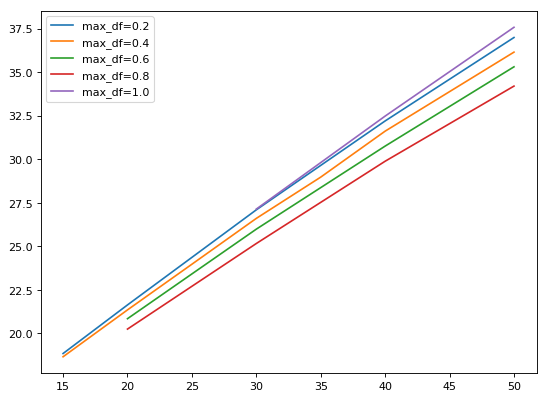

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline
import math

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for max_df, value in perplex_dicts.items():
    X=[]
    Y=[]
    for n_topics, perplexity in value.items():
        X.append(n_topics)
        Y.append(math.log(perplexity))
    zipd = zip(X,Y)
    zipd = sorted(zipd)
    X, Y = zip(*zipd)
    plt.plot(X,Y,label=('max_df='+str(max_df)))
plt.legend()


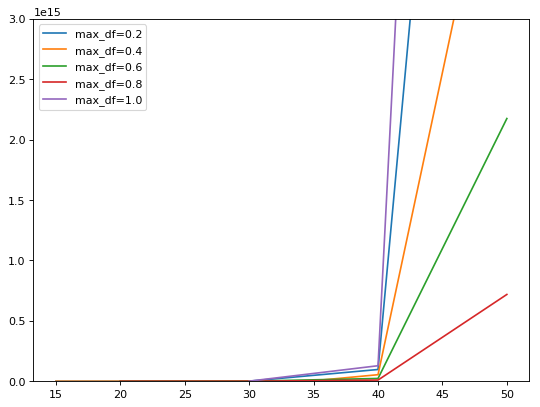

In [40]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.ylim(0, 0.3e16)
for max_df, value in perplex_dicts.items():
    X=[]
    Y=[]
    for n_topics, perplexity in value.items():
        X.append(n_topics)
        Y.append(perplexity)
    zipd = zip(X,Y)
    zipd = sorted(zipd)
    X, Y = zip(*zipd)
    plt.plot(X,Y,label=('max_df='+str(max_df)))
plt.legend()


In [ ]:
sorted([item for item in perplexity_dict.items()],key=lambda x:x[1])

In [ ]:
sorted([item for item in median_scores_dict.items()],key=lambda x:x[1])

In [ ]:
sorted([item for item in scores_dict.items()],key=lambda x:x[1])